# Electron / Photon Classification

In [1]:
# Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset, DataLoader, random_split

import h5py

from sklearn.metrics import roc_auc_score

In [2]:
print(torch.__version__)

1.13.0


In [3]:
print(torch.version.cuda)

11.3


In [4]:
# Setting Seed
torch.manual_seed(47)
torch.cuda.manual_seed_all(47)
torch.cuda.manual_seed(47)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
# Setting device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Defining the Dataset class

class HDF5Dataset(Dataset):
    def __init__(self, file_e, file_p):
        self.file_e = file_e
        self.file_p = file_p
        self.data_key = 'X'
        self.file_electron = h5py.File(self.file_e, 'r')
        self.data_electron = self.file_electron[self.data_key]
        self.file_photon = h5py.File(self.file_p, 'r')
        self.data_photon = self.file_photon[self.data_key]
        self.data = np.concatenate((self.data_electron, self.data_photon), axis=0)
        self.labels = np.concatenate((np.ones(self.data_electron.shape[0]), np.zeros(self.data_photon.shape[0])), axis=0)
        #print(np.sum(self.labels))
        self.labels = np.expand_dims(self.labels, axis=1)
        #mean = np.mean(self.data)
        #print(mean)
        #std = np.std(self.data)
        #print(std)
        #self.data = (self.data - mean)/std


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), torch.from_numpy(self.labels[idx])

    def close(self):
        self.file_electrons.close()
        self.file_photon.close()

In [7]:
# Making training, validation and test datasets
# train data : 80%, validation data : 10%, testing data : 10%

file_e = '/kaggle/input/electrons-and-photons/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_p = '/kaggle/input/electrons-and-photons/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
dataset = HDF5Dataset(file_e, file_p)

train_size = np.int32(0.8 * len(dataset))
test_size = np.int32(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_data, test_data, val_data = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_data, batch_size=200, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=200, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# Defining the model architecture

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        #xmax, xmin = x.min(), x.max()
        #x = (x - xmin)/(xmax - xmin)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, 0.2)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, 0.2)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = torch.relu(x)
        x = torch.nn.functional.dropout(x, 0.2)
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

In [9]:
# model loss and optimizer
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

In [10]:
# Training

epochs = 200
min_val_loss = np.inf

train_losses = []
val_losses = []
train_aucs = []
val_aucs = []
counter = 0

for e in range(epochs):
    train_loss = 0.0
    train_auc = 0.0
    i = 0
    for data in train_loader: # Training Loop
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            train_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[Epoch %d, Batch %d] Loss: %.3f Accuracy: %.3f' %
                  (e + 1, i + 1, train_loss / 100, train_auc / 100))
            train_losses.append(train_loss / 100)
            train_aucs.append(train_auc / 100)
            train_loss = 0.0
            train_auc = 0.0
        
        i += 1
    
    with torch.no_grad():
        val_loss = 0.0
        val_auc = 0.0
        model.eval()
        for data in val_loader: # Validation Loop
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            val_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
    print(f'Epoch {e+1} Val Loss: {val_loss / len(val_loader)} \t\t Val Accuracy: {val_auc / len(val_loader)}')
    
    val_losses.append(val_loss / len(val_loader))
    val_aucs.append(val_auc / len(val_loader))
     
    if min_val_loss > val_loss:
        print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
        min_val_loss = val_loss
        counter = 0 
            
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        
    else:
        # Early Stopping
        counter += 1
        if counter >= 20:
            print('Training Stopped : \t\t Loss did not decrease for 20 epochs.')
            break
        

[Epoch 1, Batch 100] Loss: 0.692 Accuracy: 0.551
[Epoch 1, Batch 200] Loss: 0.684 Accuracy: 0.577
[Epoch 1, Batch 300] Loss: 0.680 Accuracy: 0.594
[Epoch 1, Batch 400] Loss: 0.676 Accuracy: 0.606
[Epoch 1, Batch 500] Loss: 0.673 Accuracy: 0.616
[Epoch 1, Batch 600] Loss: 0.673 Accuracy: 0.614
[Epoch 1, Batch 700] Loss: 0.672 Accuracy: 0.617
[Epoch 1, Batch 800] Loss: 0.670 Accuracy: 0.619
[Epoch 1, Batch 900] Loss: 0.670 Accuracy: 0.616
[Epoch 1, Batch 1000] Loss: 0.666 Accuracy: 0.629
[Epoch 1, Batch 1100] Loss: 0.668 Accuracy: 0.626
[Epoch 1, Batch 1200] Loss: 0.661 Accuracy: 0.643
[Epoch 1, Batch 1300] Loss: 0.665 Accuracy: 0.631
[Epoch 1, Batch 1400] Loss: 0.668 Accuracy: 0.624
[Epoch 1, Batch 1500] Loss: 0.663 Accuracy: 0.637
[Epoch 1, Batch 1600] Loss: 0.664 Accuracy: 0.635
[Epoch 1, Batch 1700] Loss: 0.661 Accuracy: 0.641
[Epoch 1, Batch 1800] Loss: 0.663 Accuracy: 0.635
[Epoch 1, Batch 1900] Loss: 0.664 Accuracy: 0.634


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Val Loss: 0.6589579417044857 		 Val Accuracy: 0.6441760544039072
Validation Loss Decreased(inf--->164.080527) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 2, Batch 100] Loss: 0.659 Accuracy: 0.646
[Epoch 2, Batch 200] Loss: 0.656 Accuracy: 0.650
[Epoch 2, Batch 300] Loss: 0.654 Accuracy: 0.653
[Epoch 2, Batch 400] Loss: 0.657 Accuracy: 0.648
[Epoch 2, Batch 500] Loss: 0.656 Accuracy: 0.648
[Epoch 2, Batch 600] Loss: 0.655 Accuracy: 0.653
[Epoch 2, Batch 700] Loss: 0.657 Accuracy: 0.648
[Epoch 2, Batch 800] Loss: 0.656 Accuracy: 0.649
[Epoch 2, Batch 900] Loss: 0.651 Accuracy: 0.660
[Epoch 2, Batch 1000] Loss: 0.653 Accuracy: 0.657
[Epoch 2, Batch 1100] Loss: 0.657 Accuracy: 0.648
[Epoch 2, Batch 1200] Loss: 0.651 Accuracy: 0.660
[Epoch 2, Batch 1300] Loss: 0.649 Accuracy: 0.662
[Epoch 2, Batch 1400] Loss: 0.650 Accuracy: 0.661
[Epoch 2, Batch 1500] Loss: 0.651 Accuracy: 0.658
[Epoch 2, Batch 1600] Loss: 0.652 Accuracy: 0.657
[Epoch 2, Batch 1700] Loss: 0.648 Accuracy: 0.662
[Epoch 2, Batch 1800] Loss: 0.649 Accuracy: 0.661
[Epoch 2, Batch 1900] Loss: 0.647 Accuracy: 0.665


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Val Loss: 0.6489498517120699 		 Val Accuracy: 0.662579106479534
Validation Loss Decreased(164.080527--->161.588513) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 3, Batch 100] Loss: 0.652 Accuracy: 0.658
[Epoch 3, Batch 200] Loss: 0.649 Accuracy: 0.663
[Epoch 3, Batch 300] Loss: 0.648 Accuracy: 0.665
[Epoch 3, Batch 400] Loss: 0.647 Accuracy: 0.667
[Epoch 3, Batch 500] Loss: 0.645 Accuracy: 0.670
[Epoch 3, Batch 600] Loss: 0.646 Accuracy: 0.670
[Epoch 3, Batch 700] Loss: 0.645 Accuracy: 0.673
[Epoch 3, Batch 800] Loss: 0.644 Accuracy: 0.671
[Epoch 3, Batch 900] Loss: 0.644 Accuracy: 0.673
[Epoch 3, Batch 1000] Loss: 0.643 Accuracy: 0.676
[Epoch 3, Batch 1100] Loss: 0.641 Accuracy: 0.678
[Epoch 3, Batch 1200] Loss: 0.645 Accuracy: 0.671
[Epoch 3, Batch 1300] Loss: 0.638 Accuracy: 0.680
[Epoch 3, Batch 1400] Loss: 0.642 Accuracy: 0.677
[Epoch 3, Batch 1500] Loss: 0.640 Accuracy: 0.682
[Epoch 3, Batch 1600] Loss: 0.637 Accuracy: 0.688
[Epoch 3, Batch 1700] Loss: 0.643 Accuracy: 0.676
[Epoch 3, Batch 1800] Loss: 0.637 Accuracy: 0.687
[Epoch 3, Batch 1900] Loss: 0.639 Accuracy: 0.683


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Val Loss: 0.6379088474564762 		 Val Accuracy: 0.6854709681898223
Validation Loss Decreased(161.588513--->158.839303) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 4, Batch 100] Loss: 0.634 Accuracy: 0.690
[Epoch 4, Batch 200] Loss: 0.635 Accuracy: 0.692
[Epoch 4, Batch 300] Loss: 0.631 Accuracy: 0.696
[Epoch 4, Batch 400] Loss: 0.636 Accuracy: 0.690
[Epoch 4, Batch 500] Loss: 0.635 Accuracy: 0.691
[Epoch 4, Batch 600] Loss: 0.633 Accuracy: 0.693
[Epoch 4, Batch 700] Loss: 0.628 Accuracy: 0.703
[Epoch 4, Batch 800] Loss: 0.634 Accuracy: 0.697
[Epoch 4, Batch 900] Loss: 0.628 Accuracy: 0.702
[Epoch 4, Batch 1000] Loss: 0.625 Accuracy: 0.708
[Epoch 4, Batch 1100] Loss: 0.627 Accuracy: 0.704
[Epoch 4, Batch 1200] Loss: 0.626 Accuracy: 0.706
[Epoch 4, Batch 1300] Loss: 0.624 Accuracy: 0.707
[Epoch 4, Batch 1400] Loss: 0.628 Accuracy: 0.703
[Epoch 4, Batch 1500] Loss: 0.624 Accuracy: 0.710
[Epoch 4, Batch 1600] Loss: 0.626 Accuracy: 0.705
[Epoch 4, Batch 1700] Loss: 0.625 Accuracy: 0.713
[Epoch 4, Batch 1800] Loss: 0.623 Accuracy: 0.713
[Epoch 4, Batch 1900] Loss: 0.624 Accuracy: 0.711


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Val Loss: 0.62624514701376 		 Val Accuracy: 0.7141135008450115
Validation Loss Decreased(158.839303--->155.935042) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 5, Batch 100] Loss: 0.623 Accuracy: 0.712
[Epoch 5, Batch 200] Loss: 0.617 Accuracy: 0.718
[Epoch 5, Batch 300] Loss: 0.624 Accuracy: 0.708
[Epoch 5, Batch 400] Loss: 0.616 Accuracy: 0.722
[Epoch 5, Batch 500] Loss: 0.618 Accuracy: 0.717
[Epoch 5, Batch 600] Loss: 0.617 Accuracy: 0.718
[Epoch 5, Batch 700] Loss: 0.615 Accuracy: 0.722
[Epoch 5, Batch 800] Loss: 0.614 Accuracy: 0.725
[Epoch 5, Batch 900] Loss: 0.618 Accuracy: 0.718
[Epoch 5, Batch 1000] Loss: 0.615 Accuracy: 0.724
[Epoch 5, Batch 1100] Loss: 0.616 Accuracy: 0.722
[Epoch 5, Batch 1200] Loss: 0.618 Accuracy: 0.717
[Epoch 5, Batch 1300] Loss: 0.611 Accuracy: 0.726
[Epoch 5, Batch 1400] Loss: 0.614 Accuracy: 0.724
[Epoch 5, Batch 1500] Loss: 0.613 Accuracy: 0.725
[Epoch 5, Batch 1600] Loss: 0.614 Accuracy: 0.725
[Epoch 5, Batch 1700] Loss: 0.611 Accuracy: 0.727
[Epoch 5, Batch 1800] Loss: 0.617 Accuracy: 0.722
[Epoch 5, Batch 1900] Loss: 0.611 Accuracy: 0.728


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Val Loss: 0.6089124605358844 		 Val Accuracy: 0.7295749764528171
Validation Loss Decreased(155.935042--->151.619203) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 6, Batch 100] Loss: 0.611 Accuracy: 0.727
[Epoch 6, Batch 200] Loss: 0.611 Accuracy: 0.729
[Epoch 6, Batch 300] Loss: 0.612 Accuracy: 0.729
[Epoch 6, Batch 400] Loss: 0.612 Accuracy: 0.728
[Epoch 6, Batch 500] Loss: 0.609 Accuracy: 0.731
[Epoch 6, Batch 600] Loss: 0.606 Accuracy: 0.733
[Epoch 6, Batch 700] Loss: 0.608 Accuracy: 0.731
[Epoch 6, Batch 800] Loss: 0.614 Accuracy: 0.723
[Epoch 6, Batch 900] Loss: 0.608 Accuracy: 0.732
[Epoch 6, Batch 1000] Loss: 0.604 Accuracy: 0.738
[Epoch 6, Batch 1100] Loss: 0.605 Accuracy: 0.736
[Epoch 6, Batch 1200] Loss: 0.609 Accuracy: 0.731
[Epoch 6, Batch 1300] Loss: 0.604 Accuracy: 0.736
[Epoch 6, Batch 1400] Loss: 0.609 Accuracy: 0.729
[Epoch 6, Batch 1500] Loss: 0.601 Accuracy: 0.739
[Epoch 6, Batch 1600] Loss: 0.605 Accuracy: 0.737
[Epoch 6, Batch 1700] Loss: 0.603 Accuracy: 0.739
[Epoch 6, Batch 1800] Loss: 0.598 Accuracy: 0.746
[Epoch 6, Batch 1900] Loss: 0.610 Accuracy: 0.731


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Val Loss: 0.6002638421384207 		 Val Accuracy: 0.739959989005357
Validation Loss Decreased(151.619203--->149.465697) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 7, Batch 100] Loss: 0.605 Accuracy: 0.735
[Epoch 7, Batch 200] Loss: 0.601 Accuracy: 0.742
[Epoch 7, Batch 300] Loss: 0.607 Accuracy: 0.735
[Epoch 7, Batch 400] Loss: 0.602 Accuracy: 0.739
[Epoch 7, Batch 500] Loss: 0.602 Accuracy: 0.739
[Epoch 7, Batch 600] Loss: 0.599 Accuracy: 0.743
[Epoch 7, Batch 700] Loss: 0.603 Accuracy: 0.739
[Epoch 7, Batch 800] Loss: 0.604 Accuracy: 0.737
[Epoch 7, Batch 900] Loss: 0.598 Accuracy: 0.745
[Epoch 7, Batch 1000] Loss: 0.598 Accuracy: 0.743
[Epoch 7, Batch 1100] Loss: 0.597 Accuracy: 0.747
[Epoch 7, Batch 1200] Loss: 0.603 Accuracy: 0.740
[Epoch 7, Batch 1300] Loss: 0.600 Accuracy: 0.745
[Epoch 7, Batch 1400] Loss: 0.601 Accuracy: 0.742
[Epoch 7, Batch 1500] Loss: 0.596 Accuracy: 0.745
[Epoch 7, Batch 1600] Loss: 0.598 Accuracy: 0.744
[Epoch 7, Batch 1700] Loss: 0.600 Accuracy: 0.744
[Epoch 7, Batch 1800] Loss: 0.599 Accuracy: 0.743
[Epoch 7, Batch 1900] Loss: 0.598 Accuracy: 0.746


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Val Loss: 0.5966339286072666 		 Val Accuracy: 0.7471618905456336
Validation Loss Decreased(149.465697--->148.561848) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 8, Batch 100] Loss: 0.600 Accuracy: 0.744
[Epoch 8, Batch 200] Loss: 0.596 Accuracy: 0.747
[Epoch 8, Batch 300] Loss: 0.600 Accuracy: 0.743
[Epoch 8, Batch 400] Loss: 0.596 Accuracy: 0.746
[Epoch 8, Batch 500] Loss: 0.597 Accuracy: 0.744
[Epoch 8, Batch 600] Loss: 0.600 Accuracy: 0.742
[Epoch 8, Batch 700] Loss: 0.595 Accuracy: 0.750
[Epoch 8, Batch 800] Loss: 0.595 Accuracy: 0.748
[Epoch 8, Batch 900] Loss: 0.594 Accuracy: 0.751
[Epoch 8, Batch 1000] Loss: 0.598 Accuracy: 0.745
[Epoch 8, Batch 1100] Loss: 0.594 Accuracy: 0.749
[Epoch 8, Batch 1200] Loss: 0.593 Accuracy: 0.750
[Epoch 8, Batch 1300] Loss: 0.598 Accuracy: 0.746
[Epoch 8, Batch 1400] Loss: 0.594 Accuracy: 0.751
[Epoch 8, Batch 1500] Loss: 0.596 Accuracy: 0.748
[Epoch 8, Batch 1600] Loss: 0.589 Accuracy: 0.756
[Epoch 8, Batch 1700] Loss: 0.598 Accuracy: 0.744
[Epoch 8, Batch 1800] Loss: 0.588 Accuracy: 0.755
[Epoch 8, Batch 1900] Loss: 0.602 Accuracy: 0.741


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Val Loss: 0.5962948361075068 		 Val Accuracy: 0.7533846318053394
Validation Loss Decreased(148.561848--->148.477414) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 9, Batch 100] Loss: 0.598 Accuracy: 0.747
[Epoch 9, Batch 200] Loss: 0.592 Accuracy: 0.751
[Epoch 9, Batch 300] Loss: 0.591 Accuracy: 0.749
[Epoch 9, Batch 400] Loss: 0.592 Accuracy: 0.752
[Epoch 9, Batch 500] Loss: 0.595 Accuracy: 0.750
[Epoch 9, Batch 600] Loss: 0.594 Accuracy: 0.749
[Epoch 9, Batch 700] Loss: 0.591 Accuracy: 0.753
[Epoch 9, Batch 800] Loss: 0.596 Accuracy: 0.747
[Epoch 9, Batch 900] Loss: 0.589 Accuracy: 0.758
[Epoch 9, Batch 1000] Loss: 0.588 Accuracy: 0.755
[Epoch 9, Batch 1100] Loss: 0.593 Accuracy: 0.750
[Epoch 9, Batch 1200] Loss: 0.588 Accuracy: 0.757
[Epoch 9, Batch 1300] Loss: 0.588 Accuracy: 0.757
[Epoch 9, Batch 1400] Loss: 0.591 Accuracy: 0.753
[Epoch 9, Batch 1500] Loss: 0.589 Accuracy: 0.755
[Epoch 9, Batch 1600] Loss: 0.589 Accuracy: 0.757
[Epoch 9, Batch 1700] Loss: 0.590 Accuracy: 0.756
[Epoch 9, Batch 1800] Loss: 0.589 Accuracy: 0.756
[Epoch 9, Batch 1900] Loss: 0.594 Accuracy: 0.753


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Val Loss: 0.585188879545434 		 Val Accuracy: 0.7573072281657083
Validation Loss Decreased(148.477414--->145.712031) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 10, Batch 100] Loss: 0.590 Accuracy: 0.753
[Epoch 10, Batch 200] Loss: 0.592 Accuracy: 0.751
[Epoch 10, Batch 300] Loss: 0.587 Accuracy: 0.759
[Epoch 10, Batch 400] Loss: 0.592 Accuracy: 0.751
[Epoch 10, Batch 500] Loss: 0.584 Accuracy: 0.760
[Epoch 10, Batch 600] Loss: 0.591 Accuracy: 0.753
[Epoch 10, Batch 700] Loss: 0.588 Accuracy: 0.755
[Epoch 10, Batch 800] Loss: 0.586 Accuracy: 0.759
[Epoch 10, Batch 900] Loss: 0.584 Accuracy: 0.761
[Epoch 10, Batch 1000] Loss: 0.585 Accuracy: 0.760
[Epoch 10, Batch 1100] Loss: 0.586 Accuracy: 0.759
[Epoch 10, Batch 1200] Loss: 0.582 Accuracy: 0.764
[Epoch 10, Batch 1300] Loss: 0.592 Accuracy: 0.754
[Epoch 10, Batch 1400] Loss: 0.588 Accuracy: 0.757
[Epoch 10, Batch 1500] Loss: 0.589 Accuracy: 0.757
[Epoch 10, Batch 1600] Loss: 0.583 Accuracy: 0.762
[Epoch 10, Batch 1700] Loss: 0.586 Accuracy: 0.760
[Epoch 10, Batch 1800] Loss: 0.588 Accuracy: 0.757
[Epoch 10, Batch 1900] Loss: 0.588 Accuracy: 0.756


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Val Loss: 0.5839592672016726 		 Val Accuracy: 0.762831299576064
Validation Loss Decreased(145.712031--->145.405858) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 11, Batch 100] Loss: 0.586 Accuracy: 0.759
[Epoch 11, Batch 200] Loss: 0.584 Accuracy: 0.763
[Epoch 11, Batch 300] Loss: 0.583 Accuracy: 0.761
[Epoch 11, Batch 400] Loss: 0.585 Accuracy: 0.760
[Epoch 11, Batch 500] Loss: 0.587 Accuracy: 0.757
[Epoch 11, Batch 600] Loss: 0.586 Accuracy: 0.760
[Epoch 11, Batch 700] Loss: 0.580 Accuracy: 0.765
[Epoch 11, Batch 800] Loss: 0.582 Accuracy: 0.764
[Epoch 11, Batch 900] Loss: 0.581 Accuracy: 0.765
[Epoch 11, Batch 1000] Loss: 0.584 Accuracy: 0.760
[Epoch 11, Batch 1100] Loss: 0.586 Accuracy: 0.759
[Epoch 11, Batch 1200] Loss: 0.587 Accuracy: 0.758
[Epoch 11, Batch 1300] Loss: 0.587 Accuracy: 0.758
[Epoch 11, Batch 1400] Loss: 0.584 Accuracy: 0.761
[Epoch 11, Batch 1500] Loss: 0.581 Accuracy: 0.765
[Epoch 11, Batch 1600] Loss: 0.582 Accuracy: 0.763
[Epoch 11, Batch 1700] Loss: 0.583 Accuracy: 0.762
[Epoch 11, Batch 1800] Loss: 0.584 Accuracy: 0.760
[Epoch 11, Batch 1900] Loss: 0.590 Accuracy: 0.754


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Val Loss: 0.5845445195833842 		 Val Accuracy: 0.7587648713596022


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 12, Batch 100] Loss: 0.585 Accuracy: 0.760
[Epoch 12, Batch 200] Loss: 0.585 Accuracy: 0.761
[Epoch 12, Batch 300] Loss: 0.584 Accuracy: 0.762
[Epoch 12, Batch 400] Loss: 0.579 Accuracy: 0.765
[Epoch 12, Batch 500] Loss: 0.583 Accuracy: 0.764
[Epoch 12, Batch 600] Loss: 0.581 Accuracy: 0.765
[Epoch 12, Batch 700] Loss: 0.581 Accuracy: 0.764
[Epoch 12, Batch 800] Loss: 0.584 Accuracy: 0.763
[Epoch 12, Batch 900] Loss: 0.587 Accuracy: 0.758
[Epoch 12, Batch 1000] Loss: 0.584 Accuracy: 0.762
[Epoch 12, Batch 1100] Loss: 0.580 Accuracy: 0.766
[Epoch 12, Batch 1200] Loss: 0.584 Accuracy: 0.761
[Epoch 12, Batch 1300] Loss: 0.582 Accuracy: 0.761
[Epoch 12, Batch 1400] Loss: 0.574 Accuracy: 0.772
[Epoch 12, Batch 1500] Loss: 0.578 Accuracy: 0.767
[Epoch 12, Batch 1600] Loss: 0.588 Accuracy: 0.756
[Epoch 12, Batch 1700] Loss: 0.584 Accuracy: 0.761
[Epoch 12, Batch 1800] Loss: 0.580 Accuracy: 0.764
[Epoch 12, Batch 1900] Loss: 0.578 Accuracy: 0.767


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Val Loss: 0.5813739263867758 		 Val Accuracy: 0.764893158536025
Validation Loss Decreased(145.405858--->144.762108) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 13, Batch 100] Loss: 0.580 Accuracy: 0.764
[Epoch 13, Batch 200] Loss: 0.582 Accuracy: 0.761
[Epoch 13, Batch 300] Loss: 0.577 Accuracy: 0.768
[Epoch 13, Batch 400] Loss: 0.574 Accuracy: 0.773
[Epoch 13, Batch 500] Loss: 0.582 Accuracy: 0.762
[Epoch 13, Batch 600] Loss: 0.574 Accuracy: 0.772
[Epoch 13, Batch 700] Loss: 0.580 Accuracy: 0.764
[Epoch 13, Batch 800] Loss: 0.580 Accuracy: 0.766
[Epoch 13, Batch 900] Loss: 0.578 Accuracy: 0.769
[Epoch 13, Batch 1000] Loss: 0.583 Accuracy: 0.761
[Epoch 13, Batch 1100] Loss: 0.579 Accuracy: 0.769
[Epoch 13, Batch 1200] Loss: 0.577 Accuracy: 0.769
[Epoch 13, Batch 1300] Loss: 0.583 Accuracy: 0.761
[Epoch 13, Batch 1400] Loss: 0.584 Accuracy: 0.759
[Epoch 13, Batch 1500] Loss: 0.582 Accuracy: 0.764
[Epoch 13, Batch 1600] Loss: 0.582 Accuracy: 0.765
[Epoch 13, Batch 1700] Loss: 0.582 Accuracy: 0.764
[Epoch 13, Batch 1800] Loss: 0.579 Accuracy: 0.767
[Epoch 13, Batch 1900] Loss: 0.574 Accuracy: 0.772


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Val Loss: 0.5733006955629372 		 Val Accuracy: 0.7707352553690444
Validation Loss Decreased(144.762108--->142.751873) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 14, Batch 100] Loss: 0.583 Accuracy: 0.762
[Epoch 14, Batch 200] Loss: 0.580 Accuracy: 0.765
[Epoch 14, Batch 300] Loss: 0.576 Accuracy: 0.768
[Epoch 14, Batch 400] Loss: 0.576 Accuracy: 0.768
[Epoch 14, Batch 500] Loss: 0.578 Accuracy: 0.767
[Epoch 14, Batch 600] Loss: 0.575 Accuracy: 0.770
[Epoch 14, Batch 700] Loss: 0.576 Accuracy: 0.769
[Epoch 14, Batch 800] Loss: 0.578 Accuracy: 0.767
[Epoch 14, Batch 900] Loss: 0.580 Accuracy: 0.765
[Epoch 14, Batch 1000] Loss: 0.578 Accuracy: 0.768
[Epoch 14, Batch 1100] Loss: 0.581 Accuracy: 0.763
[Epoch 14, Batch 1200] Loss: 0.583 Accuracy: 0.760
[Epoch 14, Batch 1300] Loss: 0.584 Accuracy: 0.761
[Epoch 14, Batch 1400] Loss: 0.577 Accuracy: 0.769
[Epoch 14, Batch 1500] Loss: 0.577 Accuracy: 0.768
[Epoch 14, Batch 1600] Loss: 0.575 Accuracy: 0.769
[Epoch 14, Batch 1700] Loss: 0.571 Accuracy: 0.775
[Epoch 14, Batch 1800] Loss: 0.577 Accuracy: 0.769
[Epoch 14, Batch 1900] Loss: 0.585 Accuracy: 0.762


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Val Loss: 0.5963551440392153 		 Val Accuracy: 0.7573092278453037


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 15, Batch 100] Loss: 0.578 Accuracy: 0.768
[Epoch 15, Batch 200] Loss: 0.575 Accuracy: 0.770
[Epoch 15, Batch 300] Loss: 0.576 Accuracy: 0.770
[Epoch 15, Batch 400] Loss: 0.578 Accuracy: 0.768
[Epoch 15, Batch 500] Loss: 0.574 Accuracy: 0.772
[Epoch 15, Batch 600] Loss: 0.571 Accuracy: 0.774
[Epoch 15, Batch 700] Loss: 0.575 Accuracy: 0.769
[Epoch 15, Batch 800] Loss: 0.572 Accuracy: 0.773
[Epoch 15, Batch 900] Loss: 0.575 Accuracy: 0.771
[Epoch 15, Batch 1000] Loss: 0.578 Accuracy: 0.768
[Epoch 15, Batch 1100] Loss: 0.580 Accuracy: 0.765
[Epoch 15, Batch 1200] Loss: 0.578 Accuracy: 0.768
[Epoch 15, Batch 1300] Loss: 0.579 Accuracy: 0.767
[Epoch 15, Batch 1400] Loss: 0.571 Accuracy: 0.774
[Epoch 15, Batch 1500] Loss: 0.579 Accuracy: 0.765
[Epoch 15, Batch 1600] Loss: 0.575 Accuracy: 0.771
[Epoch 15, Batch 1700] Loss: 0.576 Accuracy: 0.769
[Epoch 15, Batch 1800] Loss: 0.574 Accuracy: 0.771
[Epoch 15, Batch 1900] Loss: 0.581 Accuracy: 0.765


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Val Loss: 0.577983787739612 		 Val Accuracy: 0.7698914148856512


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 16, Batch 100] Loss: 0.580 Accuracy: 0.767
[Epoch 16, Batch 200] Loss: 0.570 Accuracy: 0.775
[Epoch 16, Batch 300] Loss: 0.577 Accuracy: 0.769
[Epoch 16, Batch 400] Loss: 0.573 Accuracy: 0.774
[Epoch 16, Batch 500] Loss: 0.576 Accuracy: 0.771
[Epoch 16, Batch 600] Loss: 0.581 Accuracy: 0.766
[Epoch 16, Batch 700] Loss: 0.575 Accuracy: 0.770
[Epoch 16, Batch 800] Loss: 0.573 Accuracy: 0.772
[Epoch 16, Batch 900] Loss: 0.572 Accuracy: 0.773
[Epoch 16, Batch 1000] Loss: 0.577 Accuracy: 0.768
[Epoch 16, Batch 1100] Loss: 0.575 Accuracy: 0.770
[Epoch 16, Batch 1200] Loss: 0.576 Accuracy: 0.768
[Epoch 16, Batch 1300] Loss: 0.573 Accuracy: 0.772
[Epoch 16, Batch 1400] Loss: 0.572 Accuracy: 0.774
[Epoch 16, Batch 1500] Loss: 0.574 Accuracy: 0.772
[Epoch 16, Batch 1600] Loss: 0.577 Accuracy: 0.769
[Epoch 16, Batch 1700] Loss: 0.576 Accuracy: 0.770
[Epoch 16, Batch 1800] Loss: 0.578 Accuracy: 0.769
[Epoch 16, Batch 1900] Loss: 0.573 Accuracy: 0.773


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Val Loss: 0.5685219428386076 		 Val Accuracy: 0.7754687476379487
Validation Loss Decreased(142.751873--->141.561964) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 17, Batch 100] Loss: 0.574 Accuracy: 0.772
[Epoch 17, Batch 200] Loss: 0.575 Accuracy: 0.770
[Epoch 17, Batch 300] Loss: 0.571 Accuracy: 0.774
[Epoch 17, Batch 400] Loss: 0.573 Accuracy: 0.771
[Epoch 17, Batch 500] Loss: 0.572 Accuracy: 0.773
[Epoch 17, Batch 600] Loss: 0.581 Accuracy: 0.764
[Epoch 17, Batch 700] Loss: 0.569 Accuracy: 0.776
[Epoch 17, Batch 800] Loss: 0.572 Accuracy: 0.773
[Epoch 17, Batch 900] Loss: 0.569 Accuracy: 0.775
[Epoch 17, Batch 1000] Loss: 0.572 Accuracy: 0.773
[Epoch 17, Batch 1100] Loss: 0.572 Accuracy: 0.775
[Epoch 17, Batch 1200] Loss: 0.572 Accuracy: 0.772
[Epoch 17, Batch 1300] Loss: 0.576 Accuracy: 0.770
[Epoch 17, Batch 1400] Loss: 0.573 Accuracy: 0.772
[Epoch 17, Batch 1500] Loss: 0.578 Accuracy: 0.768
[Epoch 17, Batch 1600] Loss: 0.574 Accuracy: 0.770
[Epoch 17, Batch 1700] Loss: 0.568 Accuracy: 0.778
[Epoch 17, Batch 1800] Loss: 0.574 Accuracy: 0.771
[Epoch 17, Batch 1900] Loss: 0.569 Accuracy: 0.778


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Val Loss: 0.5741721069717024 		 Val Accuracy: 0.7724972238949849


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 18, Batch 100] Loss: 0.573 Accuracy: 0.771
[Epoch 18, Batch 200] Loss: 0.570 Accuracy: 0.774
[Epoch 18, Batch 300] Loss: 0.573 Accuracy: 0.771
[Epoch 18, Batch 400] Loss: 0.572 Accuracy: 0.773
[Epoch 18, Batch 500] Loss: 0.574 Accuracy: 0.772
[Epoch 18, Batch 600] Loss: 0.572 Accuracy: 0.774
[Epoch 18, Batch 700] Loss: 0.573 Accuracy: 0.773
[Epoch 18, Batch 800] Loss: 0.574 Accuracy: 0.771
[Epoch 18, Batch 900] Loss: 0.576 Accuracy: 0.770
[Epoch 18, Batch 1000] Loss: 0.567 Accuracy: 0.779
[Epoch 18, Batch 1100] Loss: 0.572 Accuracy: 0.773
[Epoch 18, Batch 1200] Loss: 0.570 Accuracy: 0.777
[Epoch 18, Batch 1300] Loss: 0.574 Accuracy: 0.772
[Epoch 18, Batch 1400] Loss: 0.573 Accuracy: 0.772
[Epoch 18, Batch 1500] Loss: 0.567 Accuracy: 0.779
[Epoch 18, Batch 1600] Loss: 0.568 Accuracy: 0.778
[Epoch 18, Batch 1700] Loss: 0.570 Accuracy: 0.774
[Epoch 18, Batch 1800] Loss: 0.579 Accuracy: 0.767
[Epoch 18, Batch 1900] Loss: 0.578 Accuracy: 0.767


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Val Loss: 0.574543546840369 		 Val Accuracy: 0.7705562749564816


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 19, Batch 100] Loss: 0.572 Accuracy: 0.774
[Epoch 19, Batch 200] Loss: 0.570 Accuracy: 0.776
[Epoch 19, Batch 300] Loss: 0.571 Accuracy: 0.773
[Epoch 19, Batch 400] Loss: 0.574 Accuracy: 0.771
[Epoch 19, Batch 500] Loss: 0.570 Accuracy: 0.774
[Epoch 19, Batch 600] Loss: 0.574 Accuracy: 0.771
[Epoch 19, Batch 700] Loss: 0.575 Accuracy: 0.771
[Epoch 19, Batch 800] Loss: 0.573 Accuracy: 0.772
[Epoch 19, Batch 900] Loss: 0.566 Accuracy: 0.779
[Epoch 19, Batch 1000] Loss: 0.571 Accuracy: 0.774
[Epoch 19, Batch 1100] Loss: 0.567 Accuracy: 0.779
[Epoch 19, Batch 1200] Loss: 0.573 Accuracy: 0.773
[Epoch 19, Batch 1300] Loss: 0.569 Accuracy: 0.777
[Epoch 19, Batch 1400] Loss: 0.572 Accuracy: 0.773
[Epoch 19, Batch 1500] Loss: 0.567 Accuracy: 0.780
[Epoch 19, Batch 1600] Loss: 0.575 Accuracy: 0.770
[Epoch 19, Batch 1700] Loss: 0.572 Accuracy: 0.774
[Epoch 19, Batch 1800] Loss: 0.565 Accuracy: 0.782
[Epoch 19, Batch 1900] Loss: 0.574 Accuracy: 0.772


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Val Loss: 0.5680468518092451 		 Val Accuracy: 0.7774388152624849
Validation Loss Decreased(141.561964--->141.443666) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 20, Batch 100] Loss: 0.574 Accuracy: 0.775
[Epoch 20, Batch 200] Loss: 0.570 Accuracy: 0.774
[Epoch 20, Batch 300] Loss: 0.575 Accuracy: 0.770
[Epoch 20, Batch 400] Loss: 0.575 Accuracy: 0.771
[Epoch 20, Batch 500] Loss: 0.574 Accuracy: 0.771
[Epoch 20, Batch 600] Loss: 0.574 Accuracy: 0.772
[Epoch 20, Batch 700] Loss: 0.570 Accuracy: 0.775
[Epoch 20, Batch 800] Loss: 0.574 Accuracy: 0.771
[Epoch 20, Batch 900] Loss: 0.574 Accuracy: 0.771
[Epoch 20, Batch 1000] Loss: 0.565 Accuracy: 0.780
[Epoch 20, Batch 1100] Loss: 0.566 Accuracy: 0.780
[Epoch 20, Batch 1200] Loss: 0.563 Accuracy: 0.782
[Epoch 20, Batch 1300] Loss: 0.565 Accuracy: 0.780
[Epoch 20, Batch 1400] Loss: 0.574 Accuracy: 0.772
[Epoch 20, Batch 1500] Loss: 0.565 Accuracy: 0.781
[Epoch 20, Batch 1600] Loss: 0.572 Accuracy: 0.775
[Epoch 20, Batch 1700] Loss: 0.571 Accuracy: 0.773
[Epoch 20, Batch 1800] Loss: 0.567 Accuracy: 0.778
[Epoch 20, Batch 1900] Loss: 0.565 Accuracy: 0.781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 20 Val Loss: 0.5772234555707878 		 Val Accuracy: 0.7661578343530587


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 21, Batch 100] Loss: 0.569 Accuracy: 0.776
[Epoch 21, Batch 200] Loss: 0.569 Accuracy: 0.777
[Epoch 21, Batch 300] Loss: 0.570 Accuracy: 0.776
[Epoch 21, Batch 400] Loss: 0.572 Accuracy: 0.773
[Epoch 21, Batch 500] Loss: 0.563 Accuracy: 0.783
[Epoch 21, Batch 600] Loss: 0.567 Accuracy: 0.779
[Epoch 21, Batch 700] Loss: 0.572 Accuracy: 0.773
[Epoch 21, Batch 800] Loss: 0.572 Accuracy: 0.774
[Epoch 21, Batch 900] Loss: 0.569 Accuracy: 0.776
[Epoch 21, Batch 1000] Loss: 0.567 Accuracy: 0.779
[Epoch 21, Batch 1100] Loss: 0.571 Accuracy: 0.775
[Epoch 21, Batch 1200] Loss: 0.566 Accuracy: 0.779
[Epoch 21, Batch 1300] Loss: 0.570 Accuracy: 0.776
[Epoch 21, Batch 1400] Loss: 0.565 Accuracy: 0.781
[Epoch 21, Batch 1500] Loss: 0.572 Accuracy: 0.773
[Epoch 21, Batch 1600] Loss: 0.564 Accuracy: 0.782
[Epoch 21, Batch 1700] Loss: 0.567 Accuracy: 0.779
[Epoch 21, Batch 1800] Loss: 0.574 Accuracy: 0.773
[Epoch 21, Batch 1900] Loss: 0.569 Accuracy: 0.778


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 21 Val Loss: 0.5662596188635233 		 Val Accuracy: 0.7795277402305191
Validation Loss Decreased(141.443666--->140.998645) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 22, Batch 100] Loss: 0.571 Accuracy: 0.774
[Epoch 22, Batch 200] Loss: 0.576 Accuracy: 0.769
[Epoch 22, Batch 300] Loss: 0.570 Accuracy: 0.777
[Epoch 22, Batch 400] Loss: 0.569 Accuracy: 0.777
[Epoch 22, Batch 500] Loss: 0.562 Accuracy: 0.784
[Epoch 22, Batch 600] Loss: 0.574 Accuracy: 0.771
[Epoch 22, Batch 700] Loss: 0.563 Accuracy: 0.784
[Epoch 22, Batch 800] Loss: 0.571 Accuracy: 0.774
[Epoch 22, Batch 900] Loss: 0.570 Accuracy: 0.776
[Epoch 22, Batch 1000] Loss: 0.565 Accuracy: 0.781
[Epoch 22, Batch 1100] Loss: 0.566 Accuracy: 0.778
[Epoch 22, Batch 1200] Loss: 0.566 Accuracy: 0.779
[Epoch 22, Batch 1300] Loss: 0.568 Accuracy: 0.777
[Epoch 22, Batch 1400] Loss: 0.567 Accuracy: 0.777
[Epoch 22, Batch 1500] Loss: 0.566 Accuracy: 0.779
[Epoch 22, Batch 1600] Loss: 0.567 Accuracy: 0.777
[Epoch 22, Batch 1700] Loss: 0.567 Accuracy: 0.778
[Epoch 22, Batch 1800] Loss: 0.565 Accuracy: 0.781
[Epoch 22, Batch 1900] Loss: 0.569 Accuracy: 0.777


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 22 Val Loss: 0.5628253058736105 		 Val Accuracy: 0.7814310408924109
Validation Loss Decreased(140.998645--->140.143501) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 23, Batch 100] Loss: 0.566 Accuracy: 0.779
[Epoch 23, Batch 200] Loss: 0.567 Accuracy: 0.778
[Epoch 23, Batch 300] Loss: 0.568 Accuracy: 0.777
[Epoch 23, Batch 400] Loss: 0.571 Accuracy: 0.776
[Epoch 23, Batch 500] Loss: 0.565 Accuracy: 0.780
[Epoch 23, Batch 600] Loss: 0.571 Accuracy: 0.775
[Epoch 23, Batch 700] Loss: 0.574 Accuracy: 0.771
[Epoch 23, Batch 800] Loss: 0.562 Accuracy: 0.784
[Epoch 23, Batch 900] Loss: 0.561 Accuracy: 0.784
[Epoch 23, Batch 1000] Loss: 0.559 Accuracy: 0.786
[Epoch 23, Batch 1100] Loss: 0.562 Accuracy: 0.782
[Epoch 23, Batch 1200] Loss: 0.565 Accuracy: 0.781
[Epoch 23, Batch 1300] Loss: 0.573 Accuracy: 0.772
[Epoch 23, Batch 1400] Loss: 0.568 Accuracy: 0.777
[Epoch 23, Batch 1500] Loss: 0.566 Accuracy: 0.779
[Epoch 23, Batch 1600] Loss: 0.568 Accuracy: 0.777
[Epoch 23, Batch 1700] Loss: 0.570 Accuracy: 0.775
[Epoch 23, Batch 1800] Loss: 0.570 Accuracy: 0.776
[Epoch 23, Batch 1900] Loss: 0.566 Accuracy: 0.781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 23 Val Loss: 0.5620801478744032 		 Val Accuracy: 0.7824308544779418
Validation Loss Decreased(140.143501--->139.957957) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 24, Batch 100] Loss: 0.564 Accuracy: 0.782
[Epoch 24, Batch 200] Loss: 0.560 Accuracy: 0.787
[Epoch 24, Batch 300] Loss: 0.572 Accuracy: 0.774
[Epoch 24, Batch 400] Loss: 0.567 Accuracy: 0.779
[Epoch 24, Batch 500] Loss: 0.562 Accuracy: 0.783
[Epoch 24, Batch 600] Loss: 0.564 Accuracy: 0.781
[Epoch 24, Batch 700] Loss: 0.564 Accuracy: 0.780
[Epoch 24, Batch 800] Loss: 0.564 Accuracy: 0.780
[Epoch 24, Batch 900] Loss: 0.568 Accuracy: 0.778
[Epoch 24, Batch 1000] Loss: 0.571 Accuracy: 0.774
[Epoch 24, Batch 1100] Loss: 0.569 Accuracy: 0.776
[Epoch 24, Batch 1200] Loss: 0.566 Accuracy: 0.781
[Epoch 24, Batch 1300] Loss: 0.565 Accuracy: 0.781
[Epoch 24, Batch 1400] Loss: 0.569 Accuracy: 0.777
[Epoch 24, Batch 1500] Loss: 0.563 Accuracy: 0.782
[Epoch 24, Batch 1600] Loss: 0.567 Accuracy: 0.779
[Epoch 24, Batch 1700] Loss: 0.563 Accuracy: 0.782
[Epoch 24, Batch 1800] Loss: 0.565 Accuracy: 0.779
[Epoch 24, Batch 1900] Loss: 0.571 Accuracy: 0.776


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 24 Val Loss: 0.5661579989285833 		 Val Accuracy: 0.7784219995277442


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 25, Batch 100] Loss: 0.572 Accuracy: 0.773
[Epoch 25, Batch 200] Loss: 0.567 Accuracy: 0.778
[Epoch 25, Batch 300] Loss: 0.565 Accuracy: 0.780
[Epoch 25, Batch 400] Loss: 0.567 Accuracy: 0.779
[Epoch 25, Batch 500] Loss: 0.567 Accuracy: 0.779
[Epoch 25, Batch 600] Loss: 0.561 Accuracy: 0.783
[Epoch 25, Batch 700] Loss: 0.565 Accuracy: 0.781
[Epoch 25, Batch 800] Loss: 0.565 Accuracy: 0.780
[Epoch 25, Batch 900] Loss: 0.568 Accuracy: 0.778
[Epoch 25, Batch 1000] Loss: 0.567 Accuracy: 0.777
[Epoch 25, Batch 1100] Loss: 0.568 Accuracy: 0.776
[Epoch 25, Batch 1200] Loss: 0.561 Accuracy: 0.785
[Epoch 25, Batch 1300] Loss: 0.568 Accuracy: 0.778
[Epoch 25, Batch 1400] Loss: 0.564 Accuracy: 0.782
[Epoch 25, Batch 1500] Loss: 0.564 Accuracy: 0.782
[Epoch 25, Batch 1600] Loss: 0.564 Accuracy: 0.780
[Epoch 25, Batch 1700] Loss: 0.561 Accuracy: 0.785
[Epoch 25, Batch 1800] Loss: 0.565 Accuracy: 0.781
[Epoch 25, Batch 1900] Loss: 0.564 Accuracy: 0.782


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 25 Val Loss: 0.56642147288265 		 Val Accuracy: 0.7820471372490443


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 26, Batch 100] Loss: 0.560 Accuracy: 0.786
[Epoch 26, Batch 200] Loss: 0.569 Accuracy: 0.776
[Epoch 26, Batch 300] Loss: 0.562 Accuracy: 0.783
[Epoch 26, Batch 400] Loss: 0.559 Accuracy: 0.786
[Epoch 26, Batch 500] Loss: 0.561 Accuracy: 0.784
[Epoch 26, Batch 600] Loss: 0.567 Accuracy: 0.780
[Epoch 26, Batch 700] Loss: 0.561 Accuracy: 0.784
[Epoch 26, Batch 800] Loss: 0.563 Accuracy: 0.782
[Epoch 26, Batch 900] Loss: 0.566 Accuracy: 0.778
[Epoch 26, Batch 1000] Loss: 0.563 Accuracy: 0.781
[Epoch 26, Batch 1100] Loss: 0.570 Accuracy: 0.776
[Epoch 26, Batch 1200] Loss: 0.563 Accuracy: 0.782
[Epoch 26, Batch 1300] Loss: 0.570 Accuracy: 0.777
[Epoch 26, Batch 1400] Loss: 0.569 Accuracy: 0.776
[Epoch 26, Batch 1500] Loss: 0.567 Accuracy: 0.778
[Epoch 26, Batch 1600] Loss: 0.568 Accuracy: 0.777
[Epoch 26, Batch 1700] Loss: 0.561 Accuracy: 0.785
[Epoch 26, Batch 1800] Loss: 0.568 Accuracy: 0.778
[Epoch 26, Batch 1900] Loss: 0.562 Accuracy: 0.784


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 26 Val Loss: 0.5639486491201393 		 Val Accuracy: 0.780452556303853


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 27, Batch 100] Loss: 0.567 Accuracy: 0.779
[Epoch 27, Batch 200] Loss: 0.566 Accuracy: 0.781
[Epoch 27, Batch 300] Loss: 0.563 Accuracy: 0.782
[Epoch 27, Batch 400] Loss: 0.570 Accuracy: 0.775
[Epoch 27, Batch 500] Loss: 0.564 Accuracy: 0.782
[Epoch 27, Batch 600] Loss: 0.561 Accuracy: 0.784
[Epoch 27, Batch 700] Loss: 0.561 Accuracy: 0.785
[Epoch 27, Batch 800] Loss: 0.564 Accuracy: 0.781
[Epoch 27, Batch 900] Loss: 0.568 Accuracy: 0.779
[Epoch 27, Batch 1000] Loss: 0.568 Accuracy: 0.779
[Epoch 27, Batch 1100] Loss: 0.565 Accuracy: 0.780
[Epoch 27, Batch 1200] Loss: 0.567 Accuracy: 0.779
[Epoch 27, Batch 1300] Loss: 0.565 Accuracy: 0.780
[Epoch 27, Batch 1400] Loss: 0.565 Accuracy: 0.780
[Epoch 27, Batch 1500] Loss: 0.564 Accuracy: 0.781
[Epoch 27, Batch 1600] Loss: 0.558 Accuracy: 0.788
[Epoch 27, Batch 1700] Loss: 0.562 Accuracy: 0.782
[Epoch 27, Batch 1800] Loss: 0.565 Accuracy: 0.780
[Epoch 27, Batch 1900] Loss: 0.560 Accuracy: 0.786


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 27 Val Loss: 0.5618839138243572 		 Val Accuracy: 0.7843072039617078
Validation Loss Decreased(139.957957--->139.909095) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 28, Batch 100] Loss: 0.561 Accuracy: 0.784
[Epoch 28, Batch 200] Loss: 0.564 Accuracy: 0.781
[Epoch 28, Batch 300] Loss: 0.566 Accuracy: 0.779
[Epoch 28, Batch 400] Loss: 0.559 Accuracy: 0.785
[Epoch 28, Batch 500] Loss: 0.563 Accuracy: 0.783
[Epoch 28, Batch 600] Loss: 0.566 Accuracy: 0.779
[Epoch 28, Batch 700] Loss: 0.565 Accuracy: 0.781
[Epoch 28, Batch 800] Loss: 0.567 Accuracy: 0.778
[Epoch 28, Batch 900] Loss: 0.565 Accuracy: 0.780
[Epoch 28, Batch 1000] Loss: 0.560 Accuracy: 0.784
[Epoch 28, Batch 1100] Loss: 0.559 Accuracy: 0.786
[Epoch 28, Batch 1200] Loss: 0.565 Accuracy: 0.782
[Epoch 28, Batch 1300] Loss: 0.561 Accuracy: 0.784
[Epoch 28, Batch 1400] Loss: 0.565 Accuracy: 0.781
[Epoch 28, Batch 1500] Loss: 0.560 Accuracy: 0.785
[Epoch 28, Batch 1600] Loss: 0.565 Accuracy: 0.780
[Epoch 28, Batch 1700] Loss: 0.564 Accuracy: 0.783
[Epoch 28, Batch 1800] Loss: 0.561 Accuracy: 0.784
[Epoch 28, Batch 1900] Loss: 0.564 Accuracy: 0.781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 28 Val Loss: 0.5594341091841579 		 Val Accuracy: 0.7860672285949821
Validation Loss Decreased(139.909095--->139.299093) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 29, Batch 100] Loss: 0.567 Accuracy: 0.779
[Epoch 29, Batch 200] Loss: 0.566 Accuracy: 0.780
[Epoch 29, Batch 300] Loss: 0.567 Accuracy: 0.778
[Epoch 29, Batch 400] Loss: 0.564 Accuracy: 0.780
[Epoch 29, Batch 500] Loss: 0.561 Accuracy: 0.785
[Epoch 29, Batch 600] Loss: 0.561 Accuracy: 0.785
[Epoch 29, Batch 700] Loss: 0.564 Accuracy: 0.781
[Epoch 29, Batch 800] Loss: 0.562 Accuracy: 0.782
[Epoch 29, Batch 900] Loss: 0.560 Accuracy: 0.786
[Epoch 29, Batch 1000] Loss: 0.563 Accuracy: 0.782
[Epoch 29, Batch 1100] Loss: 0.558 Accuracy: 0.789
[Epoch 29, Batch 1200] Loss: 0.563 Accuracy: 0.782
[Epoch 29, Batch 1300] Loss: 0.562 Accuracy: 0.783
[Epoch 29, Batch 1400] Loss: 0.567 Accuracy: 0.777
[Epoch 29, Batch 1500] Loss: 0.551 Accuracy: 0.794
[Epoch 29, Batch 1600] Loss: 0.560 Accuracy: 0.785
[Epoch 29, Batch 1700] Loss: 0.562 Accuracy: 0.782
[Epoch 29, Batch 1800] Loss: 0.558 Accuracy: 0.787
[Epoch 29, Batch 1900] Loss: 0.563 Accuracy: 0.783


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 29 Val Loss: 0.5632490875969929 		 Val Accuracy: 0.7811475733007818


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 30, Batch 100] Loss: 0.558 Accuracy: 0.787
[Epoch 30, Batch 200] Loss: 0.562 Accuracy: 0.783
[Epoch 30, Batch 300] Loss: 0.559 Accuracy: 0.787
[Epoch 30, Batch 400] Loss: 0.550 Accuracy: 0.795
[Epoch 30, Batch 500] Loss: 0.557 Accuracy: 0.789
[Epoch 30, Batch 600] Loss: 0.561 Accuracy: 0.784
[Epoch 30, Batch 700] Loss: 0.561 Accuracy: 0.783
[Epoch 30, Batch 800] Loss: 0.563 Accuracy: 0.781
[Epoch 30, Batch 900] Loss: 0.560 Accuracy: 0.785
[Epoch 30, Batch 1000] Loss: 0.564 Accuracy: 0.781
[Epoch 30, Batch 1100] Loss: 0.571 Accuracy: 0.775
[Epoch 30, Batch 1200] Loss: 0.563 Accuracy: 0.784
[Epoch 30, Batch 1300] Loss: 0.562 Accuracy: 0.784
[Epoch 30, Batch 1400] Loss: 0.565 Accuracy: 0.781
[Epoch 30, Batch 1500] Loss: 0.562 Accuracy: 0.784
[Epoch 30, Batch 1600] Loss: 0.561 Accuracy: 0.785
[Epoch 30, Batch 1700] Loss: 0.566 Accuracy: 0.780
[Epoch 30, Batch 1800] Loss: 0.564 Accuracy: 0.782
[Epoch 30, Batch 1900] Loss: 0.566 Accuracy: 0.779


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 30 Val Loss: 0.5591949800171526 		 Val Accuracy: 0.7853416701992285
Validation Loss Decreased(139.299093--->139.239550) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 31, Batch 100] Loss: 0.564 Accuracy: 0.780
[Epoch 31, Batch 200] Loss: 0.562 Accuracy: 0.784
[Epoch 31, Batch 300] Loss: 0.563 Accuracy: 0.783
[Epoch 31, Batch 400] Loss: 0.563 Accuracy: 0.781
[Epoch 31, Batch 500] Loss: 0.559 Accuracy: 0.788
[Epoch 31, Batch 600] Loss: 0.566 Accuracy: 0.780
[Epoch 31, Batch 700] Loss: 0.556 Accuracy: 0.790
[Epoch 31, Batch 800] Loss: 0.558 Accuracy: 0.787
[Epoch 31, Batch 900] Loss: 0.559 Accuracy: 0.787
[Epoch 31, Batch 1000] Loss: 0.565 Accuracy: 0.781
[Epoch 31, Batch 1100] Loss: 0.565 Accuracy: 0.781
[Epoch 31, Batch 1200] Loss: 0.564 Accuracy: 0.782
[Epoch 31, Batch 1300] Loss: 0.564 Accuracy: 0.780
[Epoch 31, Batch 1400] Loss: 0.565 Accuracy: 0.780
[Epoch 31, Batch 1500] Loss: 0.556 Accuracy: 0.789
[Epoch 31, Batch 1600] Loss: 0.560 Accuracy: 0.786
[Epoch 31, Batch 1700] Loss: 0.564 Accuracy: 0.780
[Epoch 31, Batch 1800] Loss: 0.557 Accuracy: 0.788
[Epoch 31, Batch 1900] Loss: 0.563 Accuracy: 0.783


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 31 Val Loss: 0.569794539107855 		 Val Accuracy: 0.7820986678182764


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 32, Batch 100] Loss: 0.556 Accuracy: 0.788
[Epoch 32, Batch 200] Loss: 0.559 Accuracy: 0.786
[Epoch 32, Batch 300] Loss: 0.559 Accuracy: 0.785
[Epoch 32, Batch 400] Loss: 0.558 Accuracy: 0.786
[Epoch 32, Batch 500] Loss: 0.566 Accuracy: 0.780
[Epoch 32, Batch 600] Loss: 0.568 Accuracy: 0.778
[Epoch 32, Batch 700] Loss: 0.559 Accuracy: 0.787
[Epoch 32, Batch 800] Loss: 0.564 Accuracy: 0.781
[Epoch 32, Batch 900] Loss: 0.562 Accuracy: 0.783
[Epoch 32, Batch 1000] Loss: 0.566 Accuracy: 0.781
[Epoch 32, Batch 1100] Loss: 0.557 Accuracy: 0.789
[Epoch 32, Batch 1200] Loss: 0.563 Accuracy: 0.782
[Epoch 32, Batch 1300] Loss: 0.559 Accuracy: 0.787
[Epoch 32, Batch 1400] Loss: 0.558 Accuracy: 0.787
[Epoch 32, Batch 1500] Loss: 0.559 Accuracy: 0.785
[Epoch 32, Batch 1600] Loss: 0.562 Accuracy: 0.783
[Epoch 32, Batch 1700] Loss: 0.560 Accuracy: 0.783
[Epoch 32, Batch 1800] Loss: 0.569 Accuracy: 0.777
[Epoch 32, Batch 1900] Loss: 0.558 Accuracy: 0.787


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 32 Val Loss: 0.5608336458723229 		 Val Accuracy: 0.7872083483119456


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 33, Batch 100] Loss: 0.567 Accuracy: 0.779
[Epoch 33, Batch 200] Loss: 0.564 Accuracy: 0.782
[Epoch 33, Batch 300] Loss: 0.562 Accuracy: 0.784
[Epoch 33, Batch 400] Loss: 0.559 Accuracy: 0.787
[Epoch 33, Batch 500] Loss: 0.559 Accuracy: 0.785
[Epoch 33, Batch 600] Loss: 0.558 Accuracy: 0.786
[Epoch 33, Batch 700] Loss: 0.565 Accuracy: 0.781
[Epoch 33, Batch 800] Loss: 0.558 Accuracy: 0.787
[Epoch 33, Batch 900] Loss: 0.559 Accuracy: 0.786
[Epoch 33, Batch 1000] Loss: 0.558 Accuracy: 0.787
[Epoch 33, Batch 1100] Loss: 0.557 Accuracy: 0.788
[Epoch 33, Batch 1200] Loss: 0.560 Accuracy: 0.785
[Epoch 33, Batch 1300] Loss: 0.563 Accuracy: 0.784
[Epoch 33, Batch 1400] Loss: 0.560 Accuracy: 0.784
[Epoch 33, Batch 1500] Loss: 0.568 Accuracy: 0.776
[Epoch 33, Batch 1600] Loss: 0.560 Accuracy: 0.785
[Epoch 33, Batch 1700] Loss: 0.559 Accuracy: 0.788
[Epoch 33, Batch 1800] Loss: 0.555 Accuracy: 0.790
[Epoch 33, Batch 1900] Loss: 0.555 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 33 Val Loss: 0.5597239243218219 		 Val Accuracy: 0.7853826461212099


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 34, Batch 100] Loss: 0.560 Accuracy: 0.785
[Epoch 34, Batch 200] Loss: 0.557 Accuracy: 0.788
[Epoch 34, Batch 300] Loss: 0.562 Accuracy: 0.783
[Epoch 34, Batch 400] Loss: 0.560 Accuracy: 0.786
[Epoch 34, Batch 500] Loss: 0.561 Accuracy: 0.783
[Epoch 34, Batch 600] Loss: 0.566 Accuracy: 0.780
[Epoch 34, Batch 700] Loss: 0.556 Accuracy: 0.790
[Epoch 34, Batch 800] Loss: 0.561 Accuracy: 0.783
[Epoch 34, Batch 900] Loss: 0.555 Accuracy: 0.790
[Epoch 34, Batch 1000] Loss: 0.561 Accuracy: 0.784
[Epoch 34, Batch 1100] Loss: 0.561 Accuracy: 0.784
[Epoch 34, Batch 1200] Loss: 0.557 Accuracy: 0.787
[Epoch 34, Batch 1300] Loss: 0.563 Accuracy: 0.783
[Epoch 34, Batch 1400] Loss: 0.562 Accuracy: 0.785
[Epoch 34, Batch 1500] Loss: 0.556 Accuracy: 0.790
[Epoch 34, Batch 1600] Loss: 0.557 Accuracy: 0.788
[Epoch 34, Batch 1700] Loss: 0.563 Accuracy: 0.782
[Epoch 34, Batch 1800] Loss: 0.555 Accuracy: 0.791
[Epoch 34, Batch 1900] Loss: 0.560 Accuracy: 0.785


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 34 Val Loss: 0.5562234355742672 		 Val Accuracy: 0.7887028352529476
Validation Loss Decreased(139.239550--->138.499635) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 35, Batch 100] Loss: 0.559 Accuracy: 0.787
[Epoch 35, Batch 200] Loss: 0.561 Accuracy: 0.784
[Epoch 35, Batch 300] Loss: 0.558 Accuracy: 0.786
[Epoch 35, Batch 400] Loss: 0.558 Accuracy: 0.787
[Epoch 35, Batch 500] Loss: 0.560 Accuracy: 0.786
[Epoch 35, Batch 600] Loss: 0.565 Accuracy: 0.781
[Epoch 35, Batch 700] Loss: 0.561 Accuracy: 0.785
[Epoch 35, Batch 800] Loss: 0.559 Accuracy: 0.786
[Epoch 35, Batch 900] Loss: 0.561 Accuracy: 0.785
[Epoch 35, Batch 1000] Loss: 0.560 Accuracy: 0.785
[Epoch 35, Batch 1100] Loss: 0.558 Accuracy: 0.786
[Epoch 35, Batch 1200] Loss: 0.559 Accuracy: 0.787
[Epoch 35, Batch 1300] Loss: 0.555 Accuracy: 0.789
[Epoch 35, Batch 1400] Loss: 0.558 Accuracy: 0.786
[Epoch 35, Batch 1500] Loss: 0.558 Accuracy: 0.786
[Epoch 35, Batch 1600] Loss: 0.555 Accuracy: 0.790
[Epoch 35, Batch 1700] Loss: 0.563 Accuracy: 0.782
[Epoch 35, Batch 1800] Loss: 0.555 Accuracy: 0.789
[Epoch 35, Batch 1900] Loss: 0.561 Accuracy: 0.784


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 35 Val Loss: 0.5606602989286783 		 Val Accuracy: 0.7861161654696961


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 36, Batch 100] Loss: 0.558 Accuracy: 0.789
[Epoch 36, Batch 200] Loss: 0.558 Accuracy: 0.787
[Epoch 36, Batch 300] Loss: 0.556 Accuracy: 0.789
[Epoch 36, Batch 400] Loss: 0.564 Accuracy: 0.781
[Epoch 36, Batch 500] Loss: 0.553 Accuracy: 0.792
[Epoch 36, Batch 600] Loss: 0.554 Accuracy: 0.790
[Epoch 36, Batch 700] Loss: 0.561 Accuracy: 0.784
[Epoch 36, Batch 800] Loss: 0.563 Accuracy: 0.782
[Epoch 36, Batch 900] Loss: 0.559 Accuracy: 0.786
[Epoch 36, Batch 1000] Loss: 0.556 Accuracy: 0.790
[Epoch 36, Batch 1100] Loss: 0.556 Accuracy: 0.789
[Epoch 36, Batch 1200] Loss: 0.555 Accuracy: 0.789
[Epoch 36, Batch 1300] Loss: 0.559 Accuracy: 0.787
[Epoch 36, Batch 1400] Loss: 0.557 Accuracy: 0.788
[Epoch 36, Batch 1500] Loss: 0.559 Accuracy: 0.787
[Epoch 36, Batch 1600] Loss: 0.557 Accuracy: 0.787
[Epoch 36, Batch 1700] Loss: 0.563 Accuracy: 0.783
[Epoch 36, Batch 1800] Loss: 0.555 Accuracy: 0.790
[Epoch 36, Batch 1900] Loss: 0.563 Accuracy: 0.781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 36 Val Loss: 0.5582438509866415 		 Val Accuracy: 0.7887509035122956


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 37, Batch 100] Loss: 0.561 Accuracy: 0.783
[Epoch 37, Batch 200] Loss: 0.558 Accuracy: 0.787
[Epoch 37, Batch 300] Loss: 0.560 Accuracy: 0.786
[Epoch 37, Batch 400] Loss: 0.559 Accuracy: 0.785
[Epoch 37, Batch 500] Loss: 0.559 Accuracy: 0.786
[Epoch 37, Batch 600] Loss: 0.562 Accuracy: 0.784
[Epoch 37, Batch 700] Loss: 0.561 Accuracy: 0.783
[Epoch 37, Batch 800] Loss: 0.552 Accuracy: 0.793
[Epoch 37, Batch 900] Loss: 0.559 Accuracy: 0.786
[Epoch 37, Batch 1000] Loss: 0.555 Accuracy: 0.790
[Epoch 37, Batch 1100] Loss: 0.562 Accuracy: 0.782
[Epoch 37, Batch 1200] Loss: 0.560 Accuracy: 0.785
[Epoch 37, Batch 1300] Loss: 0.559 Accuracy: 0.787
[Epoch 37, Batch 1400] Loss: 0.562 Accuracy: 0.783
[Epoch 37, Batch 1500] Loss: 0.554 Accuracy: 0.790
[Epoch 37, Batch 1600] Loss: 0.559 Accuracy: 0.785
[Epoch 37, Batch 1700] Loss: 0.557 Accuracy: 0.787
[Epoch 37, Batch 1800] Loss: 0.553 Accuracy: 0.792
[Epoch 37, Batch 1900] Loss: 0.554 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 37 Val Loss: 0.5556232869385715 		 Val Accuracy: 0.7887996731792605
Validation Loss Decreased(138.499635--->138.350198) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 38, Batch 100] Loss: 0.559 Accuracy: 0.785
[Epoch 38, Batch 200] Loss: 0.561 Accuracy: 0.784
[Epoch 38, Batch 300] Loss: 0.556 Accuracy: 0.789
[Epoch 38, Batch 400] Loss: 0.564 Accuracy: 0.782
[Epoch 38, Batch 500] Loss: 0.556 Accuracy: 0.789
[Epoch 38, Batch 600] Loss: 0.560 Accuracy: 0.785
[Epoch 38, Batch 700] Loss: 0.555 Accuracy: 0.791
[Epoch 38, Batch 800] Loss: 0.552 Accuracy: 0.793
[Epoch 38, Batch 900] Loss: 0.556 Accuracy: 0.789
[Epoch 38, Batch 1000] Loss: 0.554 Accuracy: 0.791
[Epoch 38, Batch 1100] Loss: 0.558 Accuracy: 0.788
[Epoch 38, Batch 1200] Loss: 0.551 Accuracy: 0.793
[Epoch 38, Batch 1300] Loss: 0.561 Accuracy: 0.785
[Epoch 38, Batch 1400] Loss: 0.555 Accuracy: 0.790
[Epoch 38, Batch 1500] Loss: 0.553 Accuracy: 0.791
[Epoch 38, Batch 1600] Loss: 0.561 Accuracy: 0.783
[Epoch 38, Batch 1700] Loss: 0.562 Accuracy: 0.784
[Epoch 38, Batch 1800] Loss: 0.559 Accuracy: 0.786
[Epoch 38, Batch 1900] Loss: 0.562 Accuracy: 0.782


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 38 Val Loss: 0.5598436802266592 		 Val Accuracy: 0.7842789107903472


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 39, Batch 100] Loss: 0.554 Accuracy: 0.790
[Epoch 39, Batch 200] Loss: 0.562 Accuracy: 0.783
[Epoch 39, Batch 300] Loss: 0.558 Accuracy: 0.787
[Epoch 39, Batch 400] Loss: 0.562 Accuracy: 0.784
[Epoch 39, Batch 500] Loss: 0.559 Accuracy: 0.786
[Epoch 39, Batch 600] Loss: 0.559 Accuracy: 0.785
[Epoch 39, Batch 700] Loss: 0.555 Accuracy: 0.790
[Epoch 39, Batch 800] Loss: 0.557 Accuracy: 0.788
[Epoch 39, Batch 900] Loss: 0.554 Accuracy: 0.791
[Epoch 39, Batch 1000] Loss: 0.555 Accuracy: 0.791
[Epoch 39, Batch 1100] Loss: 0.557 Accuracy: 0.788
[Epoch 39, Batch 1200] Loss: 0.554 Accuracy: 0.792
[Epoch 39, Batch 1300] Loss: 0.560 Accuracy: 0.785
[Epoch 39, Batch 1400] Loss: 0.552 Accuracy: 0.793
[Epoch 39, Batch 1500] Loss: 0.560 Accuracy: 0.785
[Epoch 39, Batch 1600] Loss: 0.562 Accuracy: 0.784
[Epoch 39, Batch 1700] Loss: 0.558 Accuracy: 0.789
[Epoch 39, Batch 1800] Loss: 0.554 Accuracy: 0.792
[Epoch 39, Batch 1900] Loss: 0.555 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 39 Val Loss: 0.554508841660128 		 Val Accuracy: 0.7901728573041493
Validation Loss Decreased(138.350198--->138.072702) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 40, Batch 100] Loss: 0.557 Accuracy: 0.788
[Epoch 40, Batch 200] Loss: 0.556 Accuracy: 0.788
[Epoch 40, Batch 300] Loss: 0.561 Accuracy: 0.784
[Epoch 40, Batch 400] Loss: 0.555 Accuracy: 0.790
[Epoch 40, Batch 500] Loss: 0.556 Accuracy: 0.789
[Epoch 40, Batch 600] Loss: 0.551 Accuracy: 0.794
[Epoch 40, Batch 700] Loss: 0.556 Accuracy: 0.788
[Epoch 40, Batch 800] Loss: 0.557 Accuracy: 0.788
[Epoch 40, Batch 900] Loss: 0.554 Accuracy: 0.790
[Epoch 40, Batch 1000] Loss: 0.556 Accuracy: 0.788
[Epoch 40, Batch 1100] Loss: 0.560 Accuracy: 0.786
[Epoch 40, Batch 1200] Loss: 0.558 Accuracy: 0.787
[Epoch 40, Batch 1300] Loss: 0.558 Accuracy: 0.788
[Epoch 40, Batch 1400] Loss: 0.553 Accuracy: 0.792
[Epoch 40, Batch 1500] Loss: 0.556 Accuracy: 0.788
[Epoch 40, Batch 1600] Loss: 0.560 Accuracy: 0.783
[Epoch 40, Batch 1700] Loss: 0.557 Accuracy: 0.787
[Epoch 40, Batch 1800] Loss: 0.557 Accuracy: 0.789
[Epoch 40, Batch 1900] Loss: 0.552 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 40 Val Loss: 0.5619693627079807 		 Val Accuracy: 0.7863005428990002


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 41, Batch 100] Loss: 0.553 Accuracy: 0.793
[Epoch 41, Batch 200] Loss: 0.558 Accuracy: 0.786
[Epoch 41, Batch 300] Loss: 0.555 Accuracy: 0.789
[Epoch 41, Batch 400] Loss: 0.559 Accuracy: 0.786
[Epoch 41, Batch 500] Loss: 0.555 Accuracy: 0.791
[Epoch 41, Batch 600] Loss: 0.549 Accuracy: 0.795
[Epoch 41, Batch 700] Loss: 0.553 Accuracy: 0.792
[Epoch 41, Batch 800] Loss: 0.560 Accuracy: 0.786
[Epoch 41, Batch 900] Loss: 0.555 Accuracy: 0.791
[Epoch 41, Batch 1000] Loss: 0.557 Accuracy: 0.788
[Epoch 41, Batch 1100] Loss: 0.556 Accuracy: 0.789
[Epoch 41, Batch 1200] Loss: 0.554 Accuracy: 0.790
[Epoch 41, Batch 1300] Loss: 0.561 Accuracy: 0.784
[Epoch 41, Batch 1400] Loss: 0.557 Accuracy: 0.787
[Epoch 41, Batch 1500] Loss: 0.560 Accuracy: 0.785
[Epoch 41, Batch 1600] Loss: 0.560 Accuracy: 0.784
[Epoch 41, Batch 1700] Loss: 0.554 Accuracy: 0.791
[Epoch 41, Batch 1800] Loss: 0.554 Accuracy: 0.790
[Epoch 41, Batch 1900] Loss: 0.561 Accuracy: 0.784


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 41 Val Loss: 0.5604971303757893 		 Val Accuracy: 0.7847298100095487


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 42, Batch 100] Loss: 0.553 Accuracy: 0.791
[Epoch 42, Batch 200] Loss: 0.552 Accuracy: 0.793
[Epoch 42, Batch 300] Loss: 0.558 Accuracy: 0.787
[Epoch 42, Batch 400] Loss: 0.559 Accuracy: 0.786
[Epoch 42, Batch 500] Loss: 0.558 Accuracy: 0.787
[Epoch 42, Batch 600] Loss: 0.559 Accuracy: 0.787
[Epoch 42, Batch 700] Loss: 0.551 Accuracy: 0.793
[Epoch 42, Batch 800] Loss: 0.556 Accuracy: 0.789
[Epoch 42, Batch 900] Loss: 0.559 Accuracy: 0.787
[Epoch 42, Batch 1000] Loss: 0.558 Accuracy: 0.788
[Epoch 42, Batch 1100] Loss: 0.558 Accuracy: 0.787
[Epoch 42, Batch 1200] Loss: 0.557 Accuracy: 0.789
[Epoch 42, Batch 1300] Loss: 0.559 Accuracy: 0.786
[Epoch 42, Batch 1400] Loss: 0.556 Accuracy: 0.789
[Epoch 42, Batch 1500] Loss: 0.555 Accuracy: 0.790
[Epoch 42, Batch 1600] Loss: 0.553 Accuracy: 0.791
[Epoch 42, Batch 1700] Loss: 0.553 Accuracy: 0.792
[Epoch 42, Batch 1800] Loss: 0.554 Accuracy: 0.791
[Epoch 42, Batch 1900] Loss: 0.552 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 42 Val Loss: 0.5539807247588913 		 Val Accuracy: 0.791106451936108
Validation Loss Decreased(138.072702--->137.941200) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 43, Batch 100] Loss: 0.555 Accuracy: 0.791
[Epoch 43, Batch 200] Loss: 0.555 Accuracy: 0.790
[Epoch 43, Batch 300] Loss: 0.563 Accuracy: 0.781
[Epoch 43, Batch 400] Loss: 0.558 Accuracy: 0.786
[Epoch 43, Batch 500] Loss: 0.553 Accuracy: 0.790
[Epoch 43, Batch 600] Loss: 0.557 Accuracy: 0.788
[Epoch 43, Batch 700] Loss: 0.554 Accuracy: 0.791
[Epoch 43, Batch 800] Loss: 0.555 Accuracy: 0.790
[Epoch 43, Batch 900] Loss: 0.552 Accuracy: 0.792
[Epoch 43, Batch 1000] Loss: 0.556 Accuracy: 0.788
[Epoch 43, Batch 1100] Loss: 0.556 Accuracy: 0.789
[Epoch 43, Batch 1200] Loss: 0.559 Accuracy: 0.786
[Epoch 43, Batch 1300] Loss: 0.557 Accuracy: 0.788
[Epoch 43, Batch 1400] Loss: 0.551 Accuracy: 0.792
[Epoch 43, Batch 1500] Loss: 0.557 Accuracy: 0.788
[Epoch 43, Batch 1600] Loss: 0.556 Accuracy: 0.789
[Epoch 43, Batch 1700] Loss: 0.553 Accuracy: 0.792
[Epoch 43, Batch 1800] Loss: 0.555 Accuracy: 0.791
[Epoch 43, Batch 1900] Loss: 0.548 Accuracy: 0.797


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 43 Val Loss: 0.5534378187244676 		 Val Accuracy: 0.7913385490746223
Validation Loss Decreased(137.941200--->137.806017) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 44, Batch 100] Loss: 0.554 Accuracy: 0.791
[Epoch 44, Batch 200] Loss: 0.558 Accuracy: 0.787
[Epoch 44, Batch 300] Loss: 0.555 Accuracy: 0.790
[Epoch 44, Batch 400] Loss: 0.548 Accuracy: 0.797
[Epoch 44, Batch 500] Loss: 0.549 Accuracy: 0.794
[Epoch 44, Batch 600] Loss: 0.556 Accuracy: 0.789
[Epoch 44, Batch 700] Loss: 0.560 Accuracy: 0.783
[Epoch 44, Batch 800] Loss: 0.555 Accuracy: 0.788
[Epoch 44, Batch 900] Loss: 0.556 Accuracy: 0.790
[Epoch 44, Batch 1000] Loss: 0.551 Accuracy: 0.795
[Epoch 44, Batch 1100] Loss: 0.553 Accuracy: 0.791
[Epoch 44, Batch 1200] Loss: 0.553 Accuracy: 0.792
[Epoch 44, Batch 1300] Loss: 0.554 Accuracy: 0.791
[Epoch 44, Batch 1400] Loss: 0.559 Accuracy: 0.786
[Epoch 44, Batch 1500] Loss: 0.556 Accuracy: 0.789
[Epoch 44, Batch 1600] Loss: 0.559 Accuracy: 0.788
[Epoch 44, Batch 1700] Loss: 0.558 Accuracy: 0.786
[Epoch 44, Batch 1800] Loss: 0.553 Accuracy: 0.792
[Epoch 44, Batch 1900] Loss: 0.553 Accuracy: 0.792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 44 Val Loss: 0.5548295847862121 		 Val Accuracy: 0.7919156307999691


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 45, Batch 100] Loss: 0.553 Accuracy: 0.793
[Epoch 45, Batch 200] Loss: 0.553 Accuracy: 0.792
[Epoch 45, Batch 300] Loss: 0.554 Accuracy: 0.792
[Epoch 45, Batch 400] Loss: 0.555 Accuracy: 0.789
[Epoch 45, Batch 500] Loss: 0.554 Accuracy: 0.791
[Epoch 45, Batch 600] Loss: 0.551 Accuracy: 0.793
[Epoch 45, Batch 700] Loss: 0.553 Accuracy: 0.793
[Epoch 45, Batch 800] Loss: 0.560 Accuracy: 0.785
[Epoch 45, Batch 900] Loss: 0.557 Accuracy: 0.788
[Epoch 45, Batch 1000] Loss: 0.558 Accuracy: 0.787
[Epoch 45, Batch 1100] Loss: 0.554 Accuracy: 0.790
[Epoch 45, Batch 1200] Loss: 0.556 Accuracy: 0.789
[Epoch 45, Batch 1300] Loss: 0.553 Accuracy: 0.792
[Epoch 45, Batch 1400] Loss: 0.554 Accuracy: 0.790
[Epoch 45, Batch 1500] Loss: 0.556 Accuracy: 0.788
[Epoch 45, Batch 1600] Loss: 0.551 Accuracy: 0.794
[Epoch 45, Batch 1700] Loss: 0.550 Accuracy: 0.794
[Epoch 45, Batch 1800] Loss: 0.556 Accuracy: 0.789
[Epoch 45, Batch 1900] Loss: 0.548 Accuracy: 0.796


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 45 Val Loss: 0.551592465983816 		 Val Accuracy: 0.7926041267573036
Validation Loss Decreased(137.806017--->137.346524) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 46, Batch 100] Loss: 0.551 Accuracy: 0.795
[Epoch 46, Batch 200] Loss: 0.549 Accuracy: 0.795
[Epoch 46, Batch 300] Loss: 0.557 Accuracy: 0.790
[Epoch 46, Batch 400] Loss: 0.549 Accuracy: 0.796
[Epoch 46, Batch 500] Loss: 0.557 Accuracy: 0.788
[Epoch 46, Batch 600] Loss: 0.554 Accuracy: 0.791
[Epoch 46, Batch 700] Loss: 0.550 Accuracy: 0.795
[Epoch 46, Batch 800] Loss: 0.554 Accuracy: 0.790
[Epoch 46, Batch 900] Loss: 0.556 Accuracy: 0.789
[Epoch 46, Batch 1000] Loss: 0.554 Accuracy: 0.791
[Epoch 46, Batch 1100] Loss: 0.557 Accuracy: 0.787
[Epoch 46, Batch 1200] Loss: 0.554 Accuracy: 0.791
[Epoch 46, Batch 1300] Loss: 0.556 Accuracy: 0.789
[Epoch 46, Batch 1400] Loss: 0.556 Accuracy: 0.789
[Epoch 46, Batch 1500] Loss: 0.562 Accuracy: 0.782
[Epoch 46, Batch 1600] Loss: 0.551 Accuracy: 0.794
[Epoch 46, Batch 1700] Loss: 0.553 Accuracy: 0.791
[Epoch 46, Batch 1800] Loss: 0.554 Accuracy: 0.791
[Epoch 46, Batch 1900] Loss: 0.556 Accuracy: 0.789


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 46 Val Loss: 0.5518559914037405 		 Val Accuracy: 0.792241586482578


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 47, Batch 100] Loss: 0.550 Accuracy: 0.795
[Epoch 47, Batch 200] Loss: 0.555 Accuracy: 0.789
[Epoch 47, Batch 300] Loss: 0.555 Accuracy: 0.790
[Epoch 47, Batch 400] Loss: 0.552 Accuracy: 0.792
[Epoch 47, Batch 500] Loss: 0.553 Accuracy: 0.790
[Epoch 47, Batch 600] Loss: 0.557 Accuracy: 0.789
[Epoch 47, Batch 700] Loss: 0.551 Accuracy: 0.794
[Epoch 47, Batch 800] Loss: 0.546 Accuracy: 0.799
[Epoch 47, Batch 900] Loss: 0.556 Accuracy: 0.790
[Epoch 47, Batch 1000] Loss: 0.555 Accuracy: 0.789
[Epoch 47, Batch 1100] Loss: 0.558 Accuracy: 0.786
[Epoch 47, Batch 1200] Loss: 0.552 Accuracy: 0.794
[Epoch 47, Batch 1300] Loss: 0.554 Accuracy: 0.790
[Epoch 47, Batch 1400] Loss: 0.555 Accuracy: 0.789
[Epoch 47, Batch 1500] Loss: 0.562 Accuracy: 0.783
[Epoch 47, Batch 1600] Loss: 0.554 Accuracy: 0.790
[Epoch 47, Batch 1700] Loss: 0.555 Accuracy: 0.790
[Epoch 47, Batch 1800] Loss: 0.549 Accuracy: 0.796
[Epoch 47, Batch 1900] Loss: 0.550 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 47 Val Loss: 0.5575692802069178 		 Val Accuracy: 0.7899291980286812


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 48, Batch 100] Loss: 0.551 Accuracy: 0.792
[Epoch 48, Batch 200] Loss: 0.552 Accuracy: 0.794
[Epoch 48, Batch 300] Loss: 0.554 Accuracy: 0.791
[Epoch 48, Batch 400] Loss: 0.550 Accuracy: 0.795
[Epoch 48, Batch 500] Loss: 0.558 Accuracy: 0.788
[Epoch 48, Batch 600] Loss: 0.554 Accuracy: 0.792
[Epoch 48, Batch 700] Loss: 0.556 Accuracy: 0.790
[Epoch 48, Batch 800] Loss: 0.547 Accuracy: 0.797
[Epoch 48, Batch 900] Loss: 0.551 Accuracy: 0.793
[Epoch 48, Batch 1000] Loss: 0.556 Accuracy: 0.789
[Epoch 48, Batch 1100] Loss: 0.552 Accuracy: 0.792
[Epoch 48, Batch 1200] Loss: 0.551 Accuracy: 0.794
[Epoch 48, Batch 1300] Loss: 0.562 Accuracy: 0.783
[Epoch 48, Batch 1400] Loss: 0.552 Accuracy: 0.792
[Epoch 48, Batch 1500] Loss: 0.551 Accuracy: 0.794
[Epoch 48, Batch 1600] Loss: 0.561 Accuracy: 0.784
[Epoch 48, Batch 1700] Loss: 0.551 Accuracy: 0.794
[Epoch 48, Batch 1800] Loss: 0.557 Accuracy: 0.788
[Epoch 48, Batch 1900] Loss: 0.551 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 48 Val Loss: 0.5519464240974212 		 Val Accuracy: 0.7923237409423041


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 49, Batch 100] Loss: 0.554 Accuracy: 0.790
[Epoch 49, Batch 200] Loss: 0.549 Accuracy: 0.796
[Epoch 49, Batch 300] Loss: 0.547 Accuracy: 0.797
[Epoch 49, Batch 400] Loss: 0.555 Accuracy: 0.789
[Epoch 49, Batch 500] Loss: 0.554 Accuracy: 0.791
[Epoch 49, Batch 600] Loss: 0.551 Accuracy: 0.792
[Epoch 49, Batch 700] Loss: 0.553 Accuracy: 0.791
[Epoch 49, Batch 800] Loss: 0.551 Accuracy: 0.793
[Epoch 49, Batch 900] Loss: 0.553 Accuracy: 0.792
[Epoch 49, Batch 1000] Loss: 0.554 Accuracy: 0.791
[Epoch 49, Batch 1100] Loss: 0.558 Accuracy: 0.787
[Epoch 49, Batch 1200] Loss: 0.555 Accuracy: 0.789
[Epoch 49, Batch 1300] Loss: 0.555 Accuracy: 0.789
[Epoch 49, Batch 1400] Loss: 0.551 Accuracy: 0.795
[Epoch 49, Batch 1500] Loss: 0.554 Accuracy: 0.791
[Epoch 49, Batch 1600] Loss: 0.547 Accuracy: 0.797
[Epoch 49, Batch 1700] Loss: 0.551 Accuracy: 0.794
[Epoch 49, Batch 1800] Loss: 0.545 Accuracy: 0.800
[Epoch 49, Batch 1900] Loss: 0.555 Accuracy: 0.790


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 49 Val Loss: 0.5536185388105461 		 Val Accuracy: 0.7913319607717424


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 50, Batch 100] Loss: 0.546 Accuracy: 0.798
[Epoch 50, Batch 200] Loss: 0.553 Accuracy: 0.792
[Epoch 50, Batch 300] Loss: 0.552 Accuracy: 0.793
[Epoch 50, Batch 400] Loss: 0.557 Accuracy: 0.788
[Epoch 50, Batch 500] Loss: 0.550 Accuracy: 0.796
[Epoch 50, Batch 600] Loss: 0.552 Accuracy: 0.792
[Epoch 50, Batch 700] Loss: 0.550 Accuracy: 0.794
[Epoch 50, Batch 800] Loss: 0.553 Accuracy: 0.792
[Epoch 50, Batch 900] Loss: 0.553 Accuracy: 0.793
[Epoch 50, Batch 1000] Loss: 0.556 Accuracy: 0.789
[Epoch 50, Batch 1100] Loss: 0.552 Accuracy: 0.791
[Epoch 50, Batch 1200] Loss: 0.556 Accuracy: 0.789
[Epoch 50, Batch 1300] Loss: 0.551 Accuracy: 0.793
[Epoch 50, Batch 1400] Loss: 0.553 Accuracy: 0.792
[Epoch 50, Batch 1500] Loss: 0.557 Accuracy: 0.787
[Epoch 50, Batch 1600] Loss: 0.552 Accuracy: 0.793
[Epoch 50, Batch 1700] Loss: 0.555 Accuracy: 0.789
[Epoch 50, Batch 1800] Loss: 0.547 Accuracy: 0.797
[Epoch 50, Batch 1900] Loss: 0.554 Accuracy: 0.790


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 50 Val Loss: 0.5503361877428001 		 Val Accuracy: 0.7936288293601556
Validation Loss Decreased(137.346524--->137.033711) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 51, Batch 100] Loss: 0.552 Accuracy: 0.793
[Epoch 51, Batch 200] Loss: 0.553 Accuracy: 0.791
[Epoch 51, Batch 300] Loss: 0.550 Accuracy: 0.795
[Epoch 51, Batch 400] Loss: 0.555 Accuracy: 0.790
[Epoch 51, Batch 500] Loss: 0.546 Accuracy: 0.797
[Epoch 51, Batch 600] Loss: 0.554 Accuracy: 0.791
[Epoch 51, Batch 700] Loss: 0.550 Accuracy: 0.794
[Epoch 51, Batch 800] Loss: 0.549 Accuracy: 0.795
[Epoch 51, Batch 900] Loss: 0.554 Accuracy: 0.790
[Epoch 51, Batch 1000] Loss: 0.548 Accuracy: 0.796
[Epoch 51, Batch 1100] Loss: 0.557 Accuracy: 0.787
[Epoch 51, Batch 1200] Loss: 0.549 Accuracy: 0.796
[Epoch 51, Batch 1300] Loss: 0.552 Accuracy: 0.792
[Epoch 51, Batch 1400] Loss: 0.553 Accuracy: 0.791
[Epoch 51, Batch 1500] Loss: 0.548 Accuracy: 0.796
[Epoch 51, Batch 1600] Loss: 0.557 Accuracy: 0.788
[Epoch 51, Batch 1700] Loss: 0.551 Accuracy: 0.793
[Epoch 51, Batch 1800] Loss: 0.551 Accuracy: 0.794
[Epoch 51, Batch 1900] Loss: 0.556 Accuracy: 0.789


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 51 Val Loss: 0.5557553918964891 		 Val Accuracy: 0.7890196842992201


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 52, Batch 100] Loss: 0.551 Accuracy: 0.794
[Epoch 52, Batch 200] Loss: 0.554 Accuracy: 0.790
[Epoch 52, Batch 300] Loss: 0.554 Accuracy: 0.790
[Epoch 52, Batch 400] Loss: 0.551 Accuracy: 0.795
[Epoch 52, Batch 500] Loss: 0.554 Accuracy: 0.791
[Epoch 52, Batch 600] Loss: 0.551 Accuracy: 0.793
[Epoch 52, Batch 700] Loss: 0.556 Accuracy: 0.790
[Epoch 52, Batch 800] Loss: 0.551 Accuracy: 0.793
[Epoch 52, Batch 900] Loss: 0.549 Accuracy: 0.795
[Epoch 52, Batch 1000] Loss: 0.548 Accuracy: 0.795
[Epoch 52, Batch 1100] Loss: 0.551 Accuracy: 0.793
[Epoch 52, Batch 1200] Loss: 0.546 Accuracy: 0.798
[Epoch 52, Batch 1300] Loss: 0.556 Accuracy: 0.789
[Epoch 52, Batch 1400] Loss: 0.550 Accuracy: 0.793
[Epoch 52, Batch 1500] Loss: 0.549 Accuracy: 0.796
[Epoch 52, Batch 1600] Loss: 0.556 Accuracy: 0.789
[Epoch 52, Batch 1700] Loss: 0.550 Accuracy: 0.795
[Epoch 52, Batch 1800] Loss: 0.559 Accuracy: 0.787
[Epoch 52, Batch 1900] Loss: 0.551 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 52 Val Loss: 0.547102072870875 		 Val Accuracy: 0.7973018827268707
Validation Loss Decreased(137.033711--->136.228416) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 53, Batch 100] Loss: 0.553 Accuracy: 0.792
[Epoch 53, Batch 200] Loss: 0.550 Accuracy: 0.794
[Epoch 53, Batch 300] Loss: 0.550 Accuracy: 0.795
[Epoch 53, Batch 400] Loss: 0.552 Accuracy: 0.792
[Epoch 53, Batch 500] Loss: 0.554 Accuracy: 0.791
[Epoch 53, Batch 600] Loss: 0.557 Accuracy: 0.787
[Epoch 53, Batch 700] Loss: 0.549 Accuracy: 0.796
[Epoch 53, Batch 800] Loss: 0.553 Accuracy: 0.791
[Epoch 53, Batch 900] Loss: 0.550 Accuracy: 0.794
[Epoch 53, Batch 1000] Loss: 0.550 Accuracy: 0.795
[Epoch 53, Batch 1100] Loss: 0.554 Accuracy: 0.792
[Epoch 53, Batch 1200] Loss: 0.549 Accuracy: 0.795
[Epoch 53, Batch 1300] Loss: 0.555 Accuracy: 0.790
[Epoch 53, Batch 1400] Loss: 0.557 Accuracy: 0.789
[Epoch 53, Batch 1500] Loss: 0.550 Accuracy: 0.795
[Epoch 53, Batch 1600] Loss: 0.555 Accuracy: 0.790
[Epoch 53, Batch 1700] Loss: 0.550 Accuracy: 0.794
[Epoch 53, Batch 1800] Loss: 0.553 Accuracy: 0.791
[Epoch 53, Batch 1900] Loss: 0.547 Accuracy: 0.797


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 53 Val Loss: 0.5510337807567244 		 Val Accuracy: 0.7930278228154027


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 54, Batch 100] Loss: 0.546 Accuracy: 0.797
[Epoch 54, Batch 200] Loss: 0.556 Accuracy: 0.790
[Epoch 54, Batch 300] Loss: 0.554 Accuracy: 0.790
[Epoch 54, Batch 400] Loss: 0.545 Accuracy: 0.799
[Epoch 54, Batch 500] Loss: 0.558 Accuracy: 0.787
[Epoch 54, Batch 600] Loss: 0.552 Accuracy: 0.793
[Epoch 54, Batch 700] Loss: 0.551 Accuracy: 0.792
[Epoch 54, Batch 800] Loss: 0.549 Accuracy: 0.797
[Epoch 54, Batch 900] Loss: 0.555 Accuracy: 0.790
[Epoch 54, Batch 1000] Loss: 0.548 Accuracy: 0.798
[Epoch 54, Batch 1100] Loss: 0.550 Accuracy: 0.794
[Epoch 54, Batch 1200] Loss: 0.552 Accuracy: 0.792
[Epoch 54, Batch 1300] Loss: 0.551 Accuracy: 0.795
[Epoch 54, Batch 1400] Loss: 0.550 Accuracy: 0.795
[Epoch 54, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 54, Batch 1600] Loss: 0.547 Accuracy: 0.797
[Epoch 54, Batch 1700] Loss: 0.556 Accuracy: 0.789
[Epoch 54, Batch 1800] Loss: 0.557 Accuracy: 0.787
[Epoch 54, Batch 1900] Loss: 0.552 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 54 Val Loss: 0.553669919211223 		 Val Accuracy: 0.7920775024002282


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 55, Batch 100] Loss: 0.554 Accuracy: 0.791
[Epoch 55, Batch 200] Loss: 0.550 Accuracy: 0.794
[Epoch 55, Batch 300] Loss: 0.552 Accuracy: 0.792
[Epoch 55, Batch 400] Loss: 0.550 Accuracy: 0.796
[Epoch 55, Batch 500] Loss: 0.551 Accuracy: 0.794
[Epoch 55, Batch 600] Loss: 0.553 Accuracy: 0.792
[Epoch 55, Batch 700] Loss: 0.546 Accuracy: 0.798
[Epoch 55, Batch 800] Loss: 0.548 Accuracy: 0.796
[Epoch 55, Batch 900] Loss: 0.545 Accuracy: 0.800
[Epoch 55, Batch 1000] Loss: 0.549 Accuracy: 0.795
[Epoch 55, Batch 1100] Loss: 0.550 Accuracy: 0.794
[Epoch 55, Batch 1200] Loss: 0.553 Accuracy: 0.791
[Epoch 55, Batch 1300] Loss: 0.558 Accuracy: 0.788
[Epoch 55, Batch 1400] Loss: 0.551 Accuracy: 0.795
[Epoch 55, Batch 1500] Loss: 0.551 Accuracy: 0.793
[Epoch 55, Batch 1600] Loss: 0.550 Accuracy: 0.796
[Epoch 55, Batch 1700] Loss: 0.554 Accuracy: 0.790
[Epoch 55, Batch 1800] Loss: 0.553 Accuracy: 0.792
[Epoch 55, Batch 1900] Loss: 0.552 Accuracy: 0.792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 55 Val Loss: 0.5486155447950325 		 Val Accuracy: 0.7956294635882698


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 56, Batch 100] Loss: 0.550 Accuracy: 0.794
[Epoch 56, Batch 200] Loss: 0.551 Accuracy: 0.793
[Epoch 56, Batch 300] Loss: 0.547 Accuracy: 0.797
[Epoch 56, Batch 400] Loss: 0.549 Accuracy: 0.795
[Epoch 56, Batch 500] Loss: 0.556 Accuracy: 0.789
[Epoch 56, Batch 600] Loss: 0.549 Accuracy: 0.795
[Epoch 56, Batch 700] Loss: 0.546 Accuracy: 0.798
[Epoch 56, Batch 800] Loss: 0.554 Accuracy: 0.790
[Epoch 56, Batch 900] Loss: 0.552 Accuracy: 0.793
[Epoch 56, Batch 1000] Loss: 0.551 Accuracy: 0.793
[Epoch 56, Batch 1100] Loss: 0.549 Accuracy: 0.796
[Epoch 56, Batch 1200] Loss: 0.553 Accuracy: 0.793
[Epoch 56, Batch 1300] Loss: 0.550 Accuracy: 0.794
[Epoch 56, Batch 1400] Loss: 0.552 Accuracy: 0.793
[Epoch 56, Batch 1500] Loss: 0.555 Accuracy: 0.791
[Epoch 56, Batch 1600] Loss: 0.549 Accuracy: 0.795
[Epoch 56, Batch 1700] Loss: 0.548 Accuracy: 0.797
[Epoch 56, Batch 1800] Loss: 0.555 Accuracy: 0.790
[Epoch 56, Batch 1900] Loss: 0.559 Accuracy: 0.786


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 56 Val Loss: 0.5484720584618519 		 Val Accuracy: 0.7949863591768922


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 57, Batch 100] Loss: 0.555 Accuracy: 0.791
[Epoch 57, Batch 200] Loss: 0.547 Accuracy: 0.796
[Epoch 57, Batch 300] Loss: 0.546 Accuracy: 0.797
[Epoch 57, Batch 400] Loss: 0.553 Accuracy: 0.792
[Epoch 57, Batch 500] Loss: 0.554 Accuracy: 0.792
[Epoch 57, Batch 600] Loss: 0.552 Accuracy: 0.793
[Epoch 57, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 57, Batch 800] Loss: 0.551 Accuracy: 0.794
[Epoch 57, Batch 900] Loss: 0.549 Accuracy: 0.796
[Epoch 57, Batch 1000] Loss: 0.551 Accuracy: 0.793
[Epoch 57, Batch 1100] Loss: 0.554 Accuracy: 0.791
[Epoch 57, Batch 1200] Loss: 0.550 Accuracy: 0.793
[Epoch 57, Batch 1300] Loss: 0.544 Accuracy: 0.798
[Epoch 57, Batch 1400] Loss: 0.550 Accuracy: 0.794
[Epoch 57, Batch 1500] Loss: 0.553 Accuracy: 0.792
[Epoch 57, Batch 1600] Loss: 0.551 Accuracy: 0.794
[Epoch 57, Batch 1700] Loss: 0.554 Accuracy: 0.791
[Epoch 57, Batch 1800] Loss: 0.549 Accuracy: 0.795
[Epoch 57, Batch 1900] Loss: 0.551 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 57 Val Loss: 0.5482108123809937 		 Val Accuracy: 0.7953820698741464


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 58, Batch 100] Loss: 0.547 Accuracy: 0.797
[Epoch 58, Batch 200] Loss: 0.547 Accuracy: 0.797
[Epoch 58, Batch 300] Loss: 0.546 Accuracy: 0.798
[Epoch 58, Batch 400] Loss: 0.545 Accuracy: 0.799
[Epoch 58, Batch 500] Loss: 0.554 Accuracy: 0.791
[Epoch 58, Batch 600] Loss: 0.547 Accuracy: 0.797
[Epoch 58, Batch 700] Loss: 0.551 Accuracy: 0.793
[Epoch 58, Batch 800] Loss: 0.553 Accuracy: 0.791
[Epoch 58, Batch 900] Loss: 0.548 Accuracy: 0.796
[Epoch 58, Batch 1000] Loss: 0.553 Accuracy: 0.790
[Epoch 58, Batch 1100] Loss: 0.550 Accuracy: 0.794
[Epoch 58, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 58, Batch 1300] Loss: 0.549 Accuracy: 0.796
[Epoch 58, Batch 1400] Loss: 0.552 Accuracy: 0.792
[Epoch 58, Batch 1500] Loss: 0.554 Accuracy: 0.789
[Epoch 58, Batch 1600] Loss: 0.550 Accuracy: 0.794
[Epoch 58, Batch 1700] Loss: 0.552 Accuracy: 0.794
[Epoch 58, Batch 1800] Loss: 0.549 Accuracy: 0.796
[Epoch 58, Batch 1900] Loss: 0.551 Accuracy: 0.792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 58 Val Loss: 0.5477569546086721 		 Val Accuracy: 0.7959180566170883


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 59, Batch 100] Loss: 0.551 Accuracy: 0.794
[Epoch 59, Batch 200] Loss: 0.549 Accuracy: 0.796
[Epoch 59, Batch 300] Loss: 0.551 Accuracy: 0.794
[Epoch 59, Batch 400] Loss: 0.550 Accuracy: 0.795
[Epoch 59, Batch 500] Loss: 0.551 Accuracy: 0.793
[Epoch 59, Batch 600] Loss: 0.546 Accuracy: 0.799
[Epoch 59, Batch 700] Loss: 0.552 Accuracy: 0.793
[Epoch 59, Batch 800] Loss: 0.552 Accuracy: 0.793
[Epoch 59, Batch 900] Loss: 0.551 Accuracy: 0.793
[Epoch 59, Batch 1000] Loss: 0.554 Accuracy: 0.790
[Epoch 59, Batch 1100] Loss: 0.552 Accuracy: 0.792
[Epoch 59, Batch 1200] Loss: 0.546 Accuracy: 0.798
[Epoch 59, Batch 1300] Loss: 0.548 Accuracy: 0.797
[Epoch 59, Batch 1400] Loss: 0.547 Accuracy: 0.798
[Epoch 59, Batch 1500] Loss: 0.548 Accuracy: 0.796
[Epoch 59, Batch 1600] Loss: 0.548 Accuracy: 0.796
[Epoch 59, Batch 1700] Loss: 0.546 Accuracy: 0.798
[Epoch 59, Batch 1800] Loss: 0.553 Accuracy: 0.793
[Epoch 59, Batch 1900] Loss: 0.557 Accuracy: 0.789


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 59 Val Loss: 0.5483956923446502 		 Val Accuracy: 0.7960428343262379


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 60, Batch 100] Loss: 0.548 Accuracy: 0.796
[Epoch 60, Batch 200] Loss: 0.551 Accuracy: 0.794
[Epoch 60, Batch 300] Loss: 0.550 Accuracy: 0.795
[Epoch 60, Batch 400] Loss: 0.546 Accuracy: 0.798
[Epoch 60, Batch 500] Loss: 0.551 Accuracy: 0.794
[Epoch 60, Batch 600] Loss: 0.549 Accuracy: 0.796
[Epoch 60, Batch 700] Loss: 0.544 Accuracy: 0.799
[Epoch 60, Batch 800] Loss: 0.552 Accuracy: 0.793
[Epoch 60, Batch 900] Loss: 0.553 Accuracy: 0.791
[Epoch 60, Batch 1000] Loss: 0.550 Accuracy: 0.794
[Epoch 60, Batch 1100] Loss: 0.558 Accuracy: 0.787
[Epoch 60, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 60, Batch 1300] Loss: 0.552 Accuracy: 0.793
[Epoch 60, Batch 1400] Loss: 0.549 Accuracy: 0.795
[Epoch 60, Batch 1500] Loss: 0.547 Accuracy: 0.798
[Epoch 60, Batch 1600] Loss: 0.549 Accuracy: 0.795
[Epoch 60, Batch 1700] Loss: 0.550 Accuracy: 0.795
[Epoch 60, Batch 1800] Loss: 0.554 Accuracy: 0.792
[Epoch 60, Batch 1900] Loss: 0.550 Accuracy: 0.795


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 60 Val Loss: 0.5469251046458401 		 Val Accuracy: 0.79666474804114
Validation Loss Decreased(136.228416--->136.184351) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 61, Batch 100] Loss: 0.549 Accuracy: 0.796
[Epoch 61, Batch 200] Loss: 0.553 Accuracy: 0.792
[Epoch 61, Batch 300] Loss: 0.559 Accuracy: 0.786
[Epoch 61, Batch 400] Loss: 0.552 Accuracy: 0.792
[Epoch 61, Batch 500] Loss: 0.548 Accuracy: 0.797
[Epoch 61, Batch 600] Loss: 0.553 Accuracy: 0.791
[Epoch 61, Batch 700] Loss: 0.550 Accuracy: 0.796
[Epoch 61, Batch 800] Loss: 0.545 Accuracy: 0.800
[Epoch 61, Batch 900] Loss: 0.545 Accuracy: 0.801
[Epoch 61, Batch 1000] Loss: 0.546 Accuracy: 0.799
[Epoch 61, Batch 1100] Loss: 0.552 Accuracy: 0.792
[Epoch 61, Batch 1200] Loss: 0.545 Accuracy: 0.799
[Epoch 61, Batch 1300] Loss: 0.545 Accuracy: 0.798
[Epoch 61, Batch 1400] Loss: 0.546 Accuracy: 0.799
[Epoch 61, Batch 1500] Loss: 0.554 Accuracy: 0.791
[Epoch 61, Batch 1600] Loss: 0.549 Accuracy: 0.796
[Epoch 61, Batch 1700] Loss: 0.550 Accuracy: 0.793
[Epoch 61, Batch 1800] Loss: 0.550 Accuracy: 0.794
[Epoch 61, Batch 1900] Loss: 0.549 Accuracy: 0.796


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 61 Val Loss: 0.5523660710777145 		 Val Accuracy: 0.79401786018679


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 62, Batch 100] Loss: 0.542 Accuracy: 0.801
[Epoch 62, Batch 200] Loss: 0.545 Accuracy: 0.799
[Epoch 62, Batch 300] Loss: 0.551 Accuracy: 0.794
[Epoch 62, Batch 400] Loss: 0.553 Accuracy: 0.791
[Epoch 62, Batch 500] Loss: 0.547 Accuracy: 0.796
[Epoch 62, Batch 600] Loss: 0.551 Accuracy: 0.794
[Epoch 62, Batch 700] Loss: 0.555 Accuracy: 0.790
[Epoch 62, Batch 800] Loss: 0.550 Accuracy: 0.794
[Epoch 62, Batch 900] Loss: 0.550 Accuracy: 0.794
[Epoch 62, Batch 1000] Loss: 0.552 Accuracy: 0.793
[Epoch 62, Batch 1100] Loss: 0.552 Accuracy: 0.793
[Epoch 62, Batch 1200] Loss: 0.550 Accuracy: 0.795
[Epoch 62, Batch 1300] Loss: 0.549 Accuracy: 0.797
[Epoch 62, Batch 1400] Loss: 0.545 Accuracy: 0.799
[Epoch 62, Batch 1500] Loss: 0.547 Accuracy: 0.796
[Epoch 62, Batch 1600] Loss: 0.554 Accuracy: 0.791
[Epoch 62, Batch 1700] Loss: 0.551 Accuracy: 0.792
[Epoch 62, Batch 1800] Loss: 0.544 Accuracy: 0.800
[Epoch 62, Batch 1900] Loss: 0.546 Accuracy: 0.798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 62 Val Loss: 0.5515593386079413 		 Val Accuracy: 0.7938635387482954


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 63, Batch 100] Loss: 0.546 Accuracy: 0.797
[Epoch 63, Batch 200] Loss: 0.554 Accuracy: 0.790
[Epoch 63, Batch 300] Loss: 0.549 Accuracy: 0.795
[Epoch 63, Batch 400] Loss: 0.546 Accuracy: 0.798
[Epoch 63, Batch 500] Loss: 0.549 Accuracy: 0.795
[Epoch 63, Batch 600] Loss: 0.553 Accuracy: 0.792
[Epoch 63, Batch 700] Loss: 0.548 Accuracy: 0.797
[Epoch 63, Batch 800] Loss: 0.550 Accuracy: 0.793
[Epoch 63, Batch 900] Loss: 0.549 Accuracy: 0.795
[Epoch 63, Batch 1000] Loss: 0.549 Accuracy: 0.795
[Epoch 63, Batch 1100] Loss: 0.548 Accuracy: 0.796
[Epoch 63, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 63, Batch 1300] Loss: 0.548 Accuracy: 0.796
[Epoch 63, Batch 1400] Loss: 0.548 Accuracy: 0.795
[Epoch 63, Batch 1500] Loss: 0.549 Accuracy: 0.794
[Epoch 63, Batch 1600] Loss: 0.550 Accuracy: 0.795
[Epoch 63, Batch 1700] Loss: 0.544 Accuracy: 0.799
[Epoch 63, Batch 1800] Loss: 0.549 Accuracy: 0.796
[Epoch 63, Batch 1900] Loss: 0.554 Accuracy: 0.791


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 63 Val Loss: 0.5504803622822206 		 Val Accuracy: 0.7951114926825532


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 64, Batch 100] Loss: 0.547 Accuracy: 0.796
[Epoch 64, Batch 200] Loss: 0.546 Accuracy: 0.798
[Epoch 64, Batch 300] Loss: 0.552 Accuracy: 0.792
[Epoch 64, Batch 400] Loss: 0.553 Accuracy: 0.791
[Epoch 64, Batch 500] Loss: 0.545 Accuracy: 0.800
[Epoch 64, Batch 600] Loss: 0.544 Accuracy: 0.800
[Epoch 64, Batch 700] Loss: 0.550 Accuracy: 0.795
[Epoch 64, Batch 800] Loss: 0.543 Accuracy: 0.802
[Epoch 64, Batch 900] Loss: 0.543 Accuracy: 0.801
[Epoch 64, Batch 1000] Loss: 0.548 Accuracy: 0.796
[Epoch 64, Batch 1100] Loss: 0.550 Accuracy: 0.793
[Epoch 64, Batch 1200] Loss: 0.549 Accuracy: 0.795
[Epoch 64, Batch 1300] Loss: 0.553 Accuracy: 0.792
[Epoch 64, Batch 1400] Loss: 0.556 Accuracy: 0.790
[Epoch 64, Batch 1500] Loss: 0.550 Accuracy: 0.794
[Epoch 64, Batch 1600] Loss: 0.549 Accuracy: 0.795
[Epoch 64, Batch 1700] Loss: 0.549 Accuracy: 0.796
[Epoch 64, Batch 1800] Loss: 0.547 Accuracy: 0.796
[Epoch 64, Batch 1900] Loss: 0.552 Accuracy: 0.792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 64 Val Loss: 0.5480867222131017 		 Val Accuracy: 0.7968295257077025


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 65, Batch 100] Loss: 0.545 Accuracy: 0.799
[Epoch 65, Batch 200] Loss: 0.546 Accuracy: 0.799
[Epoch 65, Batch 300] Loss: 0.546 Accuracy: 0.798
[Epoch 65, Batch 400] Loss: 0.547 Accuracy: 0.798
[Epoch 65, Batch 500] Loss: 0.548 Accuracy: 0.797
[Epoch 65, Batch 600] Loss: 0.552 Accuracy: 0.792
[Epoch 65, Batch 700] Loss: 0.549 Accuracy: 0.796
[Epoch 65, Batch 800] Loss: 0.548 Accuracy: 0.795
[Epoch 65, Batch 900] Loss: 0.548 Accuracy: 0.797
[Epoch 65, Batch 1000] Loss: 0.550 Accuracy: 0.794
[Epoch 65, Batch 1100] Loss: 0.548 Accuracy: 0.796
[Epoch 65, Batch 1200] Loss: 0.549 Accuracy: 0.795
[Epoch 65, Batch 1300] Loss: 0.551 Accuracy: 0.793
[Epoch 65, Batch 1400] Loss: 0.553 Accuracy: 0.792
[Epoch 65, Batch 1500] Loss: 0.547 Accuracy: 0.797
[Epoch 65, Batch 1600] Loss: 0.548 Accuracy: 0.795
[Epoch 65, Batch 1700] Loss: 0.544 Accuracy: 0.800
[Epoch 65, Batch 1800] Loss: 0.550 Accuracy: 0.795
[Epoch 65, Batch 1900] Loss: 0.552 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 65 Val Loss: 0.5495290276276539 		 Val Accuracy: 0.7940941641547582


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 66, Batch 100] Loss: 0.548 Accuracy: 0.796
[Epoch 66, Batch 200] Loss: 0.553 Accuracy: 0.792
[Epoch 66, Batch 300] Loss: 0.544 Accuracy: 0.799
[Epoch 66, Batch 400] Loss: 0.549 Accuracy: 0.795
[Epoch 66, Batch 500] Loss: 0.551 Accuracy: 0.794
[Epoch 66, Batch 600] Loss: 0.551 Accuracy: 0.794
[Epoch 66, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 66, Batch 800] Loss: 0.546 Accuracy: 0.798
[Epoch 66, Batch 900] Loss: 0.545 Accuracy: 0.799
[Epoch 66, Batch 1000] Loss: 0.556 Accuracy: 0.789
[Epoch 66, Batch 1100] Loss: 0.546 Accuracy: 0.798
[Epoch 66, Batch 1200] Loss: 0.543 Accuracy: 0.800
[Epoch 66, Batch 1300] Loss: 0.550 Accuracy: 0.794
[Epoch 66, Batch 1400] Loss: 0.553 Accuracy: 0.792
[Epoch 66, Batch 1500] Loss: 0.551 Accuracy: 0.793
[Epoch 66, Batch 1600] Loss: 0.550 Accuracy: 0.795
[Epoch 66, Batch 1700] Loss: 0.551 Accuracy: 0.794
[Epoch 66, Batch 1800] Loss: 0.549 Accuracy: 0.794
[Epoch 66, Batch 1900] Loss: 0.541 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 66 Val Loss: 0.5469580255598429 		 Val Accuracy: 0.7974793010311394


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 67, Batch 100] Loss: 0.547 Accuracy: 0.797
[Epoch 67, Batch 200] Loss: 0.551 Accuracy: 0.795
[Epoch 67, Batch 300] Loss: 0.543 Accuracy: 0.800
[Epoch 67, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 67, Batch 500] Loss: 0.551 Accuracy: 0.794
[Epoch 67, Batch 600] Loss: 0.547 Accuracy: 0.796
[Epoch 67, Batch 700] Loss: 0.553 Accuracy: 0.792
[Epoch 67, Batch 800] Loss: 0.552 Accuracy: 0.793
[Epoch 67, Batch 900] Loss: 0.550 Accuracy: 0.795
[Epoch 67, Batch 1000] Loss: 0.545 Accuracy: 0.800
[Epoch 67, Batch 1100] Loss: 0.550 Accuracy: 0.794
[Epoch 67, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 67, Batch 1300] Loss: 0.548 Accuracy: 0.796
[Epoch 67, Batch 1400] Loss: 0.549 Accuracy: 0.796
[Epoch 67, Batch 1500] Loss: 0.542 Accuracy: 0.801
[Epoch 67, Batch 1600] Loss: 0.544 Accuracy: 0.800
[Epoch 67, Batch 1700] Loss: 0.547 Accuracy: 0.797
[Epoch 67, Batch 1800] Loss: 0.553 Accuracy: 0.793
[Epoch 67, Batch 1900] Loss: 0.546 Accuracy: 0.798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 67 Val Loss: 0.5474501222252367 		 Val Accuracy: 0.7974662095752298


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 68, Batch 100] Loss: 0.544 Accuracy: 0.801
[Epoch 68, Batch 200] Loss: 0.551 Accuracy: 0.793
[Epoch 68, Batch 300] Loss: 0.552 Accuracy: 0.792
[Epoch 68, Batch 400] Loss: 0.550 Accuracy: 0.795
[Epoch 68, Batch 500] Loss: 0.558 Accuracy: 0.787
[Epoch 68, Batch 600] Loss: 0.547 Accuracy: 0.797
[Epoch 68, Batch 700] Loss: 0.547 Accuracy: 0.798
[Epoch 68, Batch 800] Loss: 0.543 Accuracy: 0.800
[Epoch 68, Batch 900] Loss: 0.544 Accuracy: 0.801
[Epoch 68, Batch 1000] Loss: 0.550 Accuracy: 0.795
[Epoch 68, Batch 1100] Loss: 0.549 Accuracy: 0.796
[Epoch 68, Batch 1200] Loss: 0.547 Accuracy: 0.798
[Epoch 68, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 68, Batch 1400] Loss: 0.548 Accuracy: 0.797
[Epoch 68, Batch 1500] Loss: 0.547 Accuracy: 0.798
[Epoch 68, Batch 1600] Loss: 0.551 Accuracy: 0.792
[Epoch 68, Batch 1700] Loss: 0.545 Accuracy: 0.799
[Epoch 68, Batch 1800] Loss: 0.547 Accuracy: 0.798
[Epoch 68, Batch 1900] Loss: 0.541 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 68 Val Loss: 0.5453641905363305 		 Val Accuracy: 0.7985755879677616
Validation Loss Decreased(136.184351--->135.795683) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 69, Batch 100] Loss: 0.546 Accuracy: 0.797
[Epoch 69, Batch 200] Loss: 0.549 Accuracy: 0.794
[Epoch 69, Batch 300] Loss: 0.545 Accuracy: 0.800
[Epoch 69, Batch 400] Loss: 0.543 Accuracy: 0.800
[Epoch 69, Batch 500] Loss: 0.553 Accuracy: 0.792
[Epoch 69, Batch 600] Loss: 0.544 Accuracy: 0.799
[Epoch 69, Batch 700] Loss: 0.553 Accuracy: 0.793
[Epoch 69, Batch 800] Loss: 0.552 Accuracy: 0.791
[Epoch 69, Batch 900] Loss: 0.552 Accuracy: 0.793
[Epoch 69, Batch 1000] Loss: 0.543 Accuracy: 0.800
[Epoch 69, Batch 1100] Loss: 0.549 Accuracy: 0.797
[Epoch 69, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 69, Batch 1300] Loss: 0.548 Accuracy: 0.796
[Epoch 69, Batch 1400] Loss: 0.548 Accuracy: 0.796
[Epoch 69, Batch 1500] Loss: 0.544 Accuracy: 0.799
[Epoch 69, Batch 1600] Loss: 0.546 Accuracy: 0.798
[Epoch 69, Batch 1700] Loss: 0.547 Accuracy: 0.798
[Epoch 69, Batch 1800] Loss: 0.544 Accuracy: 0.798
[Epoch 69, Batch 1900] Loss: 0.551 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 69 Val Loss: 0.5476928605851399 		 Val Accuracy: 0.7961598797577514


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 70, Batch 100] Loss: 0.552 Accuracy: 0.792
[Epoch 70, Batch 200] Loss: 0.546 Accuracy: 0.798
[Epoch 70, Batch 300] Loss: 0.548 Accuracy: 0.796
[Epoch 70, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 70, Batch 500] Loss: 0.544 Accuracy: 0.800
[Epoch 70, Batch 600] Loss: 0.548 Accuracy: 0.797
[Epoch 70, Batch 700] Loss: 0.548 Accuracy: 0.796
[Epoch 70, Batch 800] Loss: 0.550 Accuracy: 0.794
[Epoch 70, Batch 900] Loss: 0.542 Accuracy: 0.803
[Epoch 70, Batch 1000] Loss: 0.548 Accuracy: 0.797
[Epoch 70, Batch 1100] Loss: 0.545 Accuracy: 0.799
[Epoch 70, Batch 1200] Loss: 0.549 Accuracy: 0.795
[Epoch 70, Batch 1300] Loss: 0.553 Accuracy: 0.791
[Epoch 70, Batch 1400] Loss: 0.546 Accuracy: 0.798
[Epoch 70, Batch 1500] Loss: 0.548 Accuracy: 0.796
[Epoch 70, Batch 1600] Loss: 0.545 Accuracy: 0.799
[Epoch 70, Batch 1700] Loss: 0.543 Accuracy: 0.801
[Epoch 70, Batch 1800] Loss: 0.543 Accuracy: 0.802
[Epoch 70, Batch 1900] Loss: 0.548 Accuracy: 0.796


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 70 Val Loss: 0.5470157269253788 		 Val Accuracy: 0.7965955358712881


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 71, Batch 100] Loss: 0.549 Accuracy: 0.796
[Epoch 71, Batch 200] Loss: 0.550 Accuracy: 0.795
[Epoch 71, Batch 300] Loss: 0.546 Accuracy: 0.797
[Epoch 71, Batch 400] Loss: 0.541 Accuracy: 0.802
[Epoch 71, Batch 500] Loss: 0.546 Accuracy: 0.797
[Epoch 71, Batch 600] Loss: 0.546 Accuracy: 0.798
[Epoch 71, Batch 700] Loss: 0.547 Accuracy: 0.798
[Epoch 71, Batch 800] Loss: 0.546 Accuracy: 0.798
[Epoch 71, Batch 900] Loss: 0.551 Accuracy: 0.793
[Epoch 71, Batch 1000] Loss: 0.544 Accuracy: 0.801
[Epoch 71, Batch 1100] Loss: 0.545 Accuracy: 0.799
[Epoch 71, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 71, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 71, Batch 1400] Loss: 0.544 Accuracy: 0.798
[Epoch 71, Batch 1500] Loss: 0.542 Accuracy: 0.802
[Epoch 71, Batch 1600] Loss: 0.553 Accuracy: 0.791
[Epoch 71, Batch 1700] Loss: 0.554 Accuracy: 0.791
[Epoch 71, Batch 1800] Loss: 0.543 Accuracy: 0.802
[Epoch 71, Batch 1900] Loss: 0.550 Accuracy: 0.795


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 71 Val Loss: 0.545416514198464 		 Val Accuracy: 0.7979341181332037


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 72, Batch 100] Loss: 0.545 Accuracy: 0.800
[Epoch 72, Batch 200] Loss: 0.549 Accuracy: 0.796
[Epoch 72, Batch 300] Loss: 0.548 Accuracy: 0.796
[Epoch 72, Batch 400] Loss: 0.548 Accuracy: 0.796
[Epoch 72, Batch 500] Loss: 0.546 Accuracy: 0.798
[Epoch 72, Batch 600] Loss: 0.550 Accuracy: 0.794
[Epoch 72, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 72, Batch 800] Loss: 0.549 Accuracy: 0.793
[Epoch 72, Batch 900] Loss: 0.543 Accuracy: 0.802
[Epoch 72, Batch 1000] Loss: 0.554 Accuracy: 0.790
[Epoch 72, Batch 1100] Loss: 0.546 Accuracy: 0.798
[Epoch 72, Batch 1200] Loss: 0.544 Accuracy: 0.801
[Epoch 72, Batch 1300] Loss: 0.551 Accuracy: 0.795
[Epoch 72, Batch 1400] Loss: 0.547 Accuracy: 0.797
[Epoch 72, Batch 1500] Loss: 0.542 Accuracy: 0.802
[Epoch 72, Batch 1600] Loss: 0.545 Accuracy: 0.799
[Epoch 72, Batch 1700] Loss: 0.546 Accuracy: 0.799
[Epoch 72, Batch 1800] Loss: 0.551 Accuracy: 0.793
[Epoch 72, Batch 1900] Loss: 0.546 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 72 Val Loss: 0.5467524015041719 		 Val Accuracy: 0.7979964254360894


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 73, Batch 100] Loss: 0.543 Accuracy: 0.800
[Epoch 73, Batch 200] Loss: 0.545 Accuracy: 0.798
[Epoch 73, Batch 300] Loss: 0.547 Accuracy: 0.797
[Epoch 73, Batch 400] Loss: 0.548 Accuracy: 0.795
[Epoch 73, Batch 500] Loss: 0.551 Accuracy: 0.794
[Epoch 73, Batch 600] Loss: 0.551 Accuracy: 0.794
[Epoch 73, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 73, Batch 800] Loss: 0.549 Accuracy: 0.796
[Epoch 73, Batch 900] Loss: 0.544 Accuracy: 0.801
[Epoch 73, Batch 1000] Loss: 0.547 Accuracy: 0.796
[Epoch 73, Batch 1100] Loss: 0.548 Accuracy: 0.796
[Epoch 73, Batch 1200] Loss: 0.547 Accuracy: 0.798
[Epoch 73, Batch 1300] Loss: 0.547 Accuracy: 0.798
[Epoch 73, Batch 1400] Loss: 0.546 Accuracy: 0.798
[Epoch 73, Batch 1500] Loss: 0.546 Accuracy: 0.798
[Epoch 73, Batch 1600] Loss: 0.542 Accuracy: 0.802
[Epoch 73, Batch 1700] Loss: 0.542 Accuracy: 0.801
[Epoch 73, Batch 1800] Loss: 0.546 Accuracy: 0.799
[Epoch 73, Batch 1900] Loss: 0.542 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 73 Val Loss: 0.5486028888618132 		 Val Accuracy: 0.7955567292910322


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 74, Batch 100] Loss: 0.555 Accuracy: 0.790
[Epoch 74, Batch 200] Loss: 0.545 Accuracy: 0.801
[Epoch 74, Batch 300] Loss: 0.544 Accuracy: 0.800
[Epoch 74, Batch 400] Loss: 0.548 Accuracy: 0.796
[Epoch 74, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 74, Batch 600] Loss: 0.550 Accuracy: 0.794
[Epoch 74, Batch 700] Loss: 0.542 Accuracy: 0.801
[Epoch 74, Batch 800] Loss: 0.548 Accuracy: 0.796
[Epoch 74, Batch 900] Loss: 0.546 Accuracy: 0.797
[Epoch 74, Batch 1000] Loss: 0.541 Accuracy: 0.802
[Epoch 74, Batch 1100] Loss: 0.545 Accuracy: 0.800
[Epoch 74, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 74, Batch 1300] Loss: 0.544 Accuracy: 0.799
[Epoch 74, Batch 1400] Loss: 0.546 Accuracy: 0.797
[Epoch 74, Batch 1500] Loss: 0.543 Accuracy: 0.800
[Epoch 74, Batch 1600] Loss: 0.544 Accuracy: 0.800
[Epoch 74, Batch 1700] Loss: 0.549 Accuracy: 0.795
[Epoch 74, Batch 1800] Loss: 0.546 Accuracy: 0.799
[Epoch 74, Batch 1900] Loss: 0.546 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 74 Val Loss: 0.5472753926453341 		 Val Accuracy: 0.7975666165955977


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 75, Batch 100] Loss: 0.547 Accuracy: 0.797
[Epoch 75, Batch 200] Loss: 0.544 Accuracy: 0.800
[Epoch 75, Batch 300] Loss: 0.548 Accuracy: 0.795
[Epoch 75, Batch 400] Loss: 0.546 Accuracy: 0.797
[Epoch 75, Batch 500] Loss: 0.548 Accuracy: 0.795
[Epoch 75, Batch 600] Loss: 0.549 Accuracy: 0.796
[Epoch 75, Batch 700] Loss: 0.537 Accuracy: 0.805
[Epoch 75, Batch 800] Loss: 0.544 Accuracy: 0.801
[Epoch 75, Batch 900] Loss: 0.549 Accuracy: 0.796
[Epoch 75, Batch 1000] Loss: 0.541 Accuracy: 0.802
[Epoch 75, Batch 1100] Loss: 0.544 Accuracy: 0.801
[Epoch 75, Batch 1200] Loss: 0.553 Accuracy: 0.792
[Epoch 75, Batch 1300] Loss: 0.551 Accuracy: 0.794
[Epoch 75, Batch 1400] Loss: 0.545 Accuracy: 0.799
[Epoch 75, Batch 1500] Loss: 0.543 Accuracy: 0.800
[Epoch 75, Batch 1600] Loss: 0.548 Accuracy: 0.794
[Epoch 75, Batch 1700] Loss: 0.549 Accuracy: 0.795
[Epoch 75, Batch 1800] Loss: 0.544 Accuracy: 0.800
[Epoch 75, Batch 1900] Loss: 0.552 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 75 Val Loss: 0.5501413424331022 		 Val Accuracy: 0.7936489504207493


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 76, Batch 100] Loss: 0.543 Accuracy: 0.800
[Epoch 76, Batch 200] Loss: 0.550 Accuracy: 0.794
[Epoch 76, Batch 300] Loss: 0.547 Accuracy: 0.796
[Epoch 76, Batch 400] Loss: 0.545 Accuracy: 0.799
[Epoch 76, Batch 500] Loss: 0.543 Accuracy: 0.802
[Epoch 76, Batch 600] Loss: 0.549 Accuracy: 0.796
[Epoch 76, Batch 700] Loss: 0.543 Accuracy: 0.800
[Epoch 76, Batch 800] Loss: 0.539 Accuracy: 0.805
[Epoch 76, Batch 900] Loss: 0.551 Accuracy: 0.794
[Epoch 76, Batch 1000] Loss: 0.544 Accuracy: 0.800
[Epoch 76, Batch 1100] Loss: 0.550 Accuracy: 0.795
[Epoch 76, Batch 1200] Loss: 0.543 Accuracy: 0.801
[Epoch 76, Batch 1300] Loss: 0.547 Accuracy: 0.797
[Epoch 76, Batch 1400] Loss: 0.550 Accuracy: 0.795
[Epoch 76, Batch 1500] Loss: 0.553 Accuracy: 0.791
[Epoch 76, Batch 1600] Loss: 0.544 Accuracy: 0.799
[Epoch 76, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 76, Batch 1800] Loss: 0.546 Accuracy: 0.799
[Epoch 76, Batch 1900] Loss: 0.551 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 76 Val Loss: 0.5449988071219509 		 Val Accuracy: 0.7983611887430023
Validation Loss Decreased(135.795683--->135.704703) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 77, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 77, Batch 200] Loss: 0.541 Accuracy: 0.803
[Epoch 77, Batch 300] Loss: 0.544 Accuracy: 0.800
[Epoch 77, Batch 400] Loss: 0.542 Accuracy: 0.801
[Epoch 77, Batch 500] Loss: 0.547 Accuracy: 0.796
[Epoch 77, Batch 600] Loss: 0.545 Accuracy: 0.799
[Epoch 77, Batch 700] Loss: 0.550 Accuracy: 0.795
[Epoch 77, Batch 800] Loss: 0.550 Accuracy: 0.794
[Epoch 77, Batch 900] Loss: 0.546 Accuracy: 0.797
[Epoch 77, Batch 1000] Loss: 0.548 Accuracy: 0.795
[Epoch 77, Batch 1100] Loss: 0.547 Accuracy: 0.797
[Epoch 77, Batch 1200] Loss: 0.546 Accuracy: 0.798
[Epoch 77, Batch 1300] Loss: 0.545 Accuracy: 0.799
[Epoch 77, Batch 1400] Loss: 0.545 Accuracy: 0.800
[Epoch 77, Batch 1500] Loss: 0.550 Accuracy: 0.795
[Epoch 77, Batch 1600] Loss: 0.543 Accuracy: 0.801
[Epoch 77, Batch 1700] Loss: 0.546 Accuracy: 0.797
[Epoch 77, Batch 1800] Loss: 0.548 Accuracy: 0.795
[Epoch 77, Batch 1900] Loss: 0.544 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 77 Val Loss: 0.5457410231890928 		 Val Accuracy: 0.798407397703607


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 78, Batch 100] Loss: 0.548 Accuracy: 0.796
[Epoch 78, Batch 200] Loss: 0.545 Accuracy: 0.799
[Epoch 78, Batch 300] Loss: 0.551 Accuracy: 0.793
[Epoch 78, Batch 400] Loss: 0.544 Accuracy: 0.799
[Epoch 78, Batch 500] Loss: 0.545 Accuracy: 0.799
[Epoch 78, Batch 600] Loss: 0.549 Accuracy: 0.795
[Epoch 78, Batch 700] Loss: 0.546 Accuracy: 0.799
[Epoch 78, Batch 800] Loss: 0.548 Accuracy: 0.796
[Epoch 78, Batch 900] Loss: 0.541 Accuracy: 0.803
[Epoch 78, Batch 1000] Loss: 0.546 Accuracy: 0.797
[Epoch 78, Batch 1100] Loss: 0.547 Accuracy: 0.798
[Epoch 78, Batch 1200] Loss: 0.548 Accuracy: 0.796
[Epoch 78, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 78, Batch 1400] Loss: 0.542 Accuracy: 0.802
[Epoch 78, Batch 1500] Loss: 0.544 Accuracy: 0.800
[Epoch 78, Batch 1600] Loss: 0.540 Accuracy: 0.803
[Epoch 78, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 78, Batch 1800] Loss: 0.546 Accuracy: 0.798
[Epoch 78, Batch 1900] Loss: 0.547 Accuracy: 0.798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 78 Val Loss: 0.5468446930728285 		 Val Accuracy: 0.7985678040818125


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 79, Batch 100] Loss: 0.547 Accuracy: 0.797
[Epoch 79, Batch 200] Loss: 0.540 Accuracy: 0.803
[Epoch 79, Batch 300] Loss: 0.543 Accuracy: 0.800
[Epoch 79, Batch 400] Loss: 0.537 Accuracy: 0.806
[Epoch 79, Batch 500] Loss: 0.548 Accuracy: 0.795
[Epoch 79, Batch 600] Loss: 0.548 Accuracy: 0.797
[Epoch 79, Batch 700] Loss: 0.548 Accuracy: 0.795
[Epoch 79, Batch 800] Loss: 0.549 Accuracy: 0.795
[Epoch 79, Batch 900] Loss: 0.546 Accuracy: 0.798
[Epoch 79, Batch 1000] Loss: 0.550 Accuracy: 0.795
[Epoch 79, Batch 1100] Loss: 0.547 Accuracy: 0.797
[Epoch 79, Batch 1200] Loss: 0.543 Accuracy: 0.798
[Epoch 79, Batch 1300] Loss: 0.544 Accuracy: 0.801
[Epoch 79, Batch 1400] Loss: 0.551 Accuracy: 0.795
[Epoch 79, Batch 1500] Loss: 0.545 Accuracy: 0.798
[Epoch 79, Batch 1600] Loss: 0.547 Accuracy: 0.798
[Epoch 79, Batch 1700] Loss: 0.545 Accuracy: 0.799
[Epoch 79, Batch 1800] Loss: 0.540 Accuracy: 0.803
[Epoch 79, Batch 1900] Loss: 0.551 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 79 Val Loss: 0.5446454365569425 		 Val Accuracy: 0.7990005240442752
Validation Loss Decreased(135.704703--->135.616714) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 80, Batch 100] Loss: 0.546 Accuracy: 0.798
[Epoch 80, Batch 200] Loss: 0.547 Accuracy: 0.798
[Epoch 80, Batch 300] Loss: 0.549 Accuracy: 0.795
[Epoch 80, Batch 400] Loss: 0.545 Accuracy: 0.798
[Epoch 80, Batch 500] Loss: 0.545 Accuracy: 0.798
[Epoch 80, Batch 600] Loss: 0.543 Accuracy: 0.801
[Epoch 80, Batch 700] Loss: 0.545 Accuracy: 0.798
[Epoch 80, Batch 800] Loss: 0.544 Accuracy: 0.801
[Epoch 80, Batch 900] Loss: 0.544 Accuracy: 0.801
[Epoch 80, Batch 1000] Loss: 0.543 Accuracy: 0.800
[Epoch 80, Batch 1100] Loss: 0.541 Accuracy: 0.802
[Epoch 80, Batch 1200] Loss: 0.546 Accuracy: 0.798
[Epoch 80, Batch 1300] Loss: 0.547 Accuracy: 0.797
[Epoch 80, Batch 1400] Loss: 0.542 Accuracy: 0.801
[Epoch 80, Batch 1500] Loss: 0.546 Accuracy: 0.797
[Epoch 80, Batch 1600] Loss: 0.536 Accuracy: 0.807
[Epoch 80, Batch 1700] Loss: 0.551 Accuracy: 0.794
[Epoch 80, Batch 1800] Loss: 0.541 Accuracy: 0.801
[Epoch 80, Batch 1900] Loss: 0.555 Accuracy: 0.790


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 80 Val Loss: 0.5470557898642069 		 Val Accuracy: 0.796913800950429


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 81, Batch 100] Loss: 0.552 Accuracy: 0.793
[Epoch 81, Batch 200] Loss: 0.538 Accuracy: 0.804
[Epoch 81, Batch 300] Loss: 0.543 Accuracy: 0.802
[Epoch 81, Batch 400] Loss: 0.546 Accuracy: 0.798
[Epoch 81, Batch 500] Loss: 0.545 Accuracy: 0.799
[Epoch 81, Batch 600] Loss: 0.548 Accuracy: 0.797
[Epoch 81, Batch 700] Loss: 0.542 Accuracy: 0.801
[Epoch 81, Batch 800] Loss: 0.546 Accuracy: 0.799
[Epoch 81, Batch 900] Loss: 0.546 Accuracy: 0.797
[Epoch 81, Batch 1000] Loss: 0.549 Accuracy: 0.795
[Epoch 81, Batch 1100] Loss: 0.542 Accuracy: 0.802
[Epoch 81, Batch 1200] Loss: 0.550 Accuracy: 0.795
[Epoch 81, Batch 1300] Loss: 0.545 Accuracy: 0.800
[Epoch 81, Batch 1400] Loss: 0.545 Accuracy: 0.799
[Epoch 81, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 81, Batch 1600] Loss: 0.543 Accuracy: 0.801
[Epoch 81, Batch 1700] Loss: 0.543 Accuracy: 0.801
[Epoch 81, Batch 1800] Loss: 0.547 Accuracy: 0.797
[Epoch 81, Batch 1900] Loss: 0.540 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 81 Val Loss: 0.5494161998651114 		 Val Accuracy: 0.7953496874673912


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 82, Batch 100] Loss: 0.546 Accuracy: 0.798
[Epoch 82, Batch 200] Loss: 0.547 Accuracy: 0.797
[Epoch 82, Batch 300] Loss: 0.551 Accuracy: 0.793
[Epoch 82, Batch 400] Loss: 0.545 Accuracy: 0.798
[Epoch 82, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 82, Batch 600] Loss: 0.549 Accuracy: 0.795
[Epoch 82, Batch 700] Loss: 0.548 Accuracy: 0.797
[Epoch 82, Batch 800] Loss: 0.548 Accuracy: 0.797
[Epoch 82, Batch 900] Loss: 0.549 Accuracy: 0.796
[Epoch 82, Batch 1000] Loss: 0.547 Accuracy: 0.799
[Epoch 82, Batch 1100] Loss: 0.543 Accuracy: 0.801
[Epoch 82, Batch 1200] Loss: 0.543 Accuracy: 0.800
[Epoch 82, Batch 1300] Loss: 0.545 Accuracy: 0.799
[Epoch 82, Batch 1400] Loss: 0.543 Accuracy: 0.801
[Epoch 82, Batch 1500] Loss: 0.542 Accuracy: 0.801
[Epoch 82, Batch 1600] Loss: 0.540 Accuracy: 0.804
[Epoch 82, Batch 1700] Loss: 0.549 Accuracy: 0.795
[Epoch 82, Batch 1800] Loss: 0.548 Accuracy: 0.797
[Epoch 82, Batch 1900] Loss: 0.544 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 82 Val Loss: 0.5469523123708595 		 Val Accuracy: 0.7975755429715428


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 83, Batch 100] Loss: 0.544 Accuracy: 0.800
[Epoch 83, Batch 200] Loss: 0.549 Accuracy: 0.795
[Epoch 83, Batch 300] Loss: 0.541 Accuracy: 0.802
[Epoch 83, Batch 400] Loss: 0.538 Accuracy: 0.804
[Epoch 83, Batch 500] Loss: 0.547 Accuracy: 0.796
[Epoch 83, Batch 600] Loss: 0.547 Accuracy: 0.798
[Epoch 83, Batch 700] Loss: 0.543 Accuracy: 0.800
[Epoch 83, Batch 800] Loss: 0.544 Accuracy: 0.800
[Epoch 83, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 83, Batch 1000] Loss: 0.541 Accuracy: 0.802
[Epoch 83, Batch 1100] Loss: 0.550 Accuracy: 0.792
[Epoch 83, Batch 1200] Loss: 0.543 Accuracy: 0.802
[Epoch 83, Batch 1300] Loss: 0.545 Accuracy: 0.798
[Epoch 83, Batch 1400] Loss: 0.540 Accuracy: 0.803
[Epoch 83, Batch 1500] Loss: 0.546 Accuracy: 0.798
[Epoch 83, Batch 1600] Loss: 0.543 Accuracy: 0.800
[Epoch 83, Batch 1700] Loss: 0.549 Accuracy: 0.795
[Epoch 83, Batch 1800] Loss: 0.541 Accuracy: 0.802
[Epoch 83, Batch 1900] Loss: 0.547 Accuracy: 0.797


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 83 Val Loss: 0.5482093799545105 		 Val Accuracy: 0.7983686485793449


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 84, Batch 100] Loss: 0.548 Accuracy: 0.796
[Epoch 84, Batch 200] Loss: 0.551 Accuracy: 0.794
[Epoch 84, Batch 300] Loss: 0.541 Accuracy: 0.803
[Epoch 84, Batch 400] Loss: 0.548 Accuracy: 0.796
[Epoch 84, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 84, Batch 600] Loss: 0.548 Accuracy: 0.798
[Epoch 84, Batch 700] Loss: 0.540 Accuracy: 0.804
[Epoch 84, Batch 800] Loss: 0.545 Accuracy: 0.799
[Epoch 84, Batch 900] Loss: 0.545 Accuracy: 0.798
[Epoch 84, Batch 1000] Loss: 0.549 Accuracy: 0.796
[Epoch 84, Batch 1100] Loss: 0.541 Accuracy: 0.803
[Epoch 84, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 84, Batch 1300] Loss: 0.547 Accuracy: 0.797
[Epoch 84, Batch 1400] Loss: 0.543 Accuracy: 0.800
[Epoch 84, Batch 1500] Loss: 0.547 Accuracy: 0.797
[Epoch 84, Batch 1600] Loss: 0.542 Accuracy: 0.800
[Epoch 84, Batch 1700] Loss: 0.545 Accuracy: 0.799
[Epoch 84, Batch 1800] Loss: 0.547 Accuracy: 0.797
[Epoch 84, Batch 1900] Loss: 0.535 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 84 Val Loss: 0.5470271752062572 		 Val Accuracy: 0.7963042683205337


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 85, Batch 100] Loss: 0.544 Accuracy: 0.800
[Epoch 85, Batch 200] Loss: 0.544 Accuracy: 0.802
[Epoch 85, Batch 300] Loss: 0.539 Accuracy: 0.805
[Epoch 85, Batch 400] Loss: 0.549 Accuracy: 0.795
[Epoch 85, Batch 500] Loss: 0.548 Accuracy: 0.795
[Epoch 85, Batch 600] Loss: 0.549 Accuracy: 0.796
[Epoch 85, Batch 700] Loss: 0.548 Accuracy: 0.796
[Epoch 85, Batch 800] Loss: 0.546 Accuracy: 0.798
[Epoch 85, Batch 900] Loss: 0.543 Accuracy: 0.801
[Epoch 85, Batch 1000] Loss: 0.546 Accuracy: 0.798
[Epoch 85, Batch 1100] Loss: 0.543 Accuracy: 0.801
[Epoch 85, Batch 1200] Loss: 0.549 Accuracy: 0.795
[Epoch 85, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 85, Batch 1400] Loss: 0.545 Accuracy: 0.798
[Epoch 85, Batch 1500] Loss: 0.544 Accuracy: 0.801
[Epoch 85, Batch 1600] Loss: 0.546 Accuracy: 0.798
[Epoch 85, Batch 1700] Loss: 0.544 Accuracy: 0.800
[Epoch 85, Batch 1800] Loss: 0.541 Accuracy: 0.803
[Epoch 85, Batch 1900] Loss: 0.540 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 85 Val Loss: 0.5551037359907924 		 Val Accuracy: 0.7916973179532008


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 86, Batch 100] Loss: 0.547 Accuracy: 0.796
[Epoch 86, Batch 200] Loss: 0.551 Accuracy: 0.795
[Epoch 86, Batch 300] Loss: 0.546 Accuracy: 0.799
[Epoch 86, Batch 400] Loss: 0.542 Accuracy: 0.801
[Epoch 86, Batch 500] Loss: 0.543 Accuracy: 0.800
[Epoch 86, Batch 600] Loss: 0.548 Accuracy: 0.798
[Epoch 86, Batch 700] Loss: 0.541 Accuracy: 0.802
[Epoch 86, Batch 800] Loss: 0.544 Accuracy: 0.800
[Epoch 86, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 86, Batch 1000] Loss: 0.545 Accuracy: 0.799
[Epoch 86, Batch 1100] Loss: 0.542 Accuracy: 0.801
[Epoch 86, Batch 1200] Loss: 0.544 Accuracy: 0.801
[Epoch 86, Batch 1300] Loss: 0.536 Accuracy: 0.807
[Epoch 86, Batch 1400] Loss: 0.548 Accuracy: 0.795
[Epoch 86, Batch 1500] Loss: 0.543 Accuracy: 0.801
[Epoch 86, Batch 1600] Loss: 0.541 Accuracy: 0.803
[Epoch 86, Batch 1700] Loss: 0.546 Accuracy: 0.798
[Epoch 86, Batch 1800] Loss: 0.546 Accuracy: 0.798
[Epoch 86, Batch 1900] Loss: 0.544 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 86 Val Loss: 0.5459123056337057 		 Val Accuracy: 0.7973495940699226


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 87, Batch 100] Loss: 0.541 Accuracy: 0.802
[Epoch 87, Batch 200] Loss: 0.550 Accuracy: 0.795
[Epoch 87, Batch 300] Loss: 0.544 Accuracy: 0.800
[Epoch 87, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 87, Batch 500] Loss: 0.545 Accuracy: 0.799
[Epoch 87, Batch 600] Loss: 0.546 Accuracy: 0.799
[Epoch 87, Batch 700] Loss: 0.544 Accuracy: 0.799
[Epoch 87, Batch 800] Loss: 0.544 Accuracy: 0.799
[Epoch 87, Batch 900] Loss: 0.547 Accuracy: 0.798
[Epoch 87, Batch 1000] Loss: 0.544 Accuracy: 0.801
[Epoch 87, Batch 1100] Loss: 0.542 Accuracy: 0.801
[Epoch 87, Batch 1200] Loss: 0.547 Accuracy: 0.797
[Epoch 87, Batch 1300] Loss: 0.545 Accuracy: 0.798
[Epoch 87, Batch 1400] Loss: 0.544 Accuracy: 0.800
[Epoch 87, Batch 1500] Loss: 0.544 Accuracy: 0.799
[Epoch 87, Batch 1600] Loss: 0.541 Accuracy: 0.803
[Epoch 87, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 87, Batch 1800] Loss: 0.547 Accuracy: 0.796
[Epoch 87, Batch 1900] Loss: 0.542 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 87 Val Loss: 0.5488281390035009 		 Val Accuracy: 0.7986848546012193


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 88, Batch 100] Loss: 0.546 Accuracy: 0.797
[Epoch 88, Batch 200] Loss: 0.545 Accuracy: 0.799
[Epoch 88, Batch 300] Loss: 0.545 Accuracy: 0.800
[Epoch 88, Batch 400] Loss: 0.544 Accuracy: 0.800
[Epoch 88, Batch 500] Loss: 0.553 Accuracy: 0.792
[Epoch 88, Batch 600] Loss: 0.542 Accuracy: 0.802
[Epoch 88, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 88, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 88, Batch 900] Loss: 0.541 Accuracy: 0.803
[Epoch 88, Batch 1000] Loss: 0.546 Accuracy: 0.797
[Epoch 88, Batch 1100] Loss: 0.540 Accuracy: 0.804
[Epoch 88, Batch 1200] Loss: 0.545 Accuracy: 0.798
[Epoch 88, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 88, Batch 1400] Loss: 0.539 Accuracy: 0.806
[Epoch 88, Batch 1500] Loss: 0.542 Accuracy: 0.801
[Epoch 88, Batch 1600] Loss: 0.540 Accuracy: 0.803
[Epoch 88, Batch 1700] Loss: 0.548 Accuracy: 0.796
[Epoch 88, Batch 1800] Loss: 0.543 Accuracy: 0.800
[Epoch 88, Batch 1900] Loss: 0.542 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 88 Val Loss: 0.5461700999114408 		 Val Accuracy: 0.7972630563314567


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 89, Batch 100] Loss: 0.549 Accuracy: 0.796
[Epoch 89, Batch 200] Loss: 0.550 Accuracy: 0.795
[Epoch 89, Batch 300] Loss: 0.541 Accuracy: 0.803
[Epoch 89, Batch 400] Loss: 0.542 Accuracy: 0.801
[Epoch 89, Batch 500] Loss: 0.541 Accuracy: 0.802
[Epoch 89, Batch 600] Loss: 0.541 Accuracy: 0.802
[Epoch 89, Batch 700] Loss: 0.548 Accuracy: 0.797
[Epoch 89, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 89, Batch 900] Loss: 0.548 Accuracy: 0.796
[Epoch 89, Batch 1000] Loss: 0.541 Accuracy: 0.803
[Epoch 89, Batch 1100] Loss: 0.545 Accuracy: 0.799
[Epoch 89, Batch 1200] Loss: 0.540 Accuracy: 0.803
[Epoch 89, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 89, Batch 1400] Loss: 0.540 Accuracy: 0.804
[Epoch 89, Batch 1500] Loss: 0.546 Accuracy: 0.799
[Epoch 89, Batch 1600] Loss: 0.545 Accuracy: 0.800
[Epoch 89, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 89, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 89, Batch 1900] Loss: 0.537 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 89 Val Loss: 0.5425407402965439 		 Val Accuracy: 0.8004578654750268
Validation Loss Decreased(135.616714--->135.092644) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 90, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 90, Batch 200] Loss: 0.545 Accuracy: 0.800
[Epoch 90, Batch 300] Loss: 0.539 Accuracy: 0.805
[Epoch 90, Batch 400] Loss: 0.550 Accuracy: 0.796
[Epoch 90, Batch 500] Loss: 0.544 Accuracy: 0.800
[Epoch 90, Batch 600] Loss: 0.542 Accuracy: 0.801
[Epoch 90, Batch 700] Loss: 0.539 Accuracy: 0.804
[Epoch 90, Batch 800] Loss: 0.538 Accuracy: 0.804
[Epoch 90, Batch 900] Loss: 0.549 Accuracy: 0.794
[Epoch 90, Batch 1000] Loss: 0.543 Accuracy: 0.801
[Epoch 90, Batch 1100] Loss: 0.546 Accuracy: 0.799
[Epoch 90, Batch 1200] Loss: 0.549 Accuracy: 0.794
[Epoch 90, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 90, Batch 1400] Loss: 0.550 Accuracy: 0.795
[Epoch 90, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 90, Batch 1600] Loss: 0.541 Accuracy: 0.802
[Epoch 90, Batch 1700] Loss: 0.545 Accuracy: 0.799
[Epoch 90, Batch 1800] Loss: 0.543 Accuracy: 0.801
[Epoch 90, Batch 1900] Loss: 0.543 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 90 Val Loss: 0.5420435018328777 		 Val Accuracy: 0.8013837751793208
Validation Loss Decreased(135.092644--->134.968832) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 91, Batch 100] Loss: 0.550 Accuracy: 0.794
[Epoch 91, Batch 200] Loss: 0.539 Accuracy: 0.804
[Epoch 91, Batch 300] Loss: 0.547 Accuracy: 0.798
[Epoch 91, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 91, Batch 500] Loss: 0.544 Accuracy: 0.800
[Epoch 91, Batch 600] Loss: 0.548 Accuracy: 0.796
[Epoch 91, Batch 700] Loss: 0.541 Accuracy: 0.803
[Epoch 91, Batch 800] Loss: 0.545 Accuracy: 0.800
[Epoch 91, Batch 900] Loss: 0.543 Accuracy: 0.801
[Epoch 91, Batch 1000] Loss: 0.547 Accuracy: 0.797
[Epoch 91, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 91, Batch 1200] Loss: 0.542 Accuracy: 0.801
[Epoch 91, Batch 1300] Loss: 0.542 Accuracy: 0.802
[Epoch 91, Batch 1400] Loss: 0.543 Accuracy: 0.801
[Epoch 91, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 91, Batch 1600] Loss: 0.537 Accuracy: 0.806
[Epoch 91, Batch 1700] Loss: 0.543 Accuracy: 0.801
[Epoch 91, Batch 1800] Loss: 0.544 Accuracy: 0.799
[Epoch 91, Batch 1900] Loss: 0.540 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 91 Val Loss: 0.5444939392637537 		 Val Accuracy: 0.8001017874443896


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 92, Batch 100] Loss: 0.546 Accuracy: 0.797
[Epoch 92, Batch 200] Loss: 0.540 Accuracy: 0.802
[Epoch 92, Batch 300] Loss: 0.548 Accuracy: 0.797
[Epoch 92, Batch 400] Loss: 0.540 Accuracy: 0.803
[Epoch 92, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 92, Batch 600] Loss: 0.537 Accuracy: 0.806
[Epoch 92, Batch 700] Loss: 0.546 Accuracy: 0.799
[Epoch 92, Batch 800] Loss: 0.546 Accuracy: 0.798
[Epoch 92, Batch 900] Loss: 0.542 Accuracy: 0.800
[Epoch 92, Batch 1000] Loss: 0.541 Accuracy: 0.803
[Epoch 92, Batch 1100] Loss: 0.542 Accuracy: 0.801
[Epoch 92, Batch 1200] Loss: 0.547 Accuracy: 0.797
[Epoch 92, Batch 1300] Loss: 0.546 Accuracy: 0.797
[Epoch 92, Batch 1400] Loss: 0.538 Accuracy: 0.804
[Epoch 92, Batch 1500] Loss: 0.546 Accuracy: 0.799
[Epoch 92, Batch 1600] Loss: 0.546 Accuracy: 0.797
[Epoch 92, Batch 1700] Loss: 0.540 Accuracy: 0.804
[Epoch 92, Batch 1800] Loss: 0.545 Accuracy: 0.800
[Epoch 92, Batch 1900] Loss: 0.542 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 92 Val Loss: 0.5423139223611977 		 Val Accuracy: 0.8005346377685709


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 93, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 93, Batch 200] Loss: 0.538 Accuracy: 0.806
[Epoch 93, Batch 300] Loss: 0.543 Accuracy: 0.801
[Epoch 93, Batch 400] Loss: 0.548 Accuracy: 0.797
[Epoch 93, Batch 500] Loss: 0.544 Accuracy: 0.799
[Epoch 93, Batch 600] Loss: 0.540 Accuracy: 0.804
[Epoch 93, Batch 700] Loss: 0.539 Accuracy: 0.804
[Epoch 93, Batch 800] Loss: 0.551 Accuracy: 0.794
[Epoch 93, Batch 900] Loss: 0.549 Accuracy: 0.797
[Epoch 93, Batch 1000] Loss: 0.545 Accuracy: 0.798
[Epoch 93, Batch 1100] Loss: 0.539 Accuracy: 0.805
[Epoch 93, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 93, Batch 1300] Loss: 0.540 Accuracy: 0.803
[Epoch 93, Batch 1400] Loss: 0.543 Accuracy: 0.800
[Epoch 93, Batch 1500] Loss: 0.546 Accuracy: 0.798
[Epoch 93, Batch 1600] Loss: 0.546 Accuracy: 0.798
[Epoch 93, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 93, Batch 1800] Loss: 0.550 Accuracy: 0.795
[Epoch 93, Batch 1900] Loss: 0.540 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 93 Val Loss: 0.5531873610843138 		 Val Accuracy: 0.7953699106633609


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 94, Batch 100] Loss: 0.545 Accuracy: 0.800
[Epoch 94, Batch 200] Loss: 0.540 Accuracy: 0.803
[Epoch 94, Batch 300] Loss: 0.545 Accuracy: 0.799
[Epoch 94, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 94, Batch 500] Loss: 0.544 Accuracy: 0.800
[Epoch 94, Batch 600] Loss: 0.543 Accuracy: 0.802
[Epoch 94, Batch 700] Loss: 0.546 Accuracy: 0.797
[Epoch 94, Batch 800] Loss: 0.542 Accuracy: 0.802
[Epoch 94, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 94, Batch 1000] Loss: 0.546 Accuracy: 0.798
[Epoch 94, Batch 1100] Loss: 0.537 Accuracy: 0.807
[Epoch 94, Batch 1200] Loss: 0.544 Accuracy: 0.801
[Epoch 94, Batch 1300] Loss: 0.541 Accuracy: 0.803
[Epoch 94, Batch 1400] Loss: 0.543 Accuracy: 0.801
[Epoch 94, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 94, Batch 1600] Loss: 0.541 Accuracy: 0.802
[Epoch 94, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 94, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 94, Batch 1900] Loss: 0.550 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 94 Val Loss: 0.5442659508990475 		 Val Accuracy: 0.8001658702929416


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 95, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 95, Batch 200] Loss: 0.540 Accuracy: 0.803
[Epoch 95, Batch 300] Loss: 0.548 Accuracy: 0.797
[Epoch 95, Batch 400] Loss: 0.540 Accuracy: 0.803
[Epoch 95, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 95, Batch 600] Loss: 0.542 Accuracy: 0.802
[Epoch 95, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 95, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 95, Batch 900] Loss: 0.547 Accuracy: 0.797
[Epoch 95, Batch 1000] Loss: 0.539 Accuracy: 0.804
[Epoch 95, Batch 1100] Loss: 0.548 Accuracy: 0.796
[Epoch 95, Batch 1200] Loss: 0.542 Accuracy: 0.802
[Epoch 95, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 95, Batch 1400] Loss: 0.538 Accuracy: 0.806
[Epoch 95, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 95, Batch 1600] Loss: 0.546 Accuracy: 0.797
[Epoch 95, Batch 1700] Loss: 0.543 Accuracy: 0.800
[Epoch 95, Batch 1800] Loss: 0.537 Accuracy: 0.806
[Epoch 95, Batch 1900] Loss: 0.549 Accuracy: 0.796


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 95 Val Loss: 0.5435005978168733 		 Val Accuracy: 0.7994063156371802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 96, Batch 100] Loss: 0.547 Accuracy: 0.797
[Epoch 96, Batch 200] Loss: 0.538 Accuracy: 0.805
[Epoch 96, Batch 300] Loss: 0.541 Accuracy: 0.804
[Epoch 96, Batch 400] Loss: 0.538 Accuracy: 0.805
[Epoch 96, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 96, Batch 600] Loss: 0.543 Accuracy: 0.801
[Epoch 96, Batch 700] Loss: 0.546 Accuracy: 0.799
[Epoch 96, Batch 800] Loss: 0.545 Accuracy: 0.799
[Epoch 96, Batch 900] Loss: 0.548 Accuracy: 0.796
[Epoch 96, Batch 1000] Loss: 0.543 Accuracy: 0.800
[Epoch 96, Batch 1100] Loss: 0.547 Accuracy: 0.798
[Epoch 96, Batch 1200] Loss: 0.542 Accuracy: 0.801
[Epoch 96, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 96, Batch 1400] Loss: 0.539 Accuracy: 0.804
[Epoch 96, Batch 1500] Loss: 0.537 Accuracy: 0.807
[Epoch 96, Batch 1600] Loss: 0.540 Accuracy: 0.803
[Epoch 96, Batch 1700] Loss: 0.547 Accuracy: 0.797
[Epoch 96, Batch 1800] Loss: 0.539 Accuracy: 0.805
[Epoch 96, Batch 1900] Loss: 0.546 Accuracy: 0.797


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 96 Val Loss: 0.5444238236151546 		 Val Accuracy: 0.7988302307766518


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 97, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 97, Batch 200] Loss: 0.540 Accuracy: 0.804
[Epoch 97, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 97, Batch 400] Loss: 0.544 Accuracy: 0.800
[Epoch 97, Batch 500] Loss: 0.542 Accuracy: 0.801
[Epoch 97, Batch 600] Loss: 0.544 Accuracy: 0.799
[Epoch 97, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 97, Batch 800] Loss: 0.543 Accuracy: 0.801
[Epoch 97, Batch 900] Loss: 0.544 Accuracy: 0.799
[Epoch 97, Batch 1000] Loss: 0.547 Accuracy: 0.798
[Epoch 97, Batch 1100] Loss: 0.543 Accuracy: 0.800
[Epoch 97, Batch 1200] Loss: 0.541 Accuracy: 0.802
[Epoch 97, Batch 1300] Loss: 0.539 Accuracy: 0.804
[Epoch 97, Batch 1400] Loss: 0.541 Accuracy: 0.801
[Epoch 97, Batch 1500] Loss: 0.540 Accuracy: 0.804
[Epoch 97, Batch 1600] Loss: 0.541 Accuracy: 0.801
[Epoch 97, Batch 1700] Loss: 0.543 Accuracy: 0.800
[Epoch 97, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 97, Batch 1900] Loss: 0.543 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 97 Val Loss: 0.5508480407148001 		 Val Accuracy: 0.7928925924869903


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 98, Batch 100] Loss: 0.542 Accuracy: 0.801
[Epoch 98, Batch 200] Loss: 0.548 Accuracy: 0.797
[Epoch 98, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 98, Batch 400] Loss: 0.540 Accuracy: 0.802
[Epoch 98, Batch 500] Loss: 0.544 Accuracy: 0.801
[Epoch 98, Batch 600] Loss: 0.544 Accuracy: 0.801
[Epoch 98, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 98, Batch 800] Loss: 0.548 Accuracy: 0.797
[Epoch 98, Batch 900] Loss: 0.544 Accuracy: 0.799
[Epoch 98, Batch 1000] Loss: 0.544 Accuracy: 0.800
[Epoch 98, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 98, Batch 1200] Loss: 0.543 Accuracy: 0.801
[Epoch 98, Batch 1300] Loss: 0.534 Accuracy: 0.809
[Epoch 98, Batch 1400] Loss: 0.540 Accuracy: 0.803
[Epoch 98, Batch 1500] Loss: 0.546 Accuracy: 0.798
[Epoch 98, Batch 1600] Loss: 0.541 Accuracy: 0.803
[Epoch 98, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 98, Batch 1800] Loss: 0.539 Accuracy: 0.805
[Epoch 98, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 98 Val Loss: 0.5417664365835458 		 Val Accuracy: 0.8019783691235961
Validation Loss Decreased(134.968832--->134.899843) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 99, Batch 100] Loss: 0.540 Accuracy: 0.804
[Epoch 99, Batch 200] Loss: 0.541 Accuracy: 0.803
[Epoch 99, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 99, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 99, Batch 500] Loss: 0.535 Accuracy: 0.808
[Epoch 99, Batch 600] Loss: 0.548 Accuracy: 0.797
[Epoch 99, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 99, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 99, Batch 900] Loss: 0.544 Accuracy: 0.800
[Epoch 99, Batch 1000] Loss: 0.544 Accuracy: 0.800
[Epoch 99, Batch 1100] Loss: 0.538 Accuracy: 0.804
[Epoch 99, Batch 1200] Loss: 0.543 Accuracy: 0.801
[Epoch 99, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 99, Batch 1400] Loss: 0.543 Accuracy: 0.801
[Epoch 99, Batch 1500] Loss: 0.548 Accuracy: 0.795
[Epoch 99, Batch 1600] Loss: 0.547 Accuracy: 0.797
[Epoch 99, Batch 1700] Loss: 0.543 Accuracy: 0.800
[Epoch 99, Batch 1800] Loss: 0.547 Accuracy: 0.797
[Epoch 99, Batch 1900] Loss: 0.545 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 99 Val Loss: 0.5419800888343029 		 Val Accuracy: 0.8014648629446448


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 100, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 100, Batch 200] Loss: 0.543 Accuracy: 0.801
[Epoch 100, Batch 300] Loss: 0.545 Accuracy: 0.799
[Epoch 100, Batch 400] Loss: 0.533 Accuracy: 0.810
[Epoch 100, Batch 500] Loss: 0.544 Accuracy: 0.799
[Epoch 100, Batch 600] Loss: 0.550 Accuracy: 0.795
[Epoch 100, Batch 700] Loss: 0.547 Accuracy: 0.797
[Epoch 100, Batch 800] Loss: 0.548 Accuracy: 0.796
[Epoch 100, Batch 900] Loss: 0.540 Accuracy: 0.803
[Epoch 100, Batch 1000] Loss: 0.540 Accuracy: 0.804
[Epoch 100, Batch 1100] Loss: 0.544 Accuracy: 0.799
[Epoch 100, Batch 1200] Loss: 0.539 Accuracy: 0.804
[Epoch 100, Batch 1300] Loss: 0.539 Accuracy: 0.805
[Epoch 100, Batch 1400] Loss: 0.545 Accuracy: 0.800
[Epoch 100, Batch 1500] Loss: 0.542 Accuracy: 0.801
[Epoch 100, Batch 1600] Loss: 0.538 Accuracy: 0.805
[Epoch 100, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 100, Batch 1800] Loss: 0.537 Accuracy: 0.805
[Epoch 100, Batch 1900] Loss: 0.540 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 100 Val Loss: 0.5426274634987475 		 Val Accuracy: 0.80064892874732


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 101, Batch 100] Loss: 0.542 Accuracy: 0.801
[Epoch 101, Batch 200] Loss: 0.543 Accuracy: 0.800
[Epoch 101, Batch 300] Loss: 0.548 Accuracy: 0.797
[Epoch 101, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 101, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 101, Batch 600] Loss: 0.545 Accuracy: 0.799
[Epoch 101, Batch 700] Loss: 0.538 Accuracy: 0.805
[Epoch 101, Batch 800] Loss: 0.546 Accuracy: 0.799
[Epoch 101, Batch 900] Loss: 0.542 Accuracy: 0.801
[Epoch 101, Batch 1000] Loss: 0.540 Accuracy: 0.803
[Epoch 101, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 101, Batch 1200] Loss: 0.545 Accuracy: 0.799
[Epoch 101, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 101, Batch 1400] Loss: 0.541 Accuracy: 0.803
[Epoch 101, Batch 1500] Loss: 0.544 Accuracy: 0.799
[Epoch 101, Batch 1600] Loss: 0.539 Accuracy: 0.804
[Epoch 101, Batch 1700] Loss: 0.533 Accuracy: 0.809
[Epoch 101, Batch 1800] Loss: 0.550 Accuracy: 0.795
[Epoch 101, Batch 1900] Loss: 0.540 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 101 Val Loss: 0.5449724250050434 		 Val Accuracy: 0.7995599194457714


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 102, Batch 100] Loss: 0.543 Accuracy: 0.801
[Epoch 102, Batch 200] Loss: 0.548 Accuracy: 0.796
[Epoch 102, Batch 300] Loss: 0.537 Accuracy: 0.807
[Epoch 102, Batch 400] Loss: 0.539 Accuracy: 0.804
[Epoch 102, Batch 500] Loss: 0.547 Accuracy: 0.796
[Epoch 102, Batch 600] Loss: 0.542 Accuracy: 0.801
[Epoch 102, Batch 700] Loss: 0.543 Accuracy: 0.802
[Epoch 102, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 102, Batch 900] Loss: 0.544 Accuracy: 0.800
[Epoch 102, Batch 1000] Loss: 0.543 Accuracy: 0.801
[Epoch 102, Batch 1100] Loss: 0.539 Accuracy: 0.804
[Epoch 102, Batch 1200] Loss: 0.540 Accuracy: 0.803
[Epoch 102, Batch 1300] Loss: 0.543 Accuracy: 0.799
[Epoch 102, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 102, Batch 1500] Loss: 0.546 Accuracy: 0.799
[Epoch 102, Batch 1600] Loss: 0.542 Accuracy: 0.802
[Epoch 102, Batch 1700] Loss: 0.544 Accuracy: 0.799
[Epoch 102, Batch 1800] Loss: 0.543 Accuracy: 0.800
[Epoch 102, Batch 1900] Loss: 0.541 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 102 Val Loss: 0.5462018684689779 		 Val Accuracy: 0.7975677406366358


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 103, Batch 100] Loss: 0.545 Accuracy: 0.799
[Epoch 103, Batch 200] Loss: 0.544 Accuracy: 0.800
[Epoch 103, Batch 300] Loss: 0.542 Accuracy: 0.801
[Epoch 103, Batch 400] Loss: 0.539 Accuracy: 0.804
[Epoch 103, Batch 500] Loss: 0.539 Accuracy: 0.804
[Epoch 103, Batch 600] Loss: 0.543 Accuracy: 0.801
[Epoch 103, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 103, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 103, Batch 900] Loss: 0.544 Accuracy: 0.799
[Epoch 103, Batch 1000] Loss: 0.537 Accuracy: 0.806
[Epoch 103, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 103, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 103, Batch 1300] Loss: 0.537 Accuracy: 0.805
[Epoch 103, Batch 1400] Loss: 0.540 Accuracy: 0.803
[Epoch 103, Batch 1500] Loss: 0.546 Accuracy: 0.798
[Epoch 103, Batch 1600] Loss: 0.540 Accuracy: 0.803
[Epoch 103, Batch 1700] Loss: 0.533 Accuracy: 0.809
[Epoch 103, Batch 1800] Loss: 0.537 Accuracy: 0.806
[Epoch 103, Batch 1900] Loss: 0.542 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 103 Val Loss: 0.5421239773193037 		 Val Accuracy: 0.8011482135370462


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 104, Batch 100] Loss: 0.538 Accuracy: 0.805
[Epoch 104, Batch 200] Loss: 0.544 Accuracy: 0.799
[Epoch 104, Batch 300] Loss: 0.537 Accuracy: 0.806
[Epoch 104, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 104, Batch 500] Loss: 0.541 Accuracy: 0.803
[Epoch 104, Batch 600] Loss: 0.542 Accuracy: 0.803
[Epoch 104, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 104, Batch 800] Loss: 0.548 Accuracy: 0.797
[Epoch 104, Batch 900] Loss: 0.543 Accuracy: 0.800
[Epoch 104, Batch 1000] Loss: 0.539 Accuracy: 0.805
[Epoch 104, Batch 1100] Loss: 0.536 Accuracy: 0.808
[Epoch 104, Batch 1200] Loss: 0.540 Accuracy: 0.803
[Epoch 104, Batch 1300] Loss: 0.540 Accuracy: 0.804
[Epoch 104, Batch 1400] Loss: 0.548 Accuracy: 0.796
[Epoch 104, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 104, Batch 1600] Loss: 0.542 Accuracy: 0.801
[Epoch 104, Batch 1700] Loss: 0.543 Accuracy: 0.801
[Epoch 104, Batch 1800] Loss: 0.543 Accuracy: 0.801
[Epoch 104, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 104 Val Loss: 0.5428418648769577 		 Val Accuracy: 0.8003546891571716


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 105, Batch 100] Loss: 0.541 Accuracy: 0.803
[Epoch 105, Batch 200] Loss: 0.548 Accuracy: 0.796
[Epoch 105, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 105, Batch 400] Loss: 0.538 Accuracy: 0.805
[Epoch 105, Batch 500] Loss: 0.546 Accuracy: 0.798
[Epoch 105, Batch 600] Loss: 0.539 Accuracy: 0.804
[Epoch 105, Batch 700] Loss: 0.544 Accuracy: 0.799
[Epoch 105, Batch 800] Loss: 0.540 Accuracy: 0.805
[Epoch 105, Batch 900] Loss: 0.543 Accuracy: 0.800
[Epoch 105, Batch 1000] Loss: 0.547 Accuracy: 0.798
[Epoch 105, Batch 1100] Loss: 0.536 Accuracy: 0.807
[Epoch 105, Batch 1200] Loss: 0.548 Accuracy: 0.795
[Epoch 105, Batch 1300] Loss: 0.537 Accuracy: 0.807
[Epoch 105, Batch 1400] Loss: 0.537 Accuracy: 0.806
[Epoch 105, Batch 1500] Loss: 0.531 Accuracy: 0.811
[Epoch 105, Batch 1600] Loss: 0.541 Accuracy: 0.804
[Epoch 105, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 105, Batch 1800] Loss: 0.542 Accuracy: 0.803
[Epoch 105, Batch 1900] Loss: 0.545 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 105 Val Loss: 0.541159499840564 		 Val Accuracy: 0.8020785714913934
Validation Loss Decreased(134.899843--->134.748715) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 106, Batch 100] Loss: 0.540 Accuracy: 0.804
[Epoch 106, Batch 200] Loss: 0.546 Accuracy: 0.798
[Epoch 106, Batch 300] Loss: 0.538 Accuracy: 0.805
[Epoch 106, Batch 400] Loss: 0.538 Accuracy: 0.806
[Epoch 106, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 106, Batch 600] Loss: 0.546 Accuracy: 0.799
[Epoch 106, Batch 700] Loss: 0.544 Accuracy: 0.801
[Epoch 106, Batch 800] Loss: 0.544 Accuracy: 0.799
[Epoch 106, Batch 900] Loss: 0.533 Accuracy: 0.809
[Epoch 106, Batch 1000] Loss: 0.544 Accuracy: 0.798
[Epoch 106, Batch 1100] Loss: 0.546 Accuracy: 0.798
[Epoch 106, Batch 1200] Loss: 0.544 Accuracy: 0.799
[Epoch 106, Batch 1300] Loss: 0.535 Accuracy: 0.807
[Epoch 106, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 106, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 106, Batch 1600] Loss: 0.540 Accuracy: 0.804
[Epoch 106, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 106, Batch 1800] Loss: 0.536 Accuracy: 0.808
[Epoch 106, Batch 1900] Loss: 0.539 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 106 Val Loss: 0.5470380610730274 		 Val Accuracy: 0.7968200911400549


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 107, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 107, Batch 200] Loss: 0.540 Accuracy: 0.803
[Epoch 107, Batch 300] Loss: 0.538 Accuracy: 0.806
[Epoch 107, Batch 400] Loss: 0.542 Accuracy: 0.801
[Epoch 107, Batch 500] Loss: 0.543 Accuracy: 0.801
[Epoch 107, Batch 600] Loss: 0.544 Accuracy: 0.800
[Epoch 107, Batch 700] Loss: 0.541 Accuracy: 0.803
[Epoch 107, Batch 800] Loss: 0.543 Accuracy: 0.801
[Epoch 107, Batch 900] Loss: 0.543 Accuracy: 0.800
[Epoch 107, Batch 1000] Loss: 0.536 Accuracy: 0.807
[Epoch 107, Batch 1100] Loss: 0.543 Accuracy: 0.801
[Epoch 107, Batch 1200] Loss: 0.534 Accuracy: 0.808
[Epoch 107, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 107, Batch 1400] Loss: 0.541 Accuracy: 0.802
[Epoch 107, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 107, Batch 1600] Loss: 0.541 Accuracy: 0.802
[Epoch 107, Batch 1700] Loss: 0.538 Accuracy: 0.805
[Epoch 107, Batch 1800] Loss: 0.550 Accuracy: 0.795
[Epoch 107, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 107 Val Loss: 0.542154690587377 		 Val Accuracy: 0.8018720976034085


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 108, Batch 100] Loss: 0.539 Accuracy: 0.805
[Epoch 108, Batch 200] Loss: 0.543 Accuracy: 0.800
[Epoch 108, Batch 300] Loss: 0.540 Accuracy: 0.802
[Epoch 108, Batch 400] Loss: 0.542 Accuracy: 0.802
[Epoch 108, Batch 500] Loss: 0.537 Accuracy: 0.806
[Epoch 108, Batch 600] Loss: 0.543 Accuracy: 0.801
[Epoch 108, Batch 700] Loss: 0.542 Accuracy: 0.802
[Epoch 108, Batch 800] Loss: 0.543 Accuracy: 0.801
[Epoch 108, Batch 900] Loss: 0.542 Accuracy: 0.801
[Epoch 108, Batch 1000] Loss: 0.539 Accuracy: 0.803
[Epoch 108, Batch 1100] Loss: 0.536 Accuracy: 0.807
[Epoch 108, Batch 1200] Loss: 0.542 Accuracy: 0.801
[Epoch 108, Batch 1300] Loss: 0.543 Accuracy: 0.801
[Epoch 108, Batch 1400] Loss: 0.539 Accuracy: 0.805
[Epoch 108, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 108, Batch 1600] Loss: 0.544 Accuracy: 0.800
[Epoch 108, Batch 1700] Loss: 0.533 Accuracy: 0.810
[Epoch 108, Batch 1800] Loss: 0.542 Accuracy: 0.802
[Epoch 108, Batch 1900] Loss: 0.541 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 108 Val Loss: 0.5432817199862147 		 Val Accuracy: 0.8005427621511445


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 109, Batch 100] Loss: 0.537 Accuracy: 0.806
[Epoch 109, Batch 200] Loss: 0.542 Accuracy: 0.801
[Epoch 109, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 109, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 109, Batch 500] Loss: 0.544 Accuracy: 0.799
[Epoch 109, Batch 600] Loss: 0.542 Accuracy: 0.801
[Epoch 109, Batch 700] Loss: 0.540 Accuracy: 0.803
[Epoch 109, Batch 800] Loss: 0.542 Accuracy: 0.802
[Epoch 109, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 109, Batch 1000] Loss: 0.538 Accuracy: 0.805
[Epoch 109, Batch 1100] Loss: 0.537 Accuracy: 0.805
[Epoch 109, Batch 1200] Loss: 0.537 Accuracy: 0.807
[Epoch 109, Batch 1300] Loss: 0.547 Accuracy: 0.795
[Epoch 109, Batch 1400] Loss: 0.544 Accuracy: 0.801
[Epoch 109, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 109, Batch 1600] Loss: 0.542 Accuracy: 0.802
[Epoch 109, Batch 1700] Loss: 0.536 Accuracy: 0.808
[Epoch 109, Batch 1800] Loss: 0.540 Accuracy: 0.803
[Epoch 109, Batch 1900] Loss: 0.542 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 109 Val Loss: 0.5443517367045084 		 Val Accuracy: 0.7995651162809224


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 110, Batch 100] Loss: 0.540 Accuracy: 0.804
[Epoch 110, Batch 200] Loss: 0.540 Accuracy: 0.804
[Epoch 110, Batch 300] Loss: 0.543 Accuracy: 0.800
[Epoch 110, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 110, Batch 500] Loss: 0.537 Accuracy: 0.807
[Epoch 110, Batch 600] Loss: 0.549 Accuracy: 0.795
[Epoch 110, Batch 700] Loss: 0.544 Accuracy: 0.798
[Epoch 110, Batch 800] Loss: 0.539 Accuracy: 0.804
[Epoch 110, Batch 900] Loss: 0.546 Accuracy: 0.798
[Epoch 110, Batch 1000] Loss: 0.540 Accuracy: 0.803
[Epoch 110, Batch 1100] Loss: 0.543 Accuracy: 0.801
[Epoch 110, Batch 1200] Loss: 0.543 Accuracy: 0.800
[Epoch 110, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 110, Batch 1400] Loss: 0.534 Accuracy: 0.809
[Epoch 110, Batch 1500] Loss: 0.539 Accuracy: 0.804
[Epoch 110, Batch 1600] Loss: 0.546 Accuracy: 0.798
[Epoch 110, Batch 1700] Loss: 0.540 Accuracy: 0.803
[Epoch 110, Batch 1800] Loss: 0.534 Accuracy: 0.809
[Epoch 110, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 110 Val Loss: 0.5469702655771171 		 Val Accuracy: 0.7990077231298657


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 111, Batch 100] Loss: 0.538 Accuracy: 0.805
[Epoch 111, Batch 200] Loss: 0.544 Accuracy: 0.800
[Epoch 111, Batch 300] Loss: 0.541 Accuracy: 0.804
[Epoch 111, Batch 400] Loss: 0.537 Accuracy: 0.806
[Epoch 111, Batch 500] Loss: 0.541 Accuracy: 0.803
[Epoch 111, Batch 600] Loss: 0.541 Accuracy: 0.802
[Epoch 111, Batch 700] Loss: 0.541 Accuracy: 0.802
[Epoch 111, Batch 800] Loss: 0.543 Accuracy: 0.801
[Epoch 111, Batch 900] Loss: 0.545 Accuracy: 0.799
[Epoch 111, Batch 1000] Loss: 0.535 Accuracy: 0.809
[Epoch 111, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 111, Batch 1200] Loss: 0.537 Accuracy: 0.807
[Epoch 111, Batch 1300] Loss: 0.546 Accuracy: 0.797
[Epoch 111, Batch 1400] Loss: 0.541 Accuracy: 0.802
[Epoch 111, Batch 1500] Loss: 0.544 Accuracy: 0.801
[Epoch 111, Batch 1600] Loss: 0.541 Accuracy: 0.803
[Epoch 111, Batch 1700] Loss: 0.538 Accuracy: 0.805
[Epoch 111, Batch 1800] Loss: 0.542 Accuracy: 0.802
[Epoch 111, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 111 Val Loss: 0.5402405056129976 		 Val Accuracy: 0.802626082194513
Validation Loss Decreased(134.748715--->134.519886) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 112, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 112, Batch 200] Loss: 0.545 Accuracy: 0.799
[Epoch 112, Batch 300] Loss: 0.545 Accuracy: 0.798
[Epoch 112, Batch 400] Loss: 0.538 Accuracy: 0.805
[Epoch 112, Batch 500] Loss: 0.541 Accuracy: 0.802
[Epoch 112, Batch 600] Loss: 0.545 Accuracy: 0.799
[Epoch 112, Batch 700] Loss: 0.547 Accuracy: 0.797
[Epoch 112, Batch 800] Loss: 0.544 Accuracy: 0.799
[Epoch 112, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 112, Batch 1000] Loss: 0.545 Accuracy: 0.799
[Epoch 112, Batch 1100] Loss: 0.542 Accuracy: 0.802
[Epoch 112, Batch 1200] Loss: 0.541 Accuracy: 0.803
[Epoch 112, Batch 1300] Loss: 0.535 Accuracy: 0.808
[Epoch 112, Batch 1400] Loss: 0.535 Accuracy: 0.809
[Epoch 112, Batch 1500] Loss: 0.539 Accuracy: 0.805
[Epoch 112, Batch 1600] Loss: 0.542 Accuracy: 0.803
[Epoch 112, Batch 1700] Loss: 0.538 Accuracy: 0.805
[Epoch 112, Batch 1800] Loss: 0.534 Accuracy: 0.808
[Epoch 112, Batch 1900] Loss: 0.546 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 112 Val Loss: 0.546129481380723 		 Val Accuracy: 0.7989638555559314


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 113, Batch 100] Loss: 0.540 Accuracy: 0.803
[Epoch 113, Batch 200] Loss: 0.534 Accuracy: 0.808
[Epoch 113, Batch 300] Loss: 0.544 Accuracy: 0.800
[Epoch 113, Batch 400] Loss: 0.544 Accuracy: 0.799
[Epoch 113, Batch 500] Loss: 0.540 Accuracy: 0.804
[Epoch 113, Batch 600] Loss: 0.539 Accuracy: 0.805
[Epoch 113, Batch 700] Loss: 0.542 Accuracy: 0.801
[Epoch 113, Batch 800] Loss: 0.540 Accuracy: 0.803
[Epoch 113, Batch 900] Loss: 0.545 Accuracy: 0.799
[Epoch 113, Batch 1000] Loss: 0.538 Accuracy: 0.806
[Epoch 113, Batch 1100] Loss: 0.535 Accuracy: 0.807
[Epoch 113, Batch 1200] Loss: 0.540 Accuracy: 0.802
[Epoch 113, Batch 1300] Loss: 0.544 Accuracy: 0.799
[Epoch 113, Batch 1400] Loss: 0.544 Accuracy: 0.800
[Epoch 113, Batch 1500] Loss: 0.539 Accuracy: 0.805
[Epoch 113, Batch 1600] Loss: 0.544 Accuracy: 0.801
[Epoch 113, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 113, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 113, Batch 1900] Loss: 0.535 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 113 Val Loss: 0.5421742641303434 		 Val Accuracy: 0.8018296014013923


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 114, Batch 100] Loss: 0.544 Accuracy: 0.801
[Epoch 114, Batch 200] Loss: 0.533 Accuracy: 0.809
[Epoch 114, Batch 300] Loss: 0.539 Accuracy: 0.805
[Epoch 114, Batch 400] Loss: 0.538 Accuracy: 0.806
[Epoch 114, Batch 500] Loss: 0.538 Accuracy: 0.804
[Epoch 114, Batch 600] Loss: 0.533 Accuracy: 0.809
[Epoch 114, Batch 700] Loss: 0.544 Accuracy: 0.800
[Epoch 114, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 114, Batch 900] Loss: 0.539 Accuracy: 0.805
[Epoch 114, Batch 1000] Loss: 0.547 Accuracy: 0.797
[Epoch 114, Batch 1100] Loss: 0.542 Accuracy: 0.802
[Epoch 114, Batch 1200] Loss: 0.540 Accuracy: 0.804
[Epoch 114, Batch 1300] Loss: 0.544 Accuracy: 0.799
[Epoch 114, Batch 1400] Loss: 0.536 Accuracy: 0.808
[Epoch 114, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 114, Batch 1600] Loss: 0.544 Accuracy: 0.800
[Epoch 114, Batch 1700] Loss: 0.540 Accuracy: 0.804
[Epoch 114, Batch 1800] Loss: 0.548 Accuracy: 0.795
[Epoch 114, Batch 1900] Loss: 0.537 Accuracy: 0.807


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 114 Val Loss: 0.5449271235600054 		 Val Accuracy: 0.8010940897226955


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 115, Batch 100] Loss: 0.544 Accuracy: 0.800
[Epoch 115, Batch 200] Loss: 0.536 Accuracy: 0.807
[Epoch 115, Batch 300] Loss: 0.532 Accuracy: 0.810
[Epoch 115, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 115, Batch 500] Loss: 0.544 Accuracy: 0.801
[Epoch 115, Batch 600] Loss: 0.540 Accuracy: 0.804
[Epoch 115, Batch 700] Loss: 0.540 Accuracy: 0.804
[Epoch 115, Batch 800] Loss: 0.540 Accuracy: 0.803
[Epoch 115, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 115, Batch 1000] Loss: 0.538 Accuracy: 0.806
[Epoch 115, Batch 1100] Loss: 0.544 Accuracy: 0.800
[Epoch 115, Batch 1200] Loss: 0.541 Accuracy: 0.802
[Epoch 115, Batch 1300] Loss: 0.539 Accuracy: 0.804
[Epoch 115, Batch 1400] Loss: 0.538 Accuracy: 0.804
[Epoch 115, Batch 1500] Loss: 0.545 Accuracy: 0.799
[Epoch 115, Batch 1600] Loss: 0.537 Accuracy: 0.807
[Epoch 115, Batch 1700] Loss: 0.542 Accuracy: 0.802
[Epoch 115, Batch 1800] Loss: 0.538 Accuracy: 0.804
[Epoch 115, Batch 1900] Loss: 0.543 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 115 Val Loss: 0.5495385570698473 		 Val Accuracy: 0.7994869592903654


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 116, Batch 100] Loss: 0.533 Accuracy: 0.809
[Epoch 116, Batch 200] Loss: 0.544 Accuracy: 0.799
[Epoch 116, Batch 300] Loss: 0.540 Accuracy: 0.803
[Epoch 116, Batch 400] Loss: 0.532 Accuracy: 0.811
[Epoch 116, Batch 500] Loss: 0.543 Accuracy: 0.801
[Epoch 116, Batch 600] Loss: 0.544 Accuracy: 0.800
[Epoch 116, Batch 700] Loss: 0.538 Accuracy: 0.805
[Epoch 116, Batch 800] Loss: 0.534 Accuracy: 0.808
[Epoch 116, Batch 900] Loss: 0.540 Accuracy: 0.803
[Epoch 116, Batch 1000] Loss: 0.551 Accuracy: 0.792
[Epoch 116, Batch 1100] Loss: 0.539 Accuracy: 0.804
[Epoch 116, Batch 1200] Loss: 0.541 Accuracy: 0.803
[Epoch 116, Batch 1300] Loss: 0.537 Accuracy: 0.806
[Epoch 116, Batch 1400] Loss: 0.544 Accuracy: 0.800
[Epoch 116, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 116, Batch 1600] Loss: 0.540 Accuracy: 0.804
[Epoch 116, Batch 1700] Loss: 0.541 Accuracy: 0.803
[Epoch 116, Batch 1800] Loss: 0.534 Accuracy: 0.808
[Epoch 116, Batch 1900] Loss: 0.534 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 116 Val Loss: 0.5417875596079003 		 Val Accuracy: 0.8011519848904618


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 117, Batch 100] Loss: 0.542 Accuracy: 0.802
[Epoch 117, Batch 200] Loss: 0.541 Accuracy: 0.803
[Epoch 117, Batch 300] Loss: 0.541 Accuracy: 0.802
[Epoch 117, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 117, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 117, Batch 600] Loss: 0.542 Accuracy: 0.801
[Epoch 117, Batch 700] Loss: 0.536 Accuracy: 0.807
[Epoch 117, Batch 800] Loss: 0.536 Accuracy: 0.807
[Epoch 117, Batch 900] Loss: 0.545 Accuracy: 0.798
[Epoch 117, Batch 1000] Loss: 0.533 Accuracy: 0.809
[Epoch 117, Batch 1100] Loss: 0.538 Accuracy: 0.805
[Epoch 117, Batch 1200] Loss: 0.538 Accuracy: 0.805
[Epoch 117, Batch 1300] Loss: 0.538 Accuracy: 0.806
[Epoch 117, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 117, Batch 1500] Loss: 0.533 Accuracy: 0.809
[Epoch 117, Batch 1600] Loss: 0.538 Accuracy: 0.806
[Epoch 117, Batch 1700] Loss: 0.543 Accuracy: 0.801
[Epoch 117, Batch 1800] Loss: 0.540 Accuracy: 0.803
[Epoch 117, Batch 1900] Loss: 0.540 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 117 Val Loss: 0.5412743099961415 		 Val Accuracy: 0.8016429639453081


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 118, Batch 100] Loss: 0.534 Accuracy: 0.810
[Epoch 118, Batch 200] Loss: 0.537 Accuracy: 0.806
[Epoch 118, Batch 300] Loss: 0.545 Accuracy: 0.800
[Epoch 118, Batch 400] Loss: 0.540 Accuracy: 0.804
[Epoch 118, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 118, Batch 600] Loss: 0.535 Accuracy: 0.807
[Epoch 118, Batch 700] Loss: 0.543 Accuracy: 0.801
[Epoch 118, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 118, Batch 900] Loss: 0.539 Accuracy: 0.804
[Epoch 118, Batch 1000] Loss: 0.539 Accuracy: 0.803
[Epoch 118, Batch 1100] Loss: 0.539 Accuracy: 0.805
[Epoch 118, Batch 1200] Loss: 0.534 Accuracy: 0.808
[Epoch 118, Batch 1300] Loss: 0.546 Accuracy: 0.798
[Epoch 118, Batch 1400] Loss: 0.536 Accuracy: 0.807
[Epoch 118, Batch 1500] Loss: 0.532 Accuracy: 0.809
[Epoch 118, Batch 1600] Loss: 0.550 Accuracy: 0.796
[Epoch 118, Batch 1700] Loss: 0.546 Accuracy: 0.799
[Epoch 118, Batch 1800] Loss: 0.536 Accuracy: 0.807
[Epoch 118, Batch 1900] Loss: 0.545 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 118 Val Loss: 0.5394866106261211 		 Val Accuracy: 0.8037860838622908
Validation Loss Decreased(134.519886--->134.332166) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 119, Batch 100] Loss: 0.534 Accuracy: 0.809
[Epoch 119, Batch 200] Loss: 0.538 Accuracy: 0.805
[Epoch 119, Batch 300] Loss: 0.541 Accuracy: 0.802
[Epoch 119, Batch 400] Loss: 0.544 Accuracy: 0.799
[Epoch 119, Batch 500] Loss: 0.536 Accuracy: 0.807
[Epoch 119, Batch 600] Loss: 0.537 Accuracy: 0.806
[Epoch 119, Batch 700] Loss: 0.539 Accuracy: 0.805
[Epoch 119, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 119, Batch 900] Loss: 0.538 Accuracy: 0.805
[Epoch 119, Batch 1000] Loss: 0.537 Accuracy: 0.807
[Epoch 119, Batch 1100] Loss: 0.535 Accuracy: 0.808
[Epoch 119, Batch 1200] Loss: 0.543 Accuracy: 0.801
[Epoch 119, Batch 1300] Loss: 0.540 Accuracy: 0.803
[Epoch 119, Batch 1400] Loss: 0.537 Accuracy: 0.805
[Epoch 119, Batch 1500] Loss: 0.540 Accuracy: 0.804
[Epoch 119, Batch 1600] Loss: 0.537 Accuracy: 0.807
[Epoch 119, Batch 1700] Loss: 0.540 Accuracy: 0.803
[Epoch 119, Batch 1800] Loss: 0.543 Accuracy: 0.800
[Epoch 119, Batch 1900] Loss: 0.540 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 119 Val Loss: 0.543455800497867 		 Val Accuracy: 0.7999614701470306


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 120, Batch 100] Loss: 0.537 Accuracy: 0.805
[Epoch 120, Batch 200] Loss: 0.542 Accuracy: 0.801
[Epoch 120, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 120, Batch 400] Loss: 0.533 Accuracy: 0.810
[Epoch 120, Batch 500] Loss: 0.543 Accuracy: 0.800
[Epoch 120, Batch 600] Loss: 0.537 Accuracy: 0.806
[Epoch 120, Batch 700] Loss: 0.537 Accuracy: 0.806
[Epoch 120, Batch 800] Loss: 0.536 Accuracy: 0.807
[Epoch 120, Batch 900] Loss: 0.544 Accuracy: 0.801
[Epoch 120, Batch 1000] Loss: 0.542 Accuracy: 0.802
[Epoch 120, Batch 1100] Loss: 0.541 Accuracy: 0.803
[Epoch 120, Batch 1200] Loss: 0.540 Accuracy: 0.803
[Epoch 120, Batch 1300] Loss: 0.539 Accuracy: 0.805
[Epoch 120, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 120, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 120, Batch 1600] Loss: 0.543 Accuracy: 0.801
[Epoch 120, Batch 1700] Loss: 0.536 Accuracy: 0.806
[Epoch 120, Batch 1800] Loss: 0.541 Accuracy: 0.802
[Epoch 120, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 120 Val Loss: 0.5422008275746342 		 Val Accuracy: 0.8017353972188207


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 121, Batch 100] Loss: 0.539 Accuracy: 0.803
[Epoch 121, Batch 200] Loss: 0.542 Accuracy: 0.801
[Epoch 121, Batch 300] Loss: 0.538 Accuracy: 0.805
[Epoch 121, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 121, Batch 500] Loss: 0.536 Accuracy: 0.807
[Epoch 121, Batch 600] Loss: 0.539 Accuracy: 0.805
[Epoch 121, Batch 700] Loss: 0.540 Accuracy: 0.803
[Epoch 121, Batch 800] Loss: 0.540 Accuracy: 0.804
[Epoch 121, Batch 900] Loss: 0.541 Accuracy: 0.802
[Epoch 121, Batch 1000] Loss: 0.547 Accuracy: 0.798
[Epoch 121, Batch 1100] Loss: 0.536 Accuracy: 0.806
[Epoch 121, Batch 1200] Loss: 0.537 Accuracy: 0.806
[Epoch 121, Batch 1300] Loss: 0.537 Accuracy: 0.805
[Epoch 121, Batch 1400] Loss: 0.536 Accuracy: 0.807
[Epoch 121, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 121, Batch 1600] Loss: 0.540 Accuracy: 0.804
[Epoch 121, Batch 1700] Loss: 0.536 Accuracy: 0.807
[Epoch 121, Batch 1800] Loss: 0.544 Accuracy: 0.799
[Epoch 121, Batch 1900] Loss: 0.543 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 121 Val Loss: 0.5395056316890869 		 Val Accuracy: 0.8033559377810792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 122, Batch 100] Loss: 0.541 Accuracy: 0.802
[Epoch 122, Batch 200] Loss: 0.539 Accuracy: 0.804
[Epoch 122, Batch 300] Loss: 0.538 Accuracy: 0.805
[Epoch 122, Batch 400] Loss: 0.534 Accuracy: 0.809
[Epoch 122, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 122, Batch 600] Loss: 0.535 Accuracy: 0.808
[Epoch 122, Batch 700] Loss: 0.540 Accuracy: 0.803
[Epoch 122, Batch 800] Loss: 0.543 Accuracy: 0.801
[Epoch 122, Batch 900] Loss: 0.541 Accuracy: 0.802
[Epoch 122, Batch 1000] Loss: 0.536 Accuracy: 0.807
[Epoch 122, Batch 1100] Loss: 0.539 Accuracy: 0.804
[Epoch 122, Batch 1200] Loss: 0.533 Accuracy: 0.810
[Epoch 122, Batch 1300] Loss: 0.542 Accuracy: 0.800
[Epoch 122, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 122, Batch 1500] Loss: 0.539 Accuracy: 0.804
[Epoch 122, Batch 1600] Loss: 0.544 Accuracy: 0.800
[Epoch 122, Batch 1700] Loss: 0.539 Accuracy: 0.804
[Epoch 122, Batch 1800] Loss: 0.538 Accuracy: 0.805
[Epoch 122, Batch 1900] Loss: 0.542 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 122 Val Loss: 0.5429733220831936 		 Val Accuracy: 0.8019642276517335


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 123, Batch 100] Loss: 0.529 Accuracy: 0.813
[Epoch 123, Batch 200] Loss: 0.543 Accuracy: 0.800
[Epoch 123, Batch 300] Loss: 0.539 Accuracy: 0.804
[Epoch 123, Batch 400] Loss: 0.540 Accuracy: 0.804
[Epoch 123, Batch 500] Loss: 0.541 Accuracy: 0.803
[Epoch 123, Batch 600] Loss: 0.544 Accuracy: 0.801
[Epoch 123, Batch 700] Loss: 0.536 Accuracy: 0.807
[Epoch 123, Batch 800] Loss: 0.535 Accuracy: 0.808
[Epoch 123, Batch 900] Loss: 0.537 Accuracy: 0.806
[Epoch 123, Batch 1000] Loss: 0.543 Accuracy: 0.800
[Epoch 123, Batch 1100] Loss: 0.532 Accuracy: 0.810
[Epoch 123, Batch 1200] Loss: 0.537 Accuracy: 0.807
[Epoch 123, Batch 1300] Loss: 0.541 Accuracy: 0.801
[Epoch 123, Batch 1400] Loss: 0.541 Accuracy: 0.803
[Epoch 123, Batch 1500] Loss: 0.541 Accuracy: 0.801
[Epoch 123, Batch 1600] Loss: 0.538 Accuracy: 0.805
[Epoch 123, Batch 1700] Loss: 0.542 Accuracy: 0.801
[Epoch 123, Batch 1800] Loss: 0.539 Accuracy: 0.803
[Epoch 123, Batch 1900] Loss: 0.541 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 123 Val Loss: 0.5402780586935909 		 Val Accuracy: 0.8039376620731431


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 124, Batch 100] Loss: 0.544 Accuracy: 0.799
[Epoch 124, Batch 200] Loss: 0.540 Accuracy: 0.804
[Epoch 124, Batch 300] Loss: 0.537 Accuracy: 0.805
[Epoch 124, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 124, Batch 500] Loss: 0.537 Accuracy: 0.806
[Epoch 124, Batch 600] Loss: 0.539 Accuracy: 0.806
[Epoch 124, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 124, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 124, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 124, Batch 1000] Loss: 0.537 Accuracy: 0.806
[Epoch 124, Batch 1100] Loss: 0.534 Accuracy: 0.808
[Epoch 124, Batch 1200] Loss: 0.546 Accuracy: 0.798
[Epoch 124, Batch 1300] Loss: 0.545 Accuracy: 0.799
[Epoch 124, Batch 1400] Loss: 0.534 Accuracy: 0.809
[Epoch 124, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 124, Batch 1600] Loss: 0.530 Accuracy: 0.812
[Epoch 124, Batch 1700] Loss: 0.537 Accuracy: 0.807
[Epoch 124, Batch 1800] Loss: 0.541 Accuracy: 0.802
[Epoch 124, Batch 1900] Loss: 0.530 Accuracy: 0.812


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 124 Val Loss: 0.5456446587560646 		 Val Accuracy: 0.8008036672162544


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 125, Batch 100] Loss: 0.536 Accuracy: 0.807
[Epoch 125, Batch 200] Loss: 0.535 Accuracy: 0.808
[Epoch 125, Batch 300] Loss: 0.544 Accuracy: 0.799
[Epoch 125, Batch 400] Loss: 0.541 Accuracy: 0.802
[Epoch 125, Batch 500] Loss: 0.543 Accuracy: 0.802
[Epoch 125, Batch 600] Loss: 0.540 Accuracy: 0.804
[Epoch 125, Batch 700] Loss: 0.540 Accuracy: 0.803
[Epoch 125, Batch 800] Loss: 0.534 Accuracy: 0.807
[Epoch 125, Batch 900] Loss: 0.540 Accuracy: 0.804
[Epoch 125, Batch 1000] Loss: 0.544 Accuracy: 0.799
[Epoch 125, Batch 1100] Loss: 0.535 Accuracy: 0.808
[Epoch 125, Batch 1200] Loss: 0.543 Accuracy: 0.800
[Epoch 125, Batch 1300] Loss: 0.544 Accuracy: 0.800
[Epoch 125, Batch 1400] Loss: 0.537 Accuracy: 0.805
[Epoch 125, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 125, Batch 1600] Loss: 0.537 Accuracy: 0.806
[Epoch 125, Batch 1700] Loss: 0.535 Accuracy: 0.808
[Epoch 125, Batch 1800] Loss: 0.537 Accuracy: 0.807
[Epoch 125, Batch 1900] Loss: 0.538 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 125 Val Loss: 0.5422891659669608 		 Val Accuracy: 0.8010225598070633


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 126, Batch 100] Loss: 0.542 Accuracy: 0.801
[Epoch 126, Batch 200] Loss: 0.533 Accuracy: 0.810
[Epoch 126, Batch 300] Loss: 0.535 Accuracy: 0.809
[Epoch 126, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 126, Batch 500] Loss: 0.538 Accuracy: 0.804
[Epoch 126, Batch 600] Loss: 0.536 Accuracy: 0.806
[Epoch 126, Batch 700] Loss: 0.539 Accuracy: 0.805
[Epoch 126, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 126, Batch 900] Loss: 0.540 Accuracy: 0.803
[Epoch 126, Batch 1000] Loss: 0.544 Accuracy: 0.800
[Epoch 126, Batch 1100] Loss: 0.538 Accuracy: 0.806
[Epoch 126, Batch 1200] Loss: 0.544 Accuracy: 0.799
[Epoch 126, Batch 1300] Loss: 0.537 Accuracy: 0.806
[Epoch 126, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 126, Batch 1500] Loss: 0.546 Accuracy: 0.797
[Epoch 126, Batch 1600] Loss: 0.537 Accuracy: 0.806
[Epoch 126, Batch 1700] Loss: 0.542 Accuracy: 0.801
[Epoch 126, Batch 1800] Loss: 0.535 Accuracy: 0.807
[Epoch 126, Batch 1900] Loss: 0.534 Accuracy: 0.809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 126 Val Loss: 0.5436523156951231 		 Val Accuracy: 0.7998507708766313


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 127, Batch 100] Loss: 0.540 Accuracy: 0.803
[Epoch 127, Batch 200] Loss: 0.540 Accuracy: 0.803
[Epoch 127, Batch 300] Loss: 0.538 Accuracy: 0.806
[Epoch 127, Batch 400] Loss: 0.541 Accuracy: 0.803
[Epoch 127, Batch 500] Loss: 0.544 Accuracy: 0.799
[Epoch 127, Batch 600] Loss: 0.541 Accuracy: 0.803
[Epoch 127, Batch 700] Loss: 0.542 Accuracy: 0.801
[Epoch 127, Batch 800] Loss: 0.538 Accuracy: 0.805
[Epoch 127, Batch 900] Loss: 0.537 Accuracy: 0.806
[Epoch 127, Batch 1000] Loss: 0.536 Accuracy: 0.807
[Epoch 127, Batch 1100] Loss: 0.540 Accuracy: 0.802
[Epoch 127, Batch 1200] Loss: 0.534 Accuracy: 0.809
[Epoch 127, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 127, Batch 1400] Loss: 0.534 Accuracy: 0.809
[Epoch 127, Batch 1500] Loss: 0.531 Accuracy: 0.811
[Epoch 127, Batch 1600] Loss: 0.539 Accuracy: 0.804
[Epoch 127, Batch 1700] Loss: 0.539 Accuracy: 0.804
[Epoch 127, Batch 1800] Loss: 0.534 Accuracy: 0.808
[Epoch 127, Batch 1900] Loss: 0.537 Accuracy: 0.807


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 127 Val Loss: 0.5406180392786202 		 Val Accuracy: 0.8037804089528061


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 128, Batch 100] Loss: 0.538 Accuracy: 0.805
[Epoch 128, Batch 200] Loss: 0.534 Accuracy: 0.810
[Epoch 128, Batch 300] Loss: 0.539 Accuracy: 0.804
[Epoch 128, Batch 400] Loss: 0.542 Accuracy: 0.801
[Epoch 128, Batch 500] Loss: 0.537 Accuracy: 0.805
[Epoch 128, Batch 600] Loss: 0.538 Accuracy: 0.805
[Epoch 128, Batch 700] Loss: 0.538 Accuracy: 0.806
[Epoch 128, Batch 800] Loss: 0.538 Accuracy: 0.805
[Epoch 128, Batch 900] Loss: 0.542 Accuracy: 0.802
[Epoch 128, Batch 1000] Loss: 0.547 Accuracy: 0.797
[Epoch 128, Batch 1100] Loss: 0.532 Accuracy: 0.811
[Epoch 128, Batch 1200] Loss: 0.537 Accuracy: 0.806
[Epoch 128, Batch 1300] Loss: 0.536 Accuracy: 0.807
[Epoch 128, Batch 1400] Loss: 0.536 Accuracy: 0.806
[Epoch 128, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 128, Batch 1600] Loss: 0.538 Accuracy: 0.805
[Epoch 128, Batch 1700] Loss: 0.538 Accuracy: 0.804
[Epoch 128, Batch 1800] Loss: 0.540 Accuracy: 0.803
[Epoch 128, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 128 Val Loss: 0.5388072834436195 		 Val Accuracy: 0.8040066291031173
Validation Loss Decreased(134.332166--->134.163014) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 129, Batch 100] Loss: 0.534 Accuracy: 0.809
[Epoch 129, Batch 200] Loss: 0.542 Accuracy: 0.802
[Epoch 129, Batch 300] Loss: 0.543 Accuracy: 0.802
[Epoch 129, Batch 400] Loss: 0.538 Accuracy: 0.805
[Epoch 129, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 129, Batch 600] Loss: 0.533 Accuracy: 0.809
[Epoch 129, Batch 700] Loss: 0.543 Accuracy: 0.801
[Epoch 129, Batch 800] Loss: 0.541 Accuracy: 0.802
[Epoch 129, Batch 900] Loss: 0.535 Accuracy: 0.808
[Epoch 129, Batch 1000] Loss: 0.540 Accuracy: 0.805
[Epoch 129, Batch 1100] Loss: 0.536 Accuracy: 0.808
[Epoch 129, Batch 1200] Loss: 0.537 Accuracy: 0.806
[Epoch 129, Batch 1300] Loss: 0.539 Accuracy: 0.804
[Epoch 129, Batch 1400] Loss: 0.539 Accuracy: 0.805
[Epoch 129, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 129, Batch 1600] Loss: 0.534 Accuracy: 0.808
[Epoch 129, Batch 1700] Loss: 0.538 Accuracy: 0.806
[Epoch 129, Batch 1800] Loss: 0.539 Accuracy: 0.804
[Epoch 129, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 129 Val Loss: 0.5419080695474005 		 Val Accuracy: 0.8009118214696506


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 130, Batch 100] Loss: 0.533 Accuracy: 0.810
[Epoch 130, Batch 200] Loss: 0.539 Accuracy: 0.805
[Epoch 130, Batch 300] Loss: 0.537 Accuracy: 0.806
[Epoch 130, Batch 400] Loss: 0.538 Accuracy: 0.805
[Epoch 130, Batch 500] Loss: 0.535 Accuracy: 0.808
[Epoch 130, Batch 600] Loss: 0.542 Accuracy: 0.802
[Epoch 130, Batch 700] Loss: 0.538 Accuracy: 0.806
[Epoch 130, Batch 800] Loss: 0.539 Accuracy: 0.804
[Epoch 130, Batch 900] Loss: 0.543 Accuracy: 0.800
[Epoch 130, Batch 1000] Loss: 0.539 Accuracy: 0.805
[Epoch 130, Batch 1100] Loss: 0.536 Accuracy: 0.807
[Epoch 130, Batch 1200] Loss: 0.538 Accuracy: 0.805
[Epoch 130, Batch 1300] Loss: 0.541 Accuracy: 0.804
[Epoch 130, Batch 1400] Loss: 0.535 Accuracy: 0.808
[Epoch 130, Batch 1500] Loss: 0.543 Accuracy: 0.801
[Epoch 130, Batch 1600] Loss: 0.533 Accuracy: 0.809
[Epoch 130, Batch 1700] Loss: 0.544 Accuracy: 0.801
[Epoch 130, Batch 1800] Loss: 0.532 Accuracy: 0.810
[Epoch 130, Batch 1900] Loss: 0.542 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 130 Val Loss: 0.5398260012687929 		 Val Accuracy: 0.8035759019319819


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 131, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 131, Batch 200] Loss: 0.537 Accuracy: 0.807
[Epoch 131, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 131, Batch 400] Loss: 0.537 Accuracy: 0.806
[Epoch 131, Batch 500] Loss: 0.532 Accuracy: 0.811
[Epoch 131, Batch 600] Loss: 0.535 Accuracy: 0.807
[Epoch 131, Batch 700] Loss: 0.543 Accuracy: 0.801
[Epoch 131, Batch 800] Loss: 0.535 Accuracy: 0.808
[Epoch 131, Batch 900] Loss: 0.536 Accuracy: 0.808
[Epoch 131, Batch 1000] Loss: 0.540 Accuracy: 0.803
[Epoch 131, Batch 1100] Loss: 0.539 Accuracy: 0.804
[Epoch 131, Batch 1200] Loss: 0.538 Accuracy: 0.806
[Epoch 131, Batch 1300] Loss: 0.538 Accuracy: 0.806
[Epoch 131, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 131, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 131, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 131, Batch 1700] Loss: 0.540 Accuracy: 0.803
[Epoch 131, Batch 1800] Loss: 0.534 Accuracy: 0.808
[Epoch 131, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 131 Val Loss: 0.5387449865360336 		 Val Accuracy: 0.8046219736125485
Validation Loss Decreased(134.163014--->134.147502) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 132, Batch 100] Loss: 0.533 Accuracy: 0.809
[Epoch 132, Batch 200] Loss: 0.541 Accuracy: 0.802
[Epoch 132, Batch 300] Loss: 0.545 Accuracy: 0.798
[Epoch 132, Batch 400] Loss: 0.539 Accuracy: 0.804
[Epoch 132, Batch 500] Loss: 0.535 Accuracy: 0.808
[Epoch 132, Batch 600] Loss: 0.540 Accuracy: 0.804
[Epoch 132, Batch 700] Loss: 0.533 Accuracy: 0.809
[Epoch 132, Batch 800] Loss: 0.536 Accuracy: 0.808
[Epoch 132, Batch 900] Loss: 0.533 Accuracy: 0.809
[Epoch 132, Batch 1000] Loss: 0.545 Accuracy: 0.800
[Epoch 132, Batch 1100] Loss: 0.538 Accuracy: 0.805
[Epoch 132, Batch 1200] Loss: 0.538 Accuracy: 0.807
[Epoch 132, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 132, Batch 1400] Loss: 0.537 Accuracy: 0.806
[Epoch 132, Batch 1500] Loss: 0.540 Accuracy: 0.803
[Epoch 132, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 132, Batch 1700] Loss: 0.541 Accuracy: 0.803
[Epoch 132, Batch 1800] Loss: 0.537 Accuracy: 0.807
[Epoch 132, Batch 1900] Loss: 0.535 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 132 Val Loss: 0.5417454269037668 		 Val Accuracy: 0.8016655241742776


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 133, Batch 100] Loss: 0.533 Accuracy: 0.809
[Epoch 133, Batch 200] Loss: 0.538 Accuracy: 0.805
[Epoch 133, Batch 300] Loss: 0.538 Accuracy: 0.805
[Epoch 133, Batch 400] Loss: 0.539 Accuracy: 0.804
[Epoch 133, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 133, Batch 600] Loss: 0.532 Accuracy: 0.809
[Epoch 133, Batch 700] Loss: 0.536 Accuracy: 0.807
[Epoch 133, Batch 800] Loss: 0.535 Accuracy: 0.808
[Epoch 133, Batch 900] Loss: 0.539 Accuracy: 0.803
[Epoch 133, Batch 1000] Loss: 0.536 Accuracy: 0.807
[Epoch 133, Batch 1100] Loss: 0.543 Accuracy: 0.800
[Epoch 133, Batch 1200] Loss: 0.535 Accuracy: 0.808
[Epoch 133, Batch 1300] Loss: 0.540 Accuracy: 0.804
[Epoch 133, Batch 1400] Loss: 0.536 Accuracy: 0.807
[Epoch 133, Batch 1500] Loss: 0.539 Accuracy: 0.803
[Epoch 133, Batch 1600] Loss: 0.541 Accuracy: 0.803
[Epoch 133, Batch 1700] Loss: 0.536 Accuracy: 0.807
[Epoch 133, Batch 1800] Loss: 0.539 Accuracy: 0.803
[Epoch 133, Batch 1900] Loss: 0.541 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 133 Val Loss: 0.5412447392701145 		 Val Accuracy: 0.8019201158191306


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 134, Batch 100] Loss: 0.537 Accuracy: 0.807
[Epoch 134, Batch 200] Loss: 0.534 Accuracy: 0.808
[Epoch 134, Batch 300] Loss: 0.537 Accuracy: 0.806
[Epoch 134, Batch 400] Loss: 0.536 Accuracy: 0.806
[Epoch 134, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 134, Batch 600] Loss: 0.542 Accuracy: 0.801
[Epoch 134, Batch 700] Loss: 0.535 Accuracy: 0.807
[Epoch 134, Batch 800] Loss: 0.534 Accuracy: 0.808
[Epoch 134, Batch 900] Loss: 0.538 Accuracy: 0.806
[Epoch 134, Batch 1000] Loss: 0.538 Accuracy: 0.804
[Epoch 134, Batch 1100] Loss: 0.540 Accuracy: 0.804
[Epoch 134, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 134, Batch 1300] Loss: 0.541 Accuracy: 0.802
[Epoch 134, Batch 1400] Loss: 0.538 Accuracy: 0.804
[Epoch 134, Batch 1500] Loss: 0.539 Accuracy: 0.803
[Epoch 134, Batch 1600] Loss: 0.538 Accuracy: 0.806
[Epoch 134, Batch 1700] Loss: 0.538 Accuracy: 0.806
[Epoch 134, Batch 1800] Loss: 0.533 Accuracy: 0.810
[Epoch 134, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 134 Val Loss: 0.5384083094606438 		 Val Accuracy: 0.8046672322887287
Validation Loss Decreased(134.147502--->134.063669) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 135, Batch 100] Loss: 0.541 Accuracy: 0.804
[Epoch 135, Batch 200] Loss: 0.536 Accuracy: 0.807
[Epoch 135, Batch 300] Loss: 0.536 Accuracy: 0.807
[Epoch 135, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 135, Batch 500] Loss: 0.540 Accuracy: 0.804
[Epoch 135, Batch 600] Loss: 0.538 Accuracy: 0.804
[Epoch 135, Batch 700] Loss: 0.538 Accuracy: 0.804
[Epoch 135, Batch 800] Loss: 0.538 Accuracy: 0.804
[Epoch 135, Batch 900] Loss: 0.537 Accuracy: 0.806
[Epoch 135, Batch 1000] Loss: 0.538 Accuracy: 0.805
[Epoch 135, Batch 1100] Loss: 0.535 Accuracy: 0.808
[Epoch 135, Batch 1200] Loss: 0.539 Accuracy: 0.804
[Epoch 135, Batch 1300] Loss: 0.536 Accuracy: 0.807
[Epoch 135, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 135, Batch 1500] Loss: 0.534 Accuracy: 0.809
[Epoch 135, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 135, Batch 1700] Loss: 0.534 Accuracy: 0.809
[Epoch 135, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 135, Batch 1900] Loss: 0.542 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 135 Val Loss: 0.5389745459259754 		 Val Accuracy: 0.8036396073338864


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 136, Batch 100] Loss: 0.537 Accuracy: 0.807
[Epoch 136, Batch 200] Loss: 0.543 Accuracy: 0.800
[Epoch 136, Batch 300] Loss: 0.540 Accuracy: 0.803
[Epoch 136, Batch 400] Loss: 0.538 Accuracy: 0.804
[Epoch 136, Batch 500] Loss: 0.540 Accuracy: 0.804
[Epoch 136, Batch 600] Loss: 0.530 Accuracy: 0.813
[Epoch 136, Batch 700] Loss: 0.538 Accuracy: 0.804
[Epoch 136, Batch 800] Loss: 0.543 Accuracy: 0.800
[Epoch 136, Batch 900] Loss: 0.535 Accuracy: 0.808
[Epoch 136, Batch 1000] Loss: 0.535 Accuracy: 0.809
[Epoch 136, Batch 1100] Loss: 0.539 Accuracy: 0.805
[Epoch 136, Batch 1200] Loss: 0.538 Accuracy: 0.806
[Epoch 136, Batch 1300] Loss: 0.535 Accuracy: 0.807
[Epoch 136, Batch 1400] Loss: 0.536 Accuracy: 0.807
[Epoch 136, Batch 1500] Loss: 0.539 Accuracy: 0.804
[Epoch 136, Batch 1600] Loss: 0.539 Accuracy: 0.804
[Epoch 136, Batch 1700] Loss: 0.533 Accuracy: 0.808
[Epoch 136, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 136, Batch 1900] Loss: 0.535 Accuracy: 0.809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 136 Val Loss: 0.5414497263460274 		 Val Accuracy: 0.8015275029923657


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 137, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 137, Batch 200] Loss: 0.536 Accuracy: 0.806
[Epoch 137, Batch 300] Loss: 0.541 Accuracy: 0.802
[Epoch 137, Batch 400] Loss: 0.537 Accuracy: 0.807
[Epoch 137, Batch 500] Loss: 0.535 Accuracy: 0.807
[Epoch 137, Batch 600] Loss: 0.537 Accuracy: 0.805
[Epoch 137, Batch 700] Loss: 0.540 Accuracy: 0.802
[Epoch 137, Batch 800] Loss: 0.538 Accuracy: 0.806
[Epoch 137, Batch 900] Loss: 0.540 Accuracy: 0.804
[Epoch 137, Batch 1000] Loss: 0.542 Accuracy: 0.801
[Epoch 137, Batch 1100] Loss: 0.539 Accuracy: 0.805
[Epoch 137, Batch 1200] Loss: 0.543 Accuracy: 0.800
[Epoch 137, Batch 1300] Loss: 0.535 Accuracy: 0.807
[Epoch 137, Batch 1400] Loss: 0.539 Accuracy: 0.804
[Epoch 137, Batch 1500] Loss: 0.534 Accuracy: 0.809
[Epoch 137, Batch 1600] Loss: 0.531 Accuracy: 0.811
[Epoch 137, Batch 1700] Loss: 0.538 Accuracy: 0.806
[Epoch 137, Batch 1800] Loss: 0.542 Accuracy: 0.802
[Epoch 137, Batch 1900] Loss: 0.537 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 137 Val Loss: 0.5404552702444145 		 Val Accuracy: 0.8027065034819308


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 138, Batch 100] Loss: 0.538 Accuracy: 0.805
[Epoch 138, Batch 200] Loss: 0.534 Accuracy: 0.809
[Epoch 138, Batch 300] Loss: 0.540 Accuracy: 0.802
[Epoch 138, Batch 400] Loss: 0.533 Accuracy: 0.810
[Epoch 138, Batch 500] Loss: 0.535 Accuracy: 0.810
[Epoch 138, Batch 600] Loss: 0.538 Accuracy: 0.806
[Epoch 138, Batch 700] Loss: 0.539 Accuracy: 0.804
[Epoch 138, Batch 800] Loss: 0.546 Accuracy: 0.798
[Epoch 138, Batch 900] Loss: 0.539 Accuracy: 0.804
[Epoch 138, Batch 1000] Loss: 0.537 Accuracy: 0.806
[Epoch 138, Batch 1100] Loss: 0.537 Accuracy: 0.807
[Epoch 138, Batch 1200] Loss: 0.538 Accuracy: 0.804
[Epoch 138, Batch 1300] Loss: 0.535 Accuracy: 0.808
[Epoch 138, Batch 1400] Loss: 0.536 Accuracy: 0.807
[Epoch 138, Batch 1500] Loss: 0.535 Accuracy: 0.808
[Epoch 138, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 138, Batch 1700] Loss: 0.540 Accuracy: 0.802
[Epoch 138, Batch 1800] Loss: 0.537 Accuracy: 0.806
[Epoch 138, Batch 1900] Loss: 0.538 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 138 Val Loss: 0.5404634692343363 		 Val Accuracy: 0.8036780987420103


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 139, Batch 100] Loss: 0.536 Accuracy: 0.807
[Epoch 139, Batch 200] Loss: 0.541 Accuracy: 0.803
[Epoch 139, Batch 300] Loss: 0.538 Accuracy: 0.806
[Epoch 139, Batch 400] Loss: 0.544 Accuracy: 0.800
[Epoch 139, Batch 500] Loss: 0.534 Accuracy: 0.808
[Epoch 139, Batch 600] Loss: 0.531 Accuracy: 0.811
[Epoch 139, Batch 700] Loss: 0.537 Accuracy: 0.807
[Epoch 139, Batch 800] Loss: 0.544 Accuracy: 0.801
[Epoch 139, Batch 900] Loss: 0.533 Accuracy: 0.810
[Epoch 139, Batch 1000] Loss: 0.540 Accuracy: 0.803
[Epoch 139, Batch 1100] Loss: 0.534 Accuracy: 0.808
[Epoch 139, Batch 1200] Loss: 0.535 Accuracy: 0.808
[Epoch 139, Batch 1300] Loss: 0.537 Accuracy: 0.805
[Epoch 139, Batch 1400] Loss: 0.544 Accuracy: 0.799
[Epoch 139, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 139, Batch 1600] Loss: 0.535 Accuracy: 0.807
[Epoch 139, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 139, Batch 1800] Loss: 0.535 Accuracy: 0.809
[Epoch 139, Batch 1900] Loss: 0.535 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 139 Val Loss: 0.5394343854672459 		 Val Accuracy: 0.8033104497475972


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 140, Batch 100] Loss: 0.536 Accuracy: 0.805
[Epoch 140, Batch 200] Loss: 0.539 Accuracy: 0.805
[Epoch 140, Batch 300] Loss: 0.535 Accuracy: 0.807
[Epoch 140, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 140, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 140, Batch 600] Loss: 0.540 Accuracy: 0.803
[Epoch 140, Batch 700] Loss: 0.531 Accuracy: 0.812
[Epoch 140, Batch 800] Loss: 0.535 Accuracy: 0.809
[Epoch 140, Batch 900] Loss: 0.539 Accuracy: 0.804
[Epoch 140, Batch 1000] Loss: 0.541 Accuracy: 0.803
[Epoch 140, Batch 1100] Loss: 0.531 Accuracy: 0.811
[Epoch 140, Batch 1200] Loss: 0.545 Accuracy: 0.799
[Epoch 140, Batch 1300] Loss: 0.536 Accuracy: 0.807
[Epoch 140, Batch 1400] Loss: 0.535 Accuracy: 0.808
[Epoch 140, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 140, Batch 1600] Loss: 0.541 Accuracy: 0.802
[Epoch 140, Batch 1700] Loss: 0.529 Accuracy: 0.813
[Epoch 140, Batch 1800] Loss: 0.540 Accuracy: 0.805
[Epoch 140, Batch 1900] Loss: 0.540 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 140 Val Loss: 0.5392292430362549 		 Val Accuracy: 0.803454636193401


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 141, Batch 100] Loss: 0.534 Accuracy: 0.808
[Epoch 141, Batch 200] Loss: 0.532 Accuracy: 0.810
[Epoch 141, Batch 300] Loss: 0.539 Accuracy: 0.804
[Epoch 141, Batch 400] Loss: 0.528 Accuracy: 0.814
[Epoch 141, Batch 500] Loss: 0.539 Accuracy: 0.805
[Epoch 141, Batch 600] Loss: 0.539 Accuracy: 0.804
[Epoch 141, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 141, Batch 800] Loss: 0.541 Accuracy: 0.803
[Epoch 141, Batch 900] Loss: 0.536 Accuracy: 0.806
[Epoch 141, Batch 1000] Loss: 0.535 Accuracy: 0.808
[Epoch 141, Batch 1100] Loss: 0.533 Accuracy: 0.809
[Epoch 141, Batch 1200] Loss: 0.529 Accuracy: 0.813
[Epoch 141, Batch 1300] Loss: 0.538 Accuracy: 0.805
[Epoch 141, Batch 1400] Loss: 0.534 Accuracy: 0.808
[Epoch 141, Batch 1500] Loss: 0.536 Accuracy: 0.807
[Epoch 141, Batch 1600] Loss: 0.543 Accuracy: 0.802
[Epoch 141, Batch 1700] Loss: 0.539 Accuracy: 0.804
[Epoch 141, Batch 1800] Loss: 0.541 Accuracy: 0.803
[Epoch 141, Batch 1900] Loss: 0.541 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 141 Val Loss: 0.538988106581102 		 Val Accuracy: 0.804130418464971


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 142, Batch 100] Loss: 0.535 Accuracy: 0.806
[Epoch 142, Batch 200] Loss: 0.538 Accuracy: 0.805
[Epoch 142, Batch 300] Loss: 0.536 Accuracy: 0.807
[Epoch 142, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 142, Batch 500] Loss: 0.537 Accuracy: 0.806
[Epoch 142, Batch 600] Loss: 0.540 Accuracy: 0.803
[Epoch 142, Batch 700] Loss: 0.535 Accuracy: 0.808
[Epoch 142, Batch 800] Loss: 0.543 Accuracy: 0.800
[Epoch 142, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 142, Batch 1000] Loss: 0.539 Accuracy: 0.805
[Epoch 142, Batch 1100] Loss: 0.531 Accuracy: 0.811
[Epoch 142, Batch 1200] Loss: 0.532 Accuracy: 0.810
[Epoch 142, Batch 1300] Loss: 0.537 Accuracy: 0.806
[Epoch 142, Batch 1400] Loss: 0.533 Accuracy: 0.810
[Epoch 142, Batch 1500] Loss: 0.533 Accuracy: 0.810
[Epoch 142, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 142, Batch 1700] Loss: 0.544 Accuracy: 0.800
[Epoch 142, Batch 1800] Loss: 0.536 Accuracy: 0.807
[Epoch 142, Batch 1900] Loss: 0.537 Accuracy: 0.807


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 142 Val Loss: 0.5424615740776062 		 Val Accuracy: 0.800788457199339


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 143, Batch 100] Loss: 0.532 Accuracy: 0.810
[Epoch 143, Batch 200] Loss: 0.537 Accuracy: 0.805
[Epoch 143, Batch 300] Loss: 0.537 Accuracy: 0.807
[Epoch 143, Batch 400] Loss: 0.536 Accuracy: 0.806
[Epoch 143, Batch 500] Loss: 0.534 Accuracy: 0.808
[Epoch 143, Batch 600] Loss: 0.532 Accuracy: 0.809
[Epoch 143, Batch 700] Loss: 0.541 Accuracy: 0.802
[Epoch 143, Batch 800] Loss: 0.544 Accuracy: 0.800
[Epoch 143, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 143, Batch 1000] Loss: 0.534 Accuracy: 0.808
[Epoch 143, Batch 1100] Loss: 0.543 Accuracy: 0.800
[Epoch 143, Batch 1200] Loss: 0.534 Accuracy: 0.809
[Epoch 143, Batch 1300] Loss: 0.539 Accuracy: 0.805
[Epoch 143, Batch 1400] Loss: 0.538 Accuracy: 0.806
[Epoch 143, Batch 1500] Loss: 0.541 Accuracy: 0.802
[Epoch 143, Batch 1600] Loss: 0.538 Accuracy: 0.806
[Epoch 143, Batch 1700] Loss: 0.540 Accuracy: 0.803
[Epoch 143, Batch 1800] Loss: 0.529 Accuracy: 0.813
[Epoch 143, Batch 1900] Loss: 0.534 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 143 Val Loss: 0.5398398537233652 		 Val Accuracy: 0.8039469992225452


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 144, Batch 100] Loss: 0.532 Accuracy: 0.811
[Epoch 144, Batch 200] Loss: 0.536 Accuracy: 0.808
[Epoch 144, Batch 300] Loss: 0.540 Accuracy: 0.803
[Epoch 144, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 144, Batch 500] Loss: 0.534 Accuracy: 0.809
[Epoch 144, Batch 600] Loss: 0.540 Accuracy: 0.804
[Epoch 144, Batch 700] Loss: 0.538 Accuracy: 0.805
[Epoch 144, Batch 800] Loss: 0.538 Accuracy: 0.806
[Epoch 144, Batch 900] Loss: 0.532 Accuracy: 0.810
[Epoch 144, Batch 1000] Loss: 0.538 Accuracy: 0.803
[Epoch 144, Batch 1100] Loss: 0.534 Accuracy: 0.809
[Epoch 144, Batch 1200] Loss: 0.537 Accuracy: 0.806
[Epoch 144, Batch 1300] Loss: 0.531 Accuracy: 0.811
[Epoch 144, Batch 1400] Loss: 0.539 Accuracy: 0.805
[Epoch 144, Batch 1500] Loss: 0.537 Accuracy: 0.806
[Epoch 144, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 144, Batch 1700] Loss: 0.537 Accuracy: 0.806
[Epoch 144, Batch 1800] Loss: 0.536 Accuracy: 0.807
[Epoch 144, Batch 1900] Loss: 0.538 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 144 Val Loss: 0.5409774233299087 		 Val Accuracy: 0.8029908741913041


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 145, Batch 100] Loss: 0.536 Accuracy: 0.806
[Epoch 145, Batch 200] Loss: 0.532 Accuracy: 0.810
[Epoch 145, Batch 300] Loss: 0.537 Accuracy: 0.807
[Epoch 145, Batch 400] Loss: 0.542 Accuracy: 0.802
[Epoch 145, Batch 500] Loss: 0.536 Accuracy: 0.808
[Epoch 145, Batch 600] Loss: 0.539 Accuracy: 0.803
[Epoch 145, Batch 700] Loss: 0.533 Accuracy: 0.811
[Epoch 145, Batch 800] Loss: 0.538 Accuracy: 0.805
[Epoch 145, Batch 900] Loss: 0.533 Accuracy: 0.809
[Epoch 145, Batch 1000] Loss: 0.537 Accuracy: 0.806
[Epoch 145, Batch 1100] Loss: 0.534 Accuracy: 0.808
[Epoch 145, Batch 1200] Loss: 0.539 Accuracy: 0.805
[Epoch 145, Batch 1300] Loss: 0.540 Accuracy: 0.803
[Epoch 145, Batch 1400] Loss: 0.531 Accuracy: 0.810
[Epoch 145, Batch 1500] Loss: 0.540 Accuracy: 0.802
[Epoch 145, Batch 1600] Loss: 0.535 Accuracy: 0.808
[Epoch 145, Batch 1700] Loss: 0.539 Accuracy: 0.804
[Epoch 145, Batch 1800] Loss: 0.543 Accuracy: 0.801
[Epoch 145, Batch 1900] Loss: 0.534 Accuracy: 0.809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 145 Val Loss: 0.5390738198556095 		 Val Accuracy: 0.8036886441278697


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 146, Batch 100] Loss: 0.537 Accuracy: 0.805
[Epoch 146, Batch 200] Loss: 0.534 Accuracy: 0.809
[Epoch 146, Batch 300] Loss: 0.537 Accuracy: 0.807
[Epoch 146, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 146, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 146, Batch 600] Loss: 0.535 Accuracy: 0.808
[Epoch 146, Batch 700] Loss: 0.530 Accuracy: 0.812
[Epoch 146, Batch 800] Loss: 0.538 Accuracy: 0.806
[Epoch 146, Batch 900] Loss: 0.539 Accuracy: 0.805
[Epoch 146, Batch 1000] Loss: 0.535 Accuracy: 0.809
[Epoch 146, Batch 1100] Loss: 0.540 Accuracy: 0.803
[Epoch 146, Batch 1200] Loss: 0.535 Accuracy: 0.806
[Epoch 146, Batch 1300] Loss: 0.532 Accuracy: 0.810
[Epoch 146, Batch 1400] Loss: 0.535 Accuracy: 0.808
[Epoch 146, Batch 1500] Loss: 0.541 Accuracy: 0.805
[Epoch 146, Batch 1600] Loss: 0.540 Accuracy: 0.804
[Epoch 146, Batch 1700] Loss: 0.541 Accuracy: 0.802
[Epoch 146, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 146, Batch 1900] Loss: 0.536 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 146 Val Loss: 0.5398967961470286 		 Val Accuracy: 0.8034338119306684


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 147, Batch 100] Loss: 0.536 Accuracy: 0.807
[Epoch 147, Batch 200] Loss: 0.537 Accuracy: 0.806
[Epoch 147, Batch 300] Loss: 0.537 Accuracy: 0.807
[Epoch 147, Batch 400] Loss: 0.534 Accuracy: 0.808
[Epoch 147, Batch 500] Loss: 0.533 Accuracy: 0.809
[Epoch 147, Batch 600] Loss: 0.541 Accuracy: 0.802
[Epoch 147, Batch 700] Loss: 0.535 Accuracy: 0.808
[Epoch 147, Batch 800] Loss: 0.540 Accuracy: 0.803
[Epoch 147, Batch 900] Loss: 0.541 Accuracy: 0.803
[Epoch 147, Batch 1000] Loss: 0.533 Accuracy: 0.810
[Epoch 147, Batch 1100] Loss: 0.536 Accuracy: 0.808
[Epoch 147, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 147, Batch 1300] Loss: 0.536 Accuracy: 0.806
[Epoch 147, Batch 1400] Loss: 0.539 Accuracy: 0.804
[Epoch 147, Batch 1500] Loss: 0.538 Accuracy: 0.805
[Epoch 147, Batch 1600] Loss: 0.538 Accuracy: 0.805
[Epoch 147, Batch 1700] Loss: 0.537 Accuracy: 0.806
[Epoch 147, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 147, Batch 1900] Loss: 0.530 Accuracy: 0.813


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 147 Val Loss: 0.539258900416424 		 Val Accuracy: 0.8045479385392091


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 148, Batch 100] Loss: 0.540 Accuracy: 0.802
[Epoch 148, Batch 200] Loss: 0.539 Accuracy: 0.804
[Epoch 148, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 148, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 148, Batch 500] Loss: 0.537 Accuracy: 0.804
[Epoch 148, Batch 600] Loss: 0.537 Accuracy: 0.806
[Epoch 148, Batch 700] Loss: 0.535 Accuracy: 0.807
[Epoch 148, Batch 800] Loss: 0.535 Accuracy: 0.808
[Epoch 148, Batch 900] Loss: 0.534 Accuracy: 0.810
[Epoch 148, Batch 1000] Loss: 0.536 Accuracy: 0.806
[Epoch 148, Batch 1100] Loss: 0.535 Accuracy: 0.808
[Epoch 148, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 148, Batch 1300] Loss: 0.540 Accuracy: 0.804
[Epoch 148, Batch 1400] Loss: 0.544 Accuracy: 0.800
[Epoch 148, Batch 1500] Loss: 0.531 Accuracy: 0.811
[Epoch 148, Batch 1600] Loss: 0.534 Accuracy: 0.810
[Epoch 148, Batch 1700] Loss: 0.538 Accuracy: 0.805
[Epoch 148, Batch 1800] Loss: 0.530 Accuracy: 0.813
[Epoch 148, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 148 Val Loss: 0.539388487497008 		 Val Accuracy: 0.8041604658128467


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 149, Batch 100] Loss: 0.536 Accuracy: 0.807
[Epoch 149, Batch 200] Loss: 0.538 Accuracy: 0.804
[Epoch 149, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 149, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 149, Batch 500] Loss: 0.529 Accuracy: 0.813
[Epoch 149, Batch 600] Loss: 0.536 Accuracy: 0.808
[Epoch 149, Batch 700] Loss: 0.543 Accuracy: 0.801
[Epoch 149, Batch 800] Loss: 0.538 Accuracy: 0.805
[Epoch 149, Batch 900] Loss: 0.535 Accuracy: 0.807
[Epoch 149, Batch 1000] Loss: 0.541 Accuracy: 0.803
[Epoch 149, Batch 1100] Loss: 0.538 Accuracy: 0.804
[Epoch 149, Batch 1200] Loss: 0.531 Accuracy: 0.812
[Epoch 149, Batch 1300] Loss: 0.534 Accuracy: 0.809
[Epoch 149, Batch 1400] Loss: 0.536 Accuracy: 0.808
[Epoch 149, Batch 1500] Loss: 0.538 Accuracy: 0.804
[Epoch 149, Batch 1600] Loss: 0.536 Accuracy: 0.807
[Epoch 149, Batch 1700] Loss: 0.538 Accuracy: 0.805
[Epoch 149, Batch 1800] Loss: 0.532 Accuracy: 0.811
[Epoch 149, Batch 1900] Loss: 0.532 Accuracy: 0.810


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 149 Val Loss: 0.5409639460973471 		 Val Accuracy: 0.8028930126927198


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 150, Batch 100] Loss: 0.534 Accuracy: 0.809
[Epoch 150, Batch 200] Loss: 0.533 Accuracy: 0.810
[Epoch 150, Batch 300] Loss: 0.532 Accuracy: 0.810
[Epoch 150, Batch 400] Loss: 0.534 Accuracy: 0.807
[Epoch 150, Batch 500] Loss: 0.538 Accuracy: 0.805
[Epoch 150, Batch 600] Loss: 0.539 Accuracy: 0.804
[Epoch 150, Batch 700] Loss: 0.537 Accuracy: 0.806
[Epoch 150, Batch 800] Loss: 0.531 Accuracy: 0.810
[Epoch 150, Batch 900] Loss: 0.541 Accuracy: 0.803
[Epoch 150, Batch 1000] Loss: 0.540 Accuracy: 0.803
[Epoch 150, Batch 1100] Loss: 0.534 Accuracy: 0.808
[Epoch 150, Batch 1200] Loss: 0.531 Accuracy: 0.812
[Epoch 150, Batch 1300] Loss: 0.540 Accuracy: 0.803
[Epoch 150, Batch 1400] Loss: 0.543 Accuracy: 0.802
[Epoch 150, Batch 1500] Loss: 0.539 Accuracy: 0.804
[Epoch 150, Batch 1600] Loss: 0.533 Accuracy: 0.810
[Epoch 150, Batch 1700] Loss: 0.537 Accuracy: 0.805
[Epoch 150, Batch 1800] Loss: 0.532 Accuracy: 0.811
[Epoch 150, Batch 1900] Loss: 0.538 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 150 Val Loss: 0.5388740393291994 		 Val Accuracy: 0.8043929039074039


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 151, Batch 100] Loss: 0.533 Accuracy: 0.810
[Epoch 151, Batch 200] Loss: 0.536 Accuracy: 0.808
[Epoch 151, Batch 300] Loss: 0.534 Accuracy: 0.810
[Epoch 151, Batch 400] Loss: 0.539 Accuracy: 0.805
[Epoch 151, Batch 500] Loss: 0.536 Accuracy: 0.807
[Epoch 151, Batch 600] Loss: 0.538 Accuracy: 0.805
[Epoch 151, Batch 700] Loss: 0.534 Accuracy: 0.809
[Epoch 151, Batch 800] Loss: 0.542 Accuracy: 0.801
[Epoch 151, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 151, Batch 1000] Loss: 0.533 Accuracy: 0.810
[Epoch 151, Batch 1100] Loss: 0.537 Accuracy: 0.806
[Epoch 151, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 151, Batch 1300] Loss: 0.536 Accuracy: 0.807
[Epoch 151, Batch 1400] Loss: 0.535 Accuracy: 0.808
[Epoch 151, Batch 1500] Loss: 0.536 Accuracy: 0.807
[Epoch 151, Batch 1600] Loss: 0.530 Accuracy: 0.812
[Epoch 151, Batch 1700] Loss: 0.540 Accuracy: 0.803
[Epoch 151, Batch 1800] Loss: 0.534 Accuracy: 0.809
[Epoch 151, Batch 1900] Loss: 0.539 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 151 Val Loss: 0.5395992900951799 		 Val Accuracy: 0.8037108929736119


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 152, Batch 100] Loss: 0.539 Accuracy: 0.804
[Epoch 152, Batch 200] Loss: 0.529 Accuracy: 0.812
[Epoch 152, Batch 300] Loss: 0.540 Accuracy: 0.803
[Epoch 152, Batch 400] Loss: 0.544 Accuracy: 0.800
[Epoch 152, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 152, Batch 600] Loss: 0.536 Accuracy: 0.806
[Epoch 152, Batch 700] Loss: 0.532 Accuracy: 0.810
[Epoch 152, Batch 800] Loss: 0.538 Accuracy: 0.804
[Epoch 152, Batch 900] Loss: 0.532 Accuracy: 0.810
[Epoch 152, Batch 1000] Loss: 0.543 Accuracy: 0.802
[Epoch 152, Batch 1100] Loss: 0.531 Accuracy: 0.812
[Epoch 152, Batch 1200] Loss: 0.534 Accuracy: 0.808
[Epoch 152, Batch 1300] Loss: 0.535 Accuracy: 0.807
[Epoch 152, Batch 1400] Loss: 0.531 Accuracy: 0.811
[Epoch 152, Batch 1500] Loss: 0.536 Accuracy: 0.807
[Epoch 152, Batch 1600] Loss: 0.536 Accuracy: 0.807
[Epoch 152, Batch 1700] Loss: 0.537 Accuracy: 0.805
[Epoch 152, Batch 1800] Loss: 0.536 Accuracy: 0.807
[Epoch 152, Batch 1900] Loss: 0.538 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 152 Val Loss: 0.5401760495331392 		 Val Accuracy: 0.80288888798272


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 153, Batch 100] Loss: 0.528 Accuracy: 0.815
[Epoch 153, Batch 200] Loss: 0.538 Accuracy: 0.805
[Epoch 153, Batch 300] Loss: 0.532 Accuracy: 0.810
[Epoch 153, Batch 400] Loss: 0.536 Accuracy: 0.807
[Epoch 153, Batch 500] Loss: 0.540 Accuracy: 0.803
[Epoch 153, Batch 600] Loss: 0.539 Accuracy: 0.803
[Epoch 153, Batch 700] Loss: 0.535 Accuracy: 0.807
[Epoch 153, Batch 800] Loss: 0.533 Accuracy: 0.810
[Epoch 153, Batch 900] Loss: 0.534 Accuracy: 0.808
[Epoch 153, Batch 1000] Loss: 0.536 Accuracy: 0.806
[Epoch 153, Batch 1100] Loss: 0.531 Accuracy: 0.811
[Epoch 153, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 153, Batch 1300] Loss: 0.537 Accuracy: 0.805
[Epoch 153, Batch 1400] Loss: 0.534 Accuracy: 0.808
[Epoch 153, Batch 1500] Loss: 0.535 Accuracy: 0.808
[Epoch 153, Batch 1600] Loss: 0.542 Accuracy: 0.802
[Epoch 153, Batch 1700] Loss: 0.536 Accuracy: 0.807
[Epoch 153, Batch 1800] Loss: 0.539 Accuracy: 0.803
[Epoch 153, Batch 1900] Loss: 0.539 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 153 Val Loss: 0.5385153509048094 		 Val Accuracy: 0.8041837568511564


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 154, Batch 100] Loss: 0.540 Accuracy: 0.803
[Epoch 154, Batch 200] Loss: 0.535 Accuracy: 0.807
[Epoch 154, Batch 300] Loss: 0.533 Accuracy: 0.809
[Epoch 154, Batch 400] Loss: 0.536 Accuracy: 0.806
[Epoch 154, Batch 500] Loss: 0.537 Accuracy: 0.806
[Epoch 154, Batch 600] Loss: 0.528 Accuracy: 0.813
[Epoch 154, Batch 700] Loss: 0.536 Accuracy: 0.807
[Epoch 154, Batch 800] Loss: 0.536 Accuracy: 0.807
[Epoch 154, Batch 900] Loss: 0.535 Accuracy: 0.808
[Epoch 154, Batch 1000] Loss: 0.531 Accuracy: 0.810
[Epoch 154, Batch 1100] Loss: 0.536 Accuracy: 0.807
[Epoch 154, Batch 1200] Loss: 0.531 Accuracy: 0.811
[Epoch 154, Batch 1300] Loss: 0.532 Accuracy: 0.810
[Epoch 154, Batch 1400] Loss: 0.539 Accuracy: 0.804
[Epoch 154, Batch 1500] Loss: 0.528 Accuracy: 0.813
[Epoch 154, Batch 1600] Loss: 0.546 Accuracy: 0.799
[Epoch 154, Batch 1700] Loss: 0.542 Accuracy: 0.801
[Epoch 154, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 154, Batch 1900] Loss: 0.537 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 154 Val Loss: 0.5397922317665743 		 Val Accuracy: 0.8032121546685447
Training Stopped : 		 Loss did not decrease for 20 epochs.


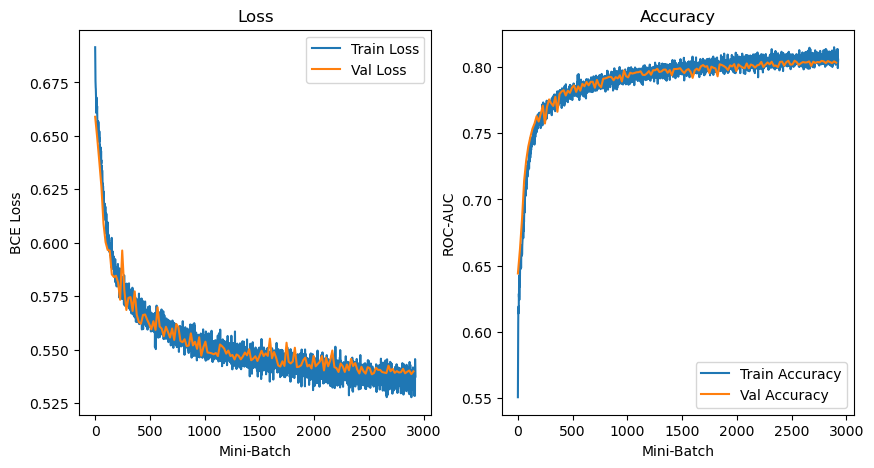

In [11]:
# Training curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.plot(np.arange(0, len(train_losses), int(len(train_losses)/(len(val_losses)))), val_losses, label='Val Loss')
plt.xlabel('Mini-Batch')
plt.ylabel('BCE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_aucs, label='Train Accuracy')
plt.plot(np.arange(0, len(train_aucs), int(len(train_aucs)/(len(val_aucs)))), val_aucs, label='Val Accuracy')
plt.xlabel('Mini-Batch')
plt.ylabel('ROC-AUC')
plt.legend()

In [12]:
# Performance on test set
trained_model = Net().to(device)

trained_model.load_state_dict(torch.load('/kaggle/working/saved_model.pth'))
trained_model.eval()

with torch.no_grad():
    test_loss = 0.0
    test_auc = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs,labels)
        test_loss += loss.item()
        test_auc += roc_auc_score(labels.numpy(), outputs.numpy())

print(f"The loss on testing data is {test_loss/len(test_loader)} and the ROC-AUC is {test_auc/len(test_loader)}")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The loss on testing data is 0.5378939825368215 and the ROC-AUC is 0.8046716095859441
